# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at forecasting using the data scraper.

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [0]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#!os.chdir('task-geo')
import pandas as pd
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv
!pip install wandb
!wandb login
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback 

--2020-04-28 20:45:58--  https://coronadatascraper.com/timeseries.csv
Resolving coronadatascraper.com (coronadatascraper.com)... 185.199.108.153, 185.199.110.153, 185.199.111.153
Connecting to coronadatascraper.com (coronadatascraper.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36751130 (35M) [text/csv]
Saving to: ‘coronavirus_timeseries.csv’

coronavirus_timeser 100%[===================>]  35.05M  52.9MB/s    in 0.7s    

2020-04-28 20:46:00 (52.9 MB/s) - ‘coronavirus_timeseries.csv’ saved [36751130/36751130]

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 102kB 11.6MB/s 
     |████████████████████████████████| 460kB 45.0MB/s 
     |████████████████████████████████| 112kB 49.2MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp

In [0]:
df = pd.read_csv("coronavirus_timeseries.csv")
df['month'] = pd.to_datetime(df['date']).map(lambda x: x.month)
df['weekday'] = pd.to_datetime(df['date']).map(lambda x: x.weekday())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
unqiue_counties = df['county'].unique()
print(len(unqiue_counties))

2015


We will now construct a list of suitable data at the county level.

In [0]:
def loop_through_geo_codes(df):
  df_county_list = []
  for code in df['county'].unique():
    mask = df['county'] == code
    df_code = df[mask]
    ts_count = len(df_code)
    if ts_count > 60:
      df_county_list.append(df_code)
  return df_county_list 
county_info = loop_through_geo_codes(df)
print(len(county_info))

343


## Forecasting in Antwerp
We will now piece together some simple tutorial code for forecasting new cases in Antwerp.

In [0]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
antwerp_df['new_cases'] = antwerp_df.cases.diff()
print(len(antwerp_df))

97


## Data Augmentation
We will now explore using the tsaug library for forecasting.

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug = TimeWarp(antwerp[:70])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
scaler_dict = {}
config_default = {"epochs":30, "validation_split":0.1, 
          "loss":"mean_squared_error", "optimizer":'adam', 
          "geo_segment":"antwerp", "seq_len":7, "train_steps":70, 
          "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
          "beta":0.899, "additional_features":["weekday","month"]}
r = RobustScaler()
x_train_full = antwerp_df[['deaths', 'new_cases']][1:config_default["train_steps"]]
x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
y_train_full = x_train_full
r_test = RobustScaler()
test_orig = antwerp_df[['deaths', 'new_cases']][70:]
test = pd.DataFrame(r_test.fit_transform(test_orig))

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [0]:
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "learn":{
            "values":[0.001, 0.0015, 0.002, 0.003, 0.004, 0.01]
        },
        "seq_len":{
            "values":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="covid-forecast")

Create sweep with ID: ogrx4cvd
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/ogrx4cvd


In [0]:
import matplotlib.pyplot as plt
def train():
  run = wandb.init(project="covid-forecast", config=config_default, magic=True)
  config = wandb.config
  X_train, Y_train = create_dataset(x_train_full, y_train_full, config["seq_len"])
  X_test, y_test = create_dataset(test, test, config["seq_len"])
  opt = keras.optimizers.Adam(learning_rate=config["learn"], beta_1=config["beta"], beta_2=0.999, amsgrad=False)
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  ) 
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=2))
  model.compile(loss=config["loss"], optimizer=opt)

  history = model.fit(
      X_train, Y_train,
      epochs=config["epochs"],
      batch_size=config["batch_size"],
      validation_split=config["validation_split"],
      callbacks=[WandbCallback()],
      shuffle=False
  )
  evaluate_single(model, X_test, y_test, r)
  evaluate_plot_multi(model, test, config, X_test, r_test)
  return model

def evaluate_single(model, x_test, y_test, scaler):
  y_preds = model.predict(x_test)
  y_preds = scaler.inverse_transform(y_preds)
  y_test = scaler.inverse_transform(y_test)
  complete_mse = tf.keras.losses.MSE( y_preds[:, 1], y_test[:, 1])
  wandb.run.summary["test_mse"] = complete_mse
  return complete_mse

def evaluate_plot_multi(model, test_df, config, x_test, scaler, predictor="new_cases"):
  arr = predict_multi(model, len(test)-config["seq_len"], x_test[0, :, :], config)
  test_orig['predicted_cases'] = 0
  test_orig['predicted_cases'][config["seq_len"]:] = scaler.inverse_transform(arr.squeeze(0))[:, 1]
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.log({"test":plt})
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.Image(plt, caption="Plot")
  large_mse = tf.keras.losses.MSE(
    scaler.inverse_transform(arr.squeeze(0))[:, 1], test_orig[predictor][config["seq_len"]:].values
  )
  wandb.run.summary["test_mse_full"] =  large_mse
  return large_mse

def predict_multi(model, time_steps, start_rows, config):
  start_rows=np.expand_dims(start_rows, axis=0)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]


In [0]:
wandb.agent(sweep_id, function=train)


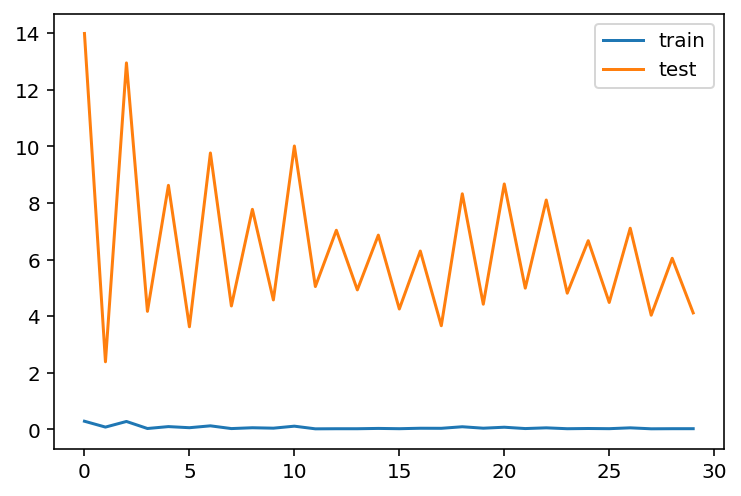

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Forecasting on all county levels
Now that we have loooked at Antwerp specifically we will design a general function to work on all geographic counties.

In [0]:
# TODO figure out how to get this into a function. Horrible to use global vars 
#like this. Still waiting on Slack response though.
#def run_geo_sweeps(county_info):
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
def run_geo_sweeps(county_info):
  for county in county_info:
    county = county.fillna(0)
    county_name = county['county'].values[0]
    config_default = {"epochs":30, "validation_split":0.1, 
            "loss":"mean_squared_error", "optimizer":'adam', 
            "geo_segment":county_name, "seq_len":7, "train_steps":60, 
            "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
            "beta":0.899, "additional_features":["none"]}
    county['new_cases'] = county.cases.diff()
    r = RobustScaler()
    x_train_full = county[['deaths', 'new_cases']][1:config_default["train_steps"]]
    x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
    y_train_full = x_train_full
    r_test = RobustScaler()
    test_orig = county[['deaths', 'new_cases']][60:]
    test = pd.DataFrame(r_test.fit_transform(test_orig))
    sweep_id = wandb.sweep(sweep_config, project="covid-forecast")
    wandb.agent(sweep_id, function=train)


Create sweep with ID: srq3x93t
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/srq3x93t
wandb: Agent Starting Run: n0vvi9jl with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: n0vvi9jl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 40ms/step - loss: 0.6859 - val_loss: 24.5056
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.5649 - val_loss: 20.5938
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.4586 - val_loss: 17.1108
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3724 - val_loss: 13.8791
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3284 - val_loss: 10.9974
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n0vvi9jl 

wandb: Agent Starting Run: e3bf7d3z with config:
	batch_size: 2
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: e3bf7d3z


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 0.6896 - val_loss: 21.5305
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 0.4020 - val_loss: 13.0950
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.2467 - val_loss: 6.8350
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1931 - val_loss: 3.7447
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 0.2079 - val_loss: 3.6979
Epoch 6/30
26/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: e3bf7d3z 

wandb: Agent Starting Run: p1r775ff with config:
	batch_size: 2
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: p1r775ff


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 35ms/step - loss: 0.6261 - val_loss: 20.3765
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.3068 - val_loss: 9.4579
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.1761 - val_loss: 3.1496
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.1910 - val_loss: 2.2639
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.1704 - val_loss: 3.1875
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: p1r775ff 

wandb: Agent Starting Run: wuwq3br5 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: wuwq3br5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.6413 - val_loss: 17.8634
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.2407 - val_loss: 4.9204
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2228 - val_loss: 2.8370
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 0.2316 - val_loss: 5.2711
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.1899 - val_loss: 4.6285
Epoch 6/30
25/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wuwq3br5 

wandb: Agent Starting Run: 25ydupqe with config:
	batch_size: 2
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: 25ydupqe


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 39ms/step - loss: 0.5857 - val_loss: 17.3774
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.2198 - val_loss: 3.6859
Epoch 3/30
24/24 [==============================] - 0s 9ms/step - loss: 0.2368 - val_loss: 1.5960
Epoch 4/30
24/24 [==============================] - 0s 7ms/step - loss: 0.2138 - val_loss: 4.2172
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 0.1689 - val_loss: 3.3791
Epoch 6/30
24/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 25ydupqe 

wandb: Agent Starting Run: b75re11h with config:
	batch_size: 2
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: b75re11h


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 41ms/step - loss: 0.6451 - val_loss: 16.7492
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.1858 - val_loss: 2.7838
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 0.2294 - val_loss: 2.8340
Epoch 4/30
24/24 [==============================] - 0s 10ms/step - loss: 0.2029 - val_loss: 5.7315
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1614 - val_loss: 4.0193
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: b75re11h 

wandb: Agent Starting Run: af66v7iw with config:
	batch_size: 2
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: af66v7iw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 42ms/step - loss: 0.6954 - val_loss: 19.2526
Epoch 2/30
23/23 [==============================] - 0s 9ms/step - loss: 0.2303 - val_loss: 4.1302
Epoch 3/30
23/23 [==============================] - 0s 10ms/step - loss: 0.2157 - val_loss: 1.4013
Epoch 4/30
23/23 [==============================] - 0s 9ms/step - loss: 0.2340 - val_loss: 4.2069
Epoch 5/30
23/23 [==============================] - 0s 9ms/step - loss: 0.1659 - val_loss: 2.9208
Epoch 6/30
23/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: af66v7iw 

wandb: Agent Starting Run: w18yff08 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: w18yff08


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 0.6994 - val_loss: 16.5467
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 0.1984 - val_loss: 2.0042
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.1876 - val_loss: 2.7068
Epoch 4/30
23/23 [==============================] - 0s 10ms/step - loss: 0.1895 - val_loss: 3.1101
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 0.2062 - val_loss: 5.1442
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: w18yff08 

wandb: Agent Starting Run: rvlxh3il with config:
	batch_size: 2
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: rvlxh3il


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 0.9766 - val_loss: 14.3191
Epoch 2/30
23/23 [==============================] - 0s 12ms/step - loss: 0.2260 - val_loss: 1.4356
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.1567 - val_loss: 1.6827
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1873 - val_loss: 1.5669
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1976 - val_loss: 2.7307
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rvlxh3il 

wandb: Agent Starting Run: jlz3cttq with config:
	batch_size: 2
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: jlz3cttq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 46ms/step - loss: 0.9414 - val_loss: 17.5884
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 0.1858 - val_loss: 1.5627
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 0.2965 - val_loss: 1.8151
Epoch 4/30
22/22 [==============================] - 0s 10ms/step - loss: 0.6223 - val_loss: 10.9959
Epoch 5/30
22/22 [==============================] - 0s 12ms/step - loss: 0.2384 - val_loss: 3.6736
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jlz3cttq 

wandb: Agent Starting Run: 5i3tem5b with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: 5i3tem5b


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 33ms/step - loss: 0.6537 - val_loss: 23.7247
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.4927 - val_loss: 18.2248
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3498 - val_loss: 13.4459
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2806 - val_loss: 9.3189
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2283 - val_loss: 6.3853
Epoch 6/30
26/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5i3tem5b 

wandb: Agent Starting Run: ev6mdqiw with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: ev6mdqiw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 0.5932 - val_loss: 17.8166
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2465 - val_loss: 7.0575
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1606 - val_loss: 2.5932
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2125 - val_loss: 3.6091
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 0.1756 - val_loss: 4.1042
Epoch 6/30
26/26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ev6mdqiw 

wandb: Agent Starting Run: 1u47kvk0 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: 1u47kvk0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 36ms/step - loss: 0.6200 - val_loss: 19.3594
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2263 - val_loss: 5.3465
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2252 - val_loss: 1.7272
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.2130 - val_loss: 3.6073
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.1656 - val_loss: 3.9183
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1u47kvk0 

wandb: Agent Starting Run: ohzfrehu with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: ohzfrehu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 39ms/step - loss: 0.4899 - val_loss: 12.1645
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.2402 - val_loss: 1.3854
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2465 - val_loss: 6.1790
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2033 - val_loss: 4.1778
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 0.1875 - val_loss: 4.1867
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ohzfrehu 

wandb: Agent Starting Run: rwh0upn2 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: rwh0upn2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 39ms/step - loss: 0.5516 - val_loss: 13.3785
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.2335 - val_loss: 0.9234
Epoch 3/30
24/24 [==============================] - 0s 8ms/step - loss: 0.2053 - val_loss: 4.0429
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 0.1816 - val_loss: 2.3568
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 0.1833 - val_loss: 3.3623
Epoch 6/30
24/24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rwh0upn2 

wandb: Agent Starting Run: wdpnqe4a with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: wdpnqe4a


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 42ms/step - loss: 0.5523 - val_loss: 11.0095
Epoch 2/30
24/24 [==============================] - 0s 11ms/step - loss: 0.2815 - val_loss: 1.2374
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 0.3642 - val_loss: 8.8998
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1892 - val_loss: 3.7904
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1628 - val_loss: 4.6835
Epoch 6/30
24/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wdpnqe4a 

wandb: Agent Starting Run: ve46wo29 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: ve46wo29


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 0.4504 - val_loss: 8.7329
Epoch 2/30
23/23 [==============================] - 0s 10ms/step - loss: 0.2598 - val_loss: 0.5502
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 0.3568 - val_loss: 7.0003
Epoch 4/30
23/23 [==============================] - 0s 10ms/step - loss: 0.1697 - val_loss: 2.3729
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.1875 - val_loss: 2.3537
Epoch 6/30
23/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ve46wo29 

wandb: Agent Starting Run: ca18kfxn with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: ca18kfxn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 0.5228 - val_loss: 10.3290
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 0.2322 - val_loss: 1.6535
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.4345 - val_loss: 9.7737
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1928 - val_loss: 3.6612
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1986 - val_loss: 5.2229
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ca18kfxn 

wandb: Agent Starting Run: 5xb7pdpu with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: 5xb7pdpu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 0.6531 - val_loss: 6.1866
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 0.3664 - val_loss: 0.8830
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.9257 - val_loss: 12.4753
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 0.2097 - val_loss: 3.0163
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.2415 - val_loss: 1.1704
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5xb7pdpu 

wandb: Agent Starting Run: 22gh4v63 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: 22gh4v63


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 55ms/step - loss: 0.5849 - val_loss: 7.9669
Epoch 2/30
22/22 [==============================] - 0s 13ms/step - loss: 0.2949 - val_loss: 2.4064
Epoch 3/30
22/22 [==============================] - 0s 12ms/step - loss: 0.7025 - val_loss: 11.0524
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 0.1664 - val_loss: 2.2505
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 0.1705 - val_loss: 3.9502
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 22gh4v63 

wandb: Agent Starting Run: ew09cr5q with config:
	batch_size: 2
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: ew09cr5q


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 41ms/step - loss: 0.6581 - val_loss: 23.3867
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.4547 - val_loss: 16.3031
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3112 - val_loss: 10.3165
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2293 - val_loss: 6.0728
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2118 - val_loss: 4.0320
Epoch 6/30
26/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ew09cr5q 

wandb: Agent Starting Run: vb2d6p5t with config:
	batch_size: 2
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: vb2d6p5t


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 0.6330 - val_loss: 18.4336
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.2174 - val_loss: 5.5848
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.2604 - val_loss: 2.6866
Epoch 4/30
26/26 [==============================] - 0s 8ms/step - loss: 0.2602 - val_loss: 6.7828
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.1665 - val_loss: 4.1524
Epoch 6/30
26/26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vb2d6p5t 

wandb: Agent Starting Run: mgwifyf1 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: mgwifyf1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 44ms/step - loss: 0.4975 - val_loss: 13.4676
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2031 - val_loss: 1.2293
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.1845 - val_loss: 3.0674
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.1885 - val_loss: 2.5826
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.1899 - val_loss: 3.6982
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mgwifyf1 

wandb: Agent Starting Run: gvu8of67 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: gvu8of67


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 39ms/step - loss: 0.4605 - val_loss: 10.0292
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.3535 - val_loss: 1.0222
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.3528 - val_loss: 9.9779
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.1883 - val_loss: 4.8814
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2180 - val_loss: 4.9048
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gvu8of67 

wandb: Agent Starting Run: ymym8mtu with config:
	batch_size: 2
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: ymym8mtu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 48ms/step - loss: 0.4614 - val_loss: 9.4743
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.3130 - val_loss: 0.6733
Epoch 3/30
24/24 [==============================] - 0s 8ms/step - loss: 0.3397 - val_loss: 8.0616
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 0.1842 - val_loss: 3.2961
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 0.1536 - val_loss: 3.5885
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ymym8mtu 

wandb: Agent Starting Run: 87u32dhv with config:
	batch_size: 2
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: 87u32dhv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 41ms/step - loss: 0.4496 - val_loss: 7.1193
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.3848 - val_loss: 1.4876
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 0.6776 - val_loss: 17.2870
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.2754 - val_loss: 8.1873
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1830 - val_loss: 3.6783
Epoch 6/30
24/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 87u32dhv 

wandb: Agent Starting Run: qycge50y with config:
	batch_size: 2
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: qycge50y


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 50ms/step - loss: 0.4282 - val_loss: 6.9547
Epoch 2/30
23/23 [==============================] - 0s 10ms/step - loss: 0.3407 - val_loss: 0.5556
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 0.5416 - val_loss: 12.2020
Epoch 4/30
23/23 [==============================] - 0s 9ms/step - loss: 0.1960 - val_loss: 4.5611
Epoch 5/30
23/23 [==============================] - 0s 9ms/step - loss: 0.1859 - val_loss: 1.9072
Epoch 6/30
23/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qycge50y 

wandb: Agent Starting Run: tkuwtst4 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: tkuwtst4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 0.4598 - val_loss: 5.3207
Epoch 2/30
23/23 [==============================] - 0s 12ms/step - loss: 0.3404 - val_loss: 2.2054
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.7253 - val_loss: 16.2236
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.2190 - val_loss: 5.4203
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1783 - val_loss: 2.9400
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tkuwtst4 

wandb: Agent Starting Run: j4z4bwkw with config:
	batch_size: 2
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: j4z4bwkw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 0.6182 - val_loss: 4.0419
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 0.5129 - val_loss: 2.1092
Epoch 3/30
23/23 [==============================] - 0s 14ms/step - loss: 0.8988 - val_loss: 7.4194
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.3724 - val_loss: 2.1247
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7407 - val_loss: 9.4087
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j4z4bwkw 

wandb: Agent Starting Run: 0fxk1yzz with config:
	batch_size: 2
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: 0fxk1yzz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 55ms/step - loss: 0.4707 - val_loss: 2.8070
Epoch 2/30
22/22 [==============================] - 0s 12ms/step - loss: 0.4854 - val_loss: 2.1899
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 0.4708 - val_loss: 3.9381
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 0.8276 - val_loss: 1.2452
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 0.8621 - val_loss: 17.0621
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0fxk1yzz 

wandb: Agent Starting Run: 599hrcpy with config:
	batch_size: 2
	learn: 0.003
	seq_len: 1
wandb: Agent Started Run: 599hrcpy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 42ms/step - loss: 0.5670 - val_loss: 19.3875
Epoch 2/30
26/26 [==============================] - 0s 5ms/step - loss: 0.3082 - val_loss: 9.6654
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2021 - val_loss: 4.0491
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.1882 - val_loss: 2.3815
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 0.1816 - val_loss: 2.4725
Epoch 6/30
26/26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 599hrcpy 

wandb: Agent Starting Run: g3wwupzb with config:
	batch_size: 2
	learn: 0.003
	seq_len: 2
wandb: Agent Started Run: g3wwupzb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 0.5598 - val_loss: 14.7732
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.2010 - val_loss: 2.3435
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2288 - val_loss: 5.3247
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1935 - val_loss: 4.2318
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.1835 - val_loss: 3.9797
Epoch 6/30
26/26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g3wwupzb 

wandb: Agent Starting Run: 6sq75oay with config:
	batch_size: 2
	learn: 0.003
	seq_len: 3
wandb: Agent Started Run: 6sq75oay


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 44ms/step - loss: 0.4086 - val_loss: 8.4490
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.3846 - val_loss: 0.7596
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.2992 - val_loss: 7.2653
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.1880 - val_loss: 3.1253
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.1854 - val_loss: 4.1960
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6sq75oay 

wandb: Agent Starting Run: dcgk94nb with config:
	batch_size: 2
	learn: 0.003
	seq_len: 4
wandb: Agent Started Run: dcgk94nb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 39ms/step - loss: 0.3404 - val_loss: 3.8524
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.3857 - val_loss: 1.3942
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6582 - val_loss: 17.8016
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2147 - val_loss: 5.9328
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2095 - val_loss: 3.4071
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dcgk94nb 

wandb: Agent Starting Run: 7awx8nuq with config:
	batch_size: 2
	learn: 0.003
	seq_len: 5
wandb: Agent Started Run: 7awx8nuq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 48ms/step - loss: 0.3217 - val_loss: 3.0789
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 0.4220 - val_loss: 1.0492
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 0.5505 - val_loss: 14.7856
Epoch 4/30
24/24 [==============================] - 0s 7ms/step - loss: 0.2162 - val_loss: 5.8626
Epoch 5/30
24/24 [==============================] - 0s 7ms/step - loss: 0.1954 - val_loss: 3.0395
Epoch 6/30
24/24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7awx8nuq 

wandb: Agent Starting Run: ngbfeb5e with config:
	batch_size: 2
	learn: 0.003
	seq_len: 6
wandb: Agent Started Run: ngbfeb5e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 0.3155 - val_loss: 2.7185
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.2601 - val_loss: 3.0161
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.1772 - val_loss: 6.5296
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.3076 - val_loss: 5.8768
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 0.4283 - val_loss: 12.8970
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ngbfeb5e 

wandb: Agent Starting Run: c96wougb with config:
	batch_size: 2
	learn: 0.003
	seq_len: 7
wandb: Agent Started Run: c96wougb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 51ms/step - loss: 0.3358 - val_loss: 2.9892
Epoch 2/30
23/23 [==============================] - 0s 10ms/step - loss: 0.3150 - val_loss: 1.2083
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 0.3972 - val_loss: 9.7565
Epoch 4/30
23/23 [==============================] - 0s 8ms/step - loss: 0.2005 - val_loss: 3.6843
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 0.2077 - val_loss: 4.7877
Epoch 6/30
23/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c96wougb 

wandb: Agent Starting Run: m56w21bq with config:
	batch_size: 2
	learn: 0.003
	seq_len: 8
wandb: Agent Started Run: m56w21bq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 0.3067 - val_loss: 1.7316
Epoch 2/30
23/23 [==============================] - 0s 12ms/step - loss: 0.2641 - val_loss: 3.5856
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.2521 - val_loss: 4.6377
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.3549 - val_loss: 6.2286
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.3666 - val_loss: 9.4951
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: m56w21bq 

wandb: Agent Starting Run: kk71wvk2 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 9
wandb: Agent Started Run: kk71wvk2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 0.3157 - val_loss: 1.0393
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 0.4482 - val_loss: 1.1615
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.4629 - val_loss: 2.0890
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 0.5113 - val_loss: 3.7432
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.2227 - val_loss: 1.3119
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kk71wvk2 

wandb: Agent Starting Run: xdtzd4ka with config:
	batch_size: 2
	learn: 0.003
	seq_len: 10
wandb: Agent Started Run: xdtzd4ka


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 56ms/step - loss: 0.2802 - val_loss: 1.1462
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 0.2484 - val_loss: 2.7616
Epoch 3/30
22/22 [==============================] - 0s 12ms/step - loss: 0.4710 - val_loss: 5.3071
Epoch 4/30
22/22 [==============================] - 0s 13ms/step - loss: 0.2755 - val_loss: 2.5687
Epoch 5/30
22/22 [==============================] - 0s 12ms/step - loss: 0.5895 - val_loss: 4.6631
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xdtzd4ka 

wandb: Agent Starting Run: 68szbvop with config:
	batch_size: 2
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: 68szbvop


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 41ms/step - loss: 0.5477 - val_loss: 18.3371
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2575 - val_loss: 7.0297
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.1763 - val_loss: 2.3498
Epoch 4/30
26/26 [==============================] - 0s 5ms/step - loss: 0.2057 - val_loss: 2.4848
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 0.1909 - val_loss: 3.1509
Epoch 6/30
26/26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 68szbvop 

wandb: Agent Starting Run: 926nb9th with config:
	batch_size: 2
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: 926nb9th


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.4083 - val_loss: 9.1640
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.3271 - val_loss: 1.2172
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.3433 - val_loss: 9.5698
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1659 - val_loss: 3.1869
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.1622 - val_loss: 4.9514
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 926nb9th 

wandb: Agent Starting Run: gnnm85vc with config:
	batch_size: 2
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: gnnm85vc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 45ms/step - loss: 0.3281 - val_loss: 5.2958
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.4494 - val_loss: 0.8204
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.4826 - val_loss: 13.7505
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.2156 - val_loss: 5.5530
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.2082 - val_loss: 3.4380
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gnnm85vc 

wandb: Agent Starting Run: alcr61gt with config:
	batch_size: 2
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: alcr61gt


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.3368 - val_loss: 2.7462
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2228 - val_loss: 4.3000
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.2080 - val_loss: 6.0874
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 0.4738 - val_loss: 12.1670
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.2409 - val_loss: 5.4093
Epoch 6/30
25/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: alcr61gt 

wandb: Agent Starting Run: 0yozsst4 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: 0yozsst4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 47ms/step - loss: 0.3222 - val_loss: 2.7413
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 0.2248 - val_loss: 2.7729
Epoch 3/30
24/24 [==============================] - 0s 8ms/step - loss: 0.2614 - val_loss: 4.3405
Epoch 4/30
24/24 [==============================] - 0s 7ms/step - loss: 0.3251 - val_loss: 7.2748
Epoch 5/30
24/24 [==============================] - 0s 7ms/step - loss: 0.2420 - val_loss: 6.8732
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0yozsst4 

wandb: Agent Starting Run: qkmegbp9 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: qkmegbp9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 42ms/step - loss: 0.3326 - val_loss: 1.2643
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.3784 - val_loss: 8.4639
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.2532 - val_loss: 5.6633
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.4725 - val_loss: 12.4479
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.2140 - val_loss: 5.1955
Epoch 6/30
24/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qkmegbp9 

wandb: Agent Starting Run: n0cepa0f with config:
	batch_size: 2
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: n0cepa0f


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 51ms/step - loss: 0.3153 - val_loss: 1.5194
Epoch 2/30
23/23 [==============================] - 0s 9ms/step - loss: 0.3564 - val_loss: 8.6228
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 0.2089 - val_loss: 3.9467
Epoch 4/30
23/23 [==============================] - 0s 9ms/step - loss: 0.4343 - val_loss: 9.5093
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.2674 - val_loss: 6.2531
Epoch 6/30
23/23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n0cepa0f 

wandb: Agent Starting Run: veg9pfh5 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: veg9pfh5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 48ms/step - loss: 0.4578 - val_loss: 0.8897
Epoch 2/30
23/23 [==============================] - 0s 12ms/step - loss: 0.5427 - val_loss: 12.6620
Epoch 3/30
23/23 [==============================] - 0s 14ms/step - loss: 0.2124 - val_loss: 5.5948
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 0.1898 - val_loss: 6.3940
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.3076 - val_loss: 6.2740
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: veg9pfh5 

wandb: Agent Starting Run: o64ldmd4 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: o64ldmd4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 0.5786 - val_loss: 2.2415
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 1.0867 - val_loss: 17.4322
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.2204 - val_loss: 3.3034
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.4670 - val_loss: 5.9610
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.9278 - val_loss: 12.6668
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o64ldmd4 

wandb: Agent Starting Run: 84fjgu8k with config:
	batch_size: 2
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: 84fjgu8k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 56ms/step - loss: 0.2518 - val_loss: 2.5985
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 0.6852 - val_loss: 12.9064
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 0.5136 - val_loss: 5.1615
Epoch 4/30
22/22 [==============================] - 0s 11ms/step - loss: 0.3674 - val_loss: 6.1183
Epoch 5/30
22/22 [==============================] - 0s 13ms/step - loss: 0.7706 - val_loss: 15.5342
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 84fjgu8k 

wandb: Agent Starting Run: rz7i2wre with config:
	batch_size: 2
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: rz7i2wre


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 42ms/step - loss: 0.3941 - val_loss: 9.4932
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3964 - val_loss: 1.7557
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 0.1835 - val_loss: 2.5136
Epoch 4/30
26/26 [==============================] - 0s 4ms/step - loss: 0.2181 - val_loss: 2.2486
Epoch 5/30
26/26 [==============================] - 0s 4ms/step - loss: 0.2140 - val_loss: 4.7049
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rz7i2wre 

wandb: Agent Starting Run: 8asow0l8 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 8asow0l8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 0.2465 - val_loss: 2.2261
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3821 - val_loss: 9.7241
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 0.2868 - val_loss: 5.3952
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.5224 - val_loss: 15.2902
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 0.2037 - val_loss: 4.3007
Epoch 6/30
26/26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8asow0l8 

wandb: Agent Starting Run: 2xzph4sr with config:
	batch_size: 2
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: 2xzph4sr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 45ms/step - loss: 0.6424 - val_loss: 0.6547
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.5669 - val_loss: 17.3653
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.2131 - val_loss: 4.5460
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.2271 - val_loss: 7.0725
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.2503 - val_loss: 9.8382
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2xzph4sr 

wandb: Agent Starting Run: e4lwyps5 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: e4lwyps5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.3200 - val_loss: 5.1845
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5472 - val_loss: 10.6535
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.3809 - val_loss: 6.4567
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.4640 - val_loss: 10.1287
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6491 - val_loss: 13.0942
Epoch 6/30
25/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: e4lwyps5 

wandb: Agent Starting Run: goom7epd with config:
	batch_size: 2
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: goom7epd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 48ms/step - loss: 0.3013 - val_loss: 2.9697
Epoch 2/30
24/24 [==============================] - 0s 7ms/step - loss: 0.3260 - val_loss: 7.3047
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 0.3601 - val_loss: 3.3410
Epoch 4/30
24/24 [==============================] - 0s 7ms/step - loss: 0.1787 - val_loss: 5.6929
Epoch 5/30
24/24 [==============================] - 0s 7ms/step - loss: 0.2439 - val_loss: 7.8157
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: goom7epd 

wandb: Agent Starting Run: 3lkfhsjs with config:
	batch_size: 2
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: 3lkfhsjs


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 41ms/step - loss: 0.3982 - val_loss: 3.5905
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 0.4305 - val_loss: 6.5694
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 0.3888 - val_loss: 5.3356
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.2861 - val_loss: 6.6644
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1733 - val_loss: 4.9866
Epoch 6/30
24/24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3lkfhsjs 

wandb: Agent Starting Run: hrqcvrcd with config:
	batch_size: 2
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: hrqcvrcd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 51ms/step - loss: 0.2923 - val_loss: 4.1073
Epoch 2/30
23/23 [==============================] - 0s 10ms/step - loss: 0.3184 - val_loss: 3.5384
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 0.2714 - val_loss: 7.2806
Epoch 4/30
23/23 [==============================] - 0s 9ms/step - loss: 0.4238 - val_loss: 6.4561
Epoch 5/30
23/23 [==============================] - 0s 9ms/step - loss: 0.2771 - val_loss: 7.8300
Epoch 6/30
23/23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hrqcvrcd 

wandb: Agent Starting Run: s7vxlex6 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: s7vxlex6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 0.3402 - val_loss: 4.5406
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 0.3254 - val_loss: 5.1061
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.3067 - val_loss: 6.7749
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1307 - val_loss: 4.3505
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.3483 - val_loss: 7.2201
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: s7vxlex6 

wandb: Agent Starting Run: fn1afboi with config:
	batch_size: 2
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: fn1afboi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 0.4862 - val_loss: 1.3962
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 1.4770 - val_loss: 3.2604
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 1.0426 - val_loss: 10.6114
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 2.5650 - val_loss: 16.0597
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.9746 - val_loss: 14.1860
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fn1afboi 

wandb: Agent Starting Run: c8q6eulu with config:
	batch_size: 2
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: c8q6eulu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 56ms/step - loss: 0.5162 - val_loss: 2.5082
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 0.8476 - val_loss: 10.6120
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 0.5553 - val_loss: 4.3088
Epoch 4/30
22/22 [==============================] - 0s 11ms/step - loss: 0.4072 - val_loss: 3.7006
Epoch 5/30
22/22 [==============================] - 0s 13ms/step - loss: 0.3138 - val_loss: 6.2893
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c8q6eulu 

wandb: Agent Starting Run: u7nshmp3 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: u7nshmp3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 49ms/step - loss: 0.8627 - val_loss: 26.5621
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 0.7517 - val_loss: 23.4725
Epoch 3/30
18/18 [==============================] - 0s 8ms/step - loss: 0.6502 - val_loss: 20.6716
Epoch 4/30
18/18 [==============================] - 0s 9ms/step - loss: 0.5658 - val_loss: 17.9899
Epoch 5/30
18/18 [==============================] - 0s 10ms/step - loss: 0.4817 - val_loss: 15.3848
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u7nshmp3 

wandb: Agent Starting Run: glr8iwak with config:
	batch_size: 3
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: glr8iwak


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 63ms/step - loss: 0.7241 - val_loss: 25.6489
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.5176 - val_loss: 19.4987
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.3942 - val_loss: 14.3225
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2764 - val_loss: 9.7358
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2158 - val_loss: 6.0938
Epoch 6/30
17/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: glr8iwak 

wandb: Agent Starting Run: 0rk4ru0t with config:
	batch_size: 3
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: 0rk4ru0t


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 0.7442 - val_loss: 22.5714
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4231 - val_loss: 12.8489
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2368 - val_loss: 5.9651
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2044 - val_loss: 2.9378
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2346 - val_loss: 3.3437
Epoch 6/30
17/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0rk4ru0t 

wandb: Agent Starting Run: qk06iom1 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: qk06iom1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 54ms/step - loss: 0.7033 - val_loss: 19.4556
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2961 - val_loss: 8.1977
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2139 - val_loss: 2.3050
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2228 - val_loss: 4.0439
Epoch 5/30
17/17 [==============================] - 0s 11ms/step - loss: 0.1908 - val_loss: 4.8544
Epoch 6/30
17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qk06iom1 

wandb: Agent Starting Run: 9h782rth with config:
	batch_size: 3
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: 9h782rth


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 68ms/step - loss: 0.6163 - val_loss: 19.0482
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 0.2934 - val_loss: 8.4049
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.1788 - val_loss: 2.3945
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.1633 - val_loss: 2.4283
Epoch 5/30
16/16 [==============================] - 0s 7ms/step - loss: 0.1913 - val_loss: 3.7302
Epoch 6/30
16/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9h782rth 

wandb: Agent Starting Run: l2snaekj with config:
	batch_size: 3
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: l2snaekj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 0.7747 - val_loss: 21.5156
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 0.3351 - val_loss: 8.0235
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2396 - val_loss: 1.4005
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2218 - val_loss: 2.8875
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.1874 - val_loss: 3.6973
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: l2snaekj 

wandb: Agent Starting Run: say1gj16 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: say1gj16


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 0.7673 - val_loss: 18.3345
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2421 - val_loss: 5.3319
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.3117 - val_loss: 1.7866
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2674 - val_loss: 6.7842
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.1671 - val_loss: 4.4511
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: say1gj16 

wandb: Agent Starting Run: ziw7z5bj with config:
	batch_size: 3
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: ziw7z5bj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 73ms/step - loss: 0.6821 - val_loss: 18.8219
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.2633 - val_loss: 5.2557
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 0.2216 - val_loss: 0.6807
Epoch 4/30
15/15 [==============================] - 0s 9ms/step - loss: 0.2054 - val_loss: 4.0832
Epoch 5/30
15/15 [==============================] - 0s 9ms/step - loss: 0.1426 - val_loss: 2.3618
Epoch 6/30
15/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ziw7z5bj 

wandb: Agent Starting Run: 62b03tlv with config:
	batch_size: 3
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: 62b03tlv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 76ms/step - loss: 0.9975 - val_loss: 21.8442
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 0.4098 - val_loss: 6.6230
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.2831 - val_loss: 0.6517
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 0.2220 - val_loss: 3.2235
Epoch 5/30
15/15 [==============================] - 0s 10ms/step - loss: 0.1630 - val_loss: 2.0471
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 62b03tlv 

wandb: Agent Starting Run: 64uzjeoi with config:
	batch_size: 3
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: 64uzjeoi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 1.0570 - val_loss: 18.3668
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 0.3486 - val_loss: 3.5657
Epoch 3/30
15/15 [==============================] - 0s 16ms/step - loss: 0.4456 - val_loss: 0.5893
Epoch 4/30
15/15 [==============================] - 0s 16ms/step - loss: 0.4139 - val_loss: 7.1266
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.2744 - val_loss: 4.1168
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 64uzjeoi 

wandb: Agent Starting Run: vq99u58t with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: vq99u58t


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 46ms/step - loss: 0.8432 - val_loss: 26.0622
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 0.6684 - val_loss: 21.6821
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 0.5435 - val_loss: 17.6462
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 0.4365 - val_loss: 13.8746
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 0.3239 - val_loss: 10.4578
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vq99u58t 

wandb: Agent Starting Run: wc2erpp8 with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: wc2erpp8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 62ms/step - loss: 0.6947 - val_loss: 24.2365
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4337 - val_loss: 15.6721
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2536 - val_loss: 8.8192
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1887 - val_loss: 4.3439
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 0.1481 - val_loss: 2.6254
Epoch 6/30
17/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wc2erpp8 

wandb: Agent Starting Run: hy3503be with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: hy3503be


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 0.7191 - val_loss: 21.8282
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.3006 - val_loss: 8.8947
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1934 - val_loss: 2.5784
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2192 - val_loss: 3.6466
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2130 - val_loss: 5.3131
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hy3503be 

wandb: Agent Starting Run: pvxnexf3 with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: pvxnexf3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 0.7764 - val_loss: 20.8159
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2529 - val_loss: 6.2426
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2712 - val_loss: 1.8497
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2392 - val_loss: 6.4122
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1895 - val_loss: 4.5720
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pvxnexf3 

wandb: Agent Starting Run: i3zygzbq with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: i3zygzbq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 66ms/step - loss: 0.5499 - val_loss: 14.8908
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 0.1880 - val_loss: 2.5273
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2010 - val_loss: 1.3794
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.1942 - val_loss: 4.9989
Epoch 5/30
16/16 [==============================] - 0s 7ms/step - loss: 0.1457 - val_loss: 2.5808
Epoch 6/30
16/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: i3zygzbq 

wandb: Agent Starting Run: ctuzenu1 with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: ctuzenu1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 0.6690 - val_loss: 18.0047
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2156 - val_loss: 3.7822
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2345 - val_loss: 2.3060
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2170 - val_loss: 5.0683
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2076 - val_loss: 4.5949
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ctuzenu1 

wandb: Agent Starting Run: h9yohq7h with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: h9yohq7h


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 58ms/step - loss: 0.7447 - val_loss: 17.3777
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2173 - val_loss: 2.9159
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 0.1798 - val_loss: 4.5317
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2051 - val_loss: 5.2783
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1961 - val_loss: 5.9383
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: h9yohq7h 

wandb: Agent Starting Run: rer4jpw7 with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: rer4jpw7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 74ms/step - loss: 0.5422 - val_loss: 14.1301
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.1424 - val_loss: 1.4680
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 0.1718 - val_loss: 1.9057
Epoch 4/30
15/15 [==============================] - 0s 9ms/step - loss: 0.2595 - val_loss: 7.0176
Epoch 5/30
15/15 [==============================] - 0s 9ms/step - loss: 0.1724 - val_loss: 2.9916
Epoch 6/30
15/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rer4jpw7 

wandb: Agent Starting Run: pznfhc9p with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: pznfhc9p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 67ms/step - loss: 0.8855 - val_loss: 16.7749
Epoch 2/30
15/15 [==============================] - 0s 14ms/step - loss: 0.1784 - val_loss: 1.5683
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 0.2433 - val_loss: 1.2759
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 0.2686 - val_loss: 4.5975
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 0.1680 - val_loss: 2.0602
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pznfhc9p 

wandb: Agent Starting Run: gyjw7n1k with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: gyjw7n1k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 70ms/step - loss: 0.8312 - val_loss: 12.7949
Epoch 2/30
15/15 [==============================] - 0s 19ms/step - loss: 0.2189 - val_loss: 1.1748
Epoch 3/30
15/15 [==============================] - 0s 15ms/step - loss: 0.4085 - val_loss: 6.2287
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 0.1984 - val_loss: 1.7678
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 0.1683 - val_loss: 2.9034
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gyjw7n1k 

wandb: Agent Starting Run: vhg7c9j8 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: vhg7c9j8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 53ms/step - loss: 0.8007 - val_loss: 24.1007
Epoch 2/30
18/18 [==============================] - 0s 11ms/step - loss: 0.5993 - val_loss: 18.6167
Epoch 3/30
18/18 [==============================] - 0s 10ms/step - loss: 0.4291 - val_loss: 13.5776
Epoch 4/30
18/18 [==============================] - 0s 9ms/step - loss: 0.3024 - val_loss: 9.1164
Epoch 5/30
18/18 [==============================] - 0s 9ms/step - loss: 0.2542 - val_loss: 5.7731
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vhg7c9j8 

wandb: Agent Starting Run: acszsff3 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: acszsff3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 58ms/step - loss: 0.6121 - val_loss: 20.9759
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.3187 - val_loss: 10.5202
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1902 - val_loss: 3.8656
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1775 - val_loss: 2.1564
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1681 - val_loss: 2.7315
Epoch 6/30
17/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: acszsff3 

wandb: Agent Starting Run: qnw8yqvx with config:
	batch_size: 3
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: qnw8yqvx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 58ms/step - loss: 0.6217 - val_loss: 18.9162
Epoch 2/30
17/17 [==============================] - 0s 12ms/step - loss: 0.2139 - val_loss: 4.6125
Epoch 3/30
17/17 [==============================] - 0s 11ms/step - loss: 0.1944 - val_loss: 3.1618
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1823 - val_loss: 4.8240
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1825 - val_loss: 4.4664
Epoch 6/30
17/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qnw8yqvx 

wandb: Agent Starting Run: tu019q4u with config:
	batch_size: 3
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: tu019q4u


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 59ms/step - loss: 0.7267 - val_loss: 17.7080
Epoch 2/30
17/17 [==============================] - 0s 11ms/step - loss: 0.1995 - val_loss: 3.3353
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2556 - val_loss: 3.4164
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2317 - val_loss: 6.4392
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1820 - val_loss: 5.1783
Epoch 6/30
17/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tu019q4u 

wandb: Agent Starting Run: aikmp8cc with config:
	batch_size: 3
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: aikmp8cc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 72ms/step - loss: 0.4955 - val_loss: 12.9980
Epoch 2/30
16/16 [==============================] - 0s 14ms/step - loss: 0.1941 - val_loss: 1.4227
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.2212 - val_loss: 4.2620
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2036 - val_loss: 3.0614
Epoch 5/30
16/16 [==============================] - 0s 9ms/step - loss: 0.1875 - val_loss: 4.9040
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: aikmp8cc 

wandb: Agent Starting Run: jv8ab5jk with config:
	batch_size: 3
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: jv8ab5jk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 66ms/step - loss: 0.6462 - val_loss: 14.8161
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.2722 - val_loss: 1.2131
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2475 - val_loss: 5.4932
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.1957 - val_loss: 4.2418
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.1987 - val_loss: 3.7469
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jv8ab5jk 

wandb: Agent Starting Run: vm5xd29i with config:
	batch_size: 3
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: vm5xd29i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 72ms/step - loss: 0.6440 - val_loss: 13.0387
Epoch 2/30
16/16 [==============================] - 0s 15ms/step - loss: 0.3803 - val_loss: 1.1854
Epoch 3/30
16/16 [==============================] - 0s 14ms/step - loss: 0.3934 - val_loss: 9.3858
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2015 - val_loss: 4.5303
Epoch 5/30
16/16 [==============================] - 0s 15ms/step - loss: 0.2051 - val_loss: 3.4366
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vm5xd29i 

wandb: Agent Starting Run: 9as3d5nx with config:
	batch_size: 3
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: 9as3d5nx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 69ms/step - loss: 0.5445 - val_loss: 13.9177
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 0.1702 - val_loss: 1.1000
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.1738 - val_loss: 3.4280
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 0.2503 - val_loss: 2.4957
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 0.4354 - val_loss: 12.8019
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9as3d5nx 

wandb: Agent Starting Run: 48brnp3o with config:
	batch_size: 3
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: 48brnp3o


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 69ms/step - loss: 0.5943 - val_loss: 8.5356
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 0.4132 - val_loss: 0.5518
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 0.7421 - val_loss: 13.4640
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 0.3989 - val_loss: 7.4978
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.2085 - val_loss: 2.5464
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 48brnp3o 

wandb: Agent Starting Run: j9a114ts with config:
	batch_size: 3
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: j9a114ts


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 75ms/step - loss: 0.8178 - val_loss: 10.5614
Epoch 2/30
15/15 [==============================] - 0s 19ms/step - loss: 0.2624 - val_loss: 1.4124
Epoch 3/30
15/15 [==============================] - 0s 17ms/step - loss: 0.8781 - val_loss: 14.2946
Epoch 4/30
15/15 [==============================] - 0s 20ms/step - loss: 0.3494 - val_loss: 5.7083
Epoch 5/30
15/15 [==============================] - 0s 21ms/step - loss: 0.2259 - val_loss: 1.9978
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j9a114ts 

wandb: Agent Starting Run: nwkty8dz with config:
	batch_size: 3
	learn: 0.003
	seq_len: 1
wandb: Agent Started Run: nwkty8dz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 48ms/step - loss: 0.7865 - val_loss: 23.1181
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 0.4955 - val_loss: 15.0399
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 0.2918 - val_loss: 8.2724
Epoch 4/30
18/18 [==============================] - 0s 8ms/step - loss: 0.2069 - val_loss: 3.8948
Epoch 5/30
18/18 [==============================] - 0s 9ms/step - loss: 0.1733 - val_loss: 2.3532
Epoch 6/30
18/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nwkty8dz 

wandb: Agent Starting Run: kn4slym6 with config:
	batch_size: 3
	learn: 0.003
	seq_len: 2
wandb: Agent Started Run: kn4slym6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 58ms/step - loss: 0.5654 - val_loss: 18.2406
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2018 - val_loss: 4.9255
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2200 - val_loss: 1.3868
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1781 - val_loss: 4.0708
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1541 - val_loss: 3.1097
Epoch 6/30
17/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kn4slym6 

wandb: Agent Starting Run: 0c87tjd9 with config:
	batch_size: 3
	learn: 0.003
	seq_len: 3
wandb: Agent Started Run: 0c87tjd9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 0.4495 - val_loss: 11.8820
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.3794 - val_loss: 0.7872
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2436 - val_loss: 6.9886
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1699 - val_loss: 4.8064
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1849 - val_loss: 4.0089
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0c87tjd9 

wandb: Agent Starting Run: 2fiuybil with config:
	batch_size: 3
	learn: 0.003
	seq_len: 4
wandb: Agent Started Run: 2fiuybil


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 59ms/step - loss: 0.4524 - val_loss: 8.6958
Epoch 2/30
17/17 [==============================] - 0s 12ms/step - loss: 0.5275 - val_loss: 0.8532
Epoch 3/30
17/17 [==============================] - 0s 11ms/step - loss: 0.4877 - val_loss: 13.2237
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2415 - val_loss: 7.7571
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2173 - val_loss: 4.8045
Epoch 6/30
17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2fiuybil 

wandb: Agent Starting Run: fsq3w8xy with config:
	batch_size: 3
	learn: 0.003
	seq_len: 5
wandb: Agent Started Run: fsq3w8xy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 58ms/step - loss: 0.4923 - val_loss: 10.9231
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 0.3926 - val_loss: 0.8270
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.4845 - val_loss: 13.4617
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 0.2228 - val_loss: 7.2528
Epoch 5/30
16/16 [==============================] - 0s 9ms/step - loss: 0.1857 - val_loss: 3.7564
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fsq3w8xy 

wandb: Agent Starting Run: oyaput6x with config:
	batch_size: 3
	learn: 0.003
	seq_len: 6
wandb: Agent Started Run: oyaput6x


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 0.5950 - val_loss: 10.4228
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 0.5385 - val_loss: 0.6184
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.6001 - val_loss: 14.2403
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2992 - val_loss: 8.1836
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.1949 - val_loss: 4.4134
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oyaput6x 

wandb: Agent Starting Run: aco4pzdy with config:
	batch_size: 3
	learn: 0.003
	seq_len: 7
wandb: Agent Started Run: aco4pzdy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 66ms/step - loss: 0.4349 - val_loss: 4.6880
Epoch 2/30
16/16 [==============================] - 0s 17ms/step - loss: 0.4781 - val_loss: 2.9484
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.9156 - val_loss: 23.1138
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.4425 - val_loss: 12.7874
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2057 - val_loss: 3.8349
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: aco4pzdy 

wandb: Agent Starting Run: ei21a7y9 with config:
	batch_size: 3
	learn: 0.003
	seq_len: 8
wandb: Agent Started Run: ei21a7y9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 61ms/step - loss: 0.5097 - val_loss: 9.5856
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.2736 - val_loss: 0.9156
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 0.5939 - val_loss: 16.5490
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 0.2117 - val_loss: 6.4471
Epoch 5/30
15/15 [==============================] - 0s 10ms/step - loss: 0.1842 - val_loss: 2.4465
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ei21a7y9 

wandb: Agent Starting Run: fadjeb78 with config:
	batch_size: 3
	learn: 0.003
	seq_len: 9
wandb: Agent Started Run: fadjeb78


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 0.6899 - val_loss: 8.0860
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 0.4773 - val_loss: 0.6654
Epoch 3/30
15/15 [==============================] - 0s 12ms/step - loss: 0.9946 - val_loss: 21.6076
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 0.6420 - val_loss: 13.2407
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 0.3126 - val_loss: 4.6227
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fadjeb78 

wandb: Agent Starting Run: bpzupnu6 with config:
	batch_size: 3
	learn: 0.003
	seq_len: 10
wandb: Agent Started Run: bpzupnu6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 67ms/step - loss: 0.7415 - val_loss: 7.2827
Epoch 2/30
15/15 [==============================] - 0s 17ms/step - loss: 0.4053 - val_loss: 3.9490
Epoch 3/30
15/15 [==============================] - 0s 17ms/step - loss: 0.9137 - val_loss: 10.1316
Epoch 4/30
15/15 [==============================] - 0s 15ms/step - loss: 0.1893 - val_loss: 3.6621
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 0.3846 - val_loss: 5.8646
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bpzupnu6 

wandb: Agent Starting Run: aug9p62k with config:
	batch_size: 3
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: aug9p62k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 47ms/step - loss: 0.7693 - val_loss: 22.6448
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 0.4175 - val_loss: 12.2424
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 0.2183 - val_loss: 5.0212
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 0.1858 - val_loss: 2.2158
Epoch 5/30
18/18 [==============================] - 0s 8ms/step - loss: 0.1691 - val_loss: 2.0871
Epoch 6/30
18/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: aug9p62k 

wandb: Agent Starting Run: ethjsqic with config:
	batch_size: 3
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: ethjsqic


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 50ms/step - loss: 0.5252 - val_loss: 15.9287
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1711 - val_loss: 3.0268
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2021 - val_loss: 2.4288
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 0.2109 - val_loss: 5.4986
Epoch 5/30
17/17 [==============================] - 0s 5ms/step - loss: 0.1549 - val_loss: 4.2386
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ethjsqic 

wandb: Agent Starting Run: 428ot60j with config:
	batch_size: 3
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 428ot60j


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 2s 95ms/step - loss: 0.4436 - val_loss: 9.5033
Epoch 2/30
17/17 [==============================] - 0s 13ms/step - loss: 0.5529 - val_loss: 0.7848
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.3959 - val_loss: 10.1491
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2099 - val_loss: 6.4035
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1783 - val_loss: 4.1663
Epoch 6/30
17/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 428ot60j 

wandb: Agent Starting Run: 85ye42it with config:
	batch_size: 3
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: 85ye42it


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 0.4448 - val_loss: 6.6646
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.5345 - val_loss: 1.3116
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.8786 - val_loss: 21.7942
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.3354 - val_loss: 11.8110
Epoch 5/30
17/17 [==============================] - 0s 11ms/step - loss: 0.2093 - val_loss: 5.7984
Epoch 6/30
17/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 85ye42it 

wandb: Agent Starting Run: 4jsgjar6 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: 4jsgjar6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 60ms/step - loss: 0.3827 - val_loss: 5.2673
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 0.5328 - val_loss: 1.1467
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 0.8662 - val_loss: 26.5619
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 0.4325 - val_loss: 14.8553
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.2606 - val_loss: 5.7291
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4jsgjar6 

wandb: Agent Starting Run: iff866x1 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: iff866x1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 0.4208 - val_loss: 4.2394
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 0.6729 - val_loss: 0.7190
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 0.8448 - val_loss: 23.9834
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.4020 - val_loss: 12.2062
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2160 - val_loss: 3.6845
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: iff866x1 

wandb: Agent Starting Run: ox5jlh6p with config:
	batch_size: 3
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: ox5jlh6p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 62ms/step - loss: 0.3216 - val_loss: 2.7090
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.3209 - val_loss: 3.4812
Epoch 3/30
16/16 [==============================] - 0s 15ms/step - loss: 0.6840 - val_loss: 16.7324
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1950 - val_loss: 5.8105
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2071 - val_loss: 4.9517
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ox5jlh6p 

wandb: Agent Starting Run: xt5xe48b with config:
	batch_size: 3
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: xt5xe48b


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 62ms/step - loss: 0.3295 - val_loss: 2.1475
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.8873 - val_loss: 4.0859
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 0.6596 - val_loss: 22.4703
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 0.4025 - val_loss: 12.4100
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 0.1166 - val_loss: 6.5729
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xt5xe48b 

wandb: Agent Starting Run: ymfzhcqj with config:
	batch_size: 3
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: ymfzhcqj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 0.4415 - val_loss: 1.4100
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.5499 - val_loss: 1.4250
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 0.7027 - val_loss: 13.7580
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 0.2762 - val_loss: 5.0212
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.2623 - val_loss: 1.9676
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ymfzhcqj 

wandb: Agent Starting Run: ndfrrq5m with config:
	batch_size: 3
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: ndfrrq5m


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 65ms/step - loss: 0.4247 - val_loss: 1.0308
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 1.7956 - val_loss: 5.5995
Epoch 3/30
15/15 [==============================] - 0s 15ms/step - loss: 0.9985 - val_loss: 14.1365
Epoch 4/30
15/15 [==============================] - 0s 16ms/step - loss: 0.3294 - val_loss: 1.7471
Epoch 5/30
15/15 [==============================] - 0s 16ms/step - loss: 0.3983 - val_loss: 5.7345
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ndfrrq5m 

wandb: Agent Starting Run: k64ymyqs with config:
	batch_size: 3
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: k64ymyqs


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 49ms/step - loss: 0.5597 - val_loss: 13.2626
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 0.1925 - val_loss: 1.8615
Epoch 3/30
18/18 [==============================] - 0s 9ms/step - loss: 0.1479 - val_loss: 1.7514
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 0.1932 - val_loss: 3.1242
Epoch 5/30
18/18 [==============================] - 0s 8ms/step - loss: 0.2337 - val_loss: 4.3992
Epoch 6/30
18/18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: k64ymyqs 

wandb: Agent Starting Run: 20ku77la with config:
	batch_size: 3
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 20ku77la


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 63ms/step - loss: 0.3073 - val_loss: 4.1820
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.7130 - val_loss: 1.9219
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 0.8155 - val_loss: 20.9029
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 0.4511 - val_loss: 9.3537
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 0.1535 - val_loss: 2.9284
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 20ku77la 

wandb: Agent Starting Run: 31zzb1g1 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: 31zzb1g1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 51ms/step - loss: 0.3334 - val_loss: 3.9362
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 0.2979 - val_loss: 7.6830
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 0.3727 - val_loss: 5.4669
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.6782 - val_loss: 18.4926
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.3226 - val_loss: 4.9089
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 31zzb1g1 

wandb: Agent Starting Run: md3krx1e with config:
	batch_size: 3
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: md3krx1e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 0.3803 - val_loss: 2.1757
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.6397 - val_loss: 15.8059
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2889 - val_loss: 8.2376
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4953 - val_loss: 13.7600
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2522 - val_loss: 7.0998
Epoch 6/30
17/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: md3krx1e 

wandb: Agent Starting Run: j17yi7vi with config:
	batch_size: 3
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: j17yi7vi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 69ms/step - loss: 0.4222 - val_loss: 1.6274
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6317 - val_loss: 19.1288
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.1910 - val_loss: 4.8821
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.2458 - val_loss: 9.0740
Epoch 5/30
16/16 [==============================] - 0s 9ms/step - loss: 0.2292 - val_loss: 9.7772
Epoch 6/30
16/16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j17yi7vi 

wandb: Agent Starting Run: uufqf0or with config:
	batch_size: 3
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: uufqf0or


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 58ms/step - loss: 0.9498 - val_loss: 0.7463
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 0.6947 - val_loss: 18.9324
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.2029 - val_loss: 5.6060
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1996 - val_loss: 8.9018
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2794 - val_loss: 10.5146
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: uufqf0or 

wandb: Agent Starting Run: x4c9l3a8 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: x4c9l3a8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 60ms/step - loss: 0.1385 - val_loss: 10.9056
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.6611 - val_loss: 8.3400
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.4341 - val_loss: 3.9666
Epoch 4/30
16/16 [==============================] - 0s 14ms/step - loss: 0.5229 - val_loss: 9.1402
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.3854 - val_loss: 6.2221
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: x4c9l3a8 

wandb: Agent Starting Run: 84kfr5ex with config:
	batch_size: 3
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: 84kfr5ex


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 61ms/step - loss: 0.3104 - val_loss: 4.6067
Epoch 2/30
15/15 [==============================] - 0s 10ms/step - loss: 0.6555 - val_loss: 15.4450
Epoch 3/30
15/15 [==============================] - 0s 12ms/step - loss: 0.3141 - val_loss: 2.3761
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 0.3401 - val_loss: 11.1247
Epoch 5/30
15/15 [==============================] - 0s 10ms/step - loss: 0.5192 - val_loss: 10.9103
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 84kfr5ex 

wandb: Agent Starting Run: 7ck9uu0j with config:
	batch_size: 3
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: 7ck9uu0j


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 74ms/step - loss: 0.2311 - val_loss: 9.0412
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 0.9374 - val_loss: 15.2718
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.3470 - val_loss: 5.9887
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.3754 - val_loss: 14.2825
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 1.9369 - val_loss: 19.2033
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7ck9uu0j 

wandb: Agent Starting Run: o91v8wu9 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: o91v8wu9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 0.3490 - val_loss: 2.4747
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 0.5889 - val_loss: 3.0899
Epoch 3/30
15/15 [==============================] - 0s 15ms/step - loss: 0.5255 - val_loss: 2.5742
Epoch 4/30
15/15 [==============================] - 0s 16ms/step - loss: 0.5385 - val_loss: 8.4114
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 0.5858 - val_loss: 5.9936
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o91v8wu9 

wandb: Agent Starting Run: eky1onp6 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: eky1onp6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 65ms/step - loss: 0.6946 - val_loss: 26.1321
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 0.6313 - val_loss: 23.9482
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.5855 - val_loss: 21.8792
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 0.5214 - val_loss: 19.9144
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 0.4672 - val_loss: 17.9809
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: eky1onp6 

wandb: Agent Starting Run: cwx0vx65 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: cwx0vx65


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 65ms/step - loss: 0.8872 - val_loss: 27.1029
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 0.7023 - val_loss: 21.2791
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 0.5403 - val_loss: 16.2826
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 0.3977 - val_loss: 11.8163
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 0.3177 - val_loss: 8.1020
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cwx0vx65 

wandb: Agent Starting Run: 7mbwjp9e with config:
	batch_size: 4
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: 7mbwjp9e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 0.7338 - val_loss: 22.0416
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 0.4442 - val_loss: 14.0133
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2709 - val_loss: 7.6513
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2059 - val_loss: 4.2024
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2216 - val_loss: 3.3961
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7mbwjp9e 

wandb: Agent Starting Run: yxvozi4q with config:
	batch_size: 4
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: yxvozi4q


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 68ms/step - loss: 0.9069 - val_loss: 22.5256
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 0.4031 - val_loss: 11.4318
Epoch 3/30
13/13 [==============================] - 0s 12ms/step - loss: 0.2267 - val_loss: 4.4230
Epoch 4/30
13/13 [==============================] - 0s 12ms/step - loss: 0.2446 - val_loss: 2.8346
Epoch 5/30
13/13 [==============================] - 0s 12ms/step - loss: 0.2044 - val_loss: 4.4665
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yxvozi4q 

wandb: Agent Starting Run: 1dln0pqw with config:
	batch_size: 4
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: 1dln0pqw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 88ms/step - loss: 0.7511 - val_loss: 24.5915
Epoch 2/30
12/12 [==============================] - 0s 16ms/step - loss: 0.4732 - val_loss: 15.0982
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2880 - val_loss: 7.4049
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 0.1822 - val_loss: 2.4531
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2144 - val_loss: 1.6022
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1dln0pqw 

wandb: Agent Starting Run: uqrt9dw3 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: uqrt9dw3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 76ms/step - loss: 0.7980 - val_loss: 20.8017
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.4342 - val_loss: 10.0021
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 0.2264 - val_loss: 2.8343
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 0.2581 - val_loss: 1.0142
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2168 - val_loss: 2.7923
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: uqrt9dw3 

wandb: Agent Starting Run: v43dx1p3 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: v43dx1p3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 0.9241 - val_loss: 24.4101
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 0.4475 - val_loss: 11.4673
Epoch 3/30
12/12 [==============================] - 0s 16ms/step - loss: 0.2046 - val_loss: 3.2085
Epoch 4/30
12/12 [==============================] - 0s 18ms/step - loss: 0.2274 - val_loss: 2.6032
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.1826 - val_loss: 4.4052
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: v43dx1p3 

wandb: Agent Starting Run: wmrhtjgo with config:
	batch_size: 4
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: wmrhtjgo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 0.9151 - val_loss: 21.8255
Epoch 2/30
12/12 [==============================] - 0s 16ms/step - loss: 0.3765 - val_loss: 8.3469
Epoch 3/30
12/12 [==============================] - 0s 16ms/step - loss: 0.2311 - val_loss: 1.6186
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 0.1860 - val_loss: 3.1590
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2087 - val_loss: 3.9521
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wmrhtjgo 

wandb: Agent Starting Run: nv3leydd with config:
	batch_size: 4
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: nv3leydd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 79ms/step - loss: 1.8807 - val_loss: 24.1032
Epoch 2/30
12/12 [==============================] - 0s 16ms/step - loss: 0.9201 - val_loss: 10.7425
Epoch 3/30
12/12 [==============================] - 0s 18ms/step - loss: 0.1870 - val_loss: 1.9968
Epoch 4/30
12/12 [==============================] - 0s 18ms/step - loss: 0.3271 - val_loss: 0.6286
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.2829 - val_loss: 3.1407
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nv3leydd 

wandb: Agent Starting Run: fdtstem1 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: fdtstem1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 101ms/step - loss: 1.0545 - val_loss: 22.1028
Epoch 2/30
11/11 [==============================] - 0s 16ms/step - loss: 0.5458 - val_loss: 9.7579
Epoch 3/30
11/11 [==============================] - 0s 15ms/step - loss: 0.1892 - val_loss: 1.7921
Epoch 4/30
11/11 [==============================] - 0s 15ms/step - loss: 0.2727 - val_loss: 0.7075
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 0.2327 - val_loss: 3.4317
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fdtstem1 

wandb: Agent Starting Run: vl7i4rwp with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: vl7i4rwp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 82ms/step - loss: 0.7230 - val_loss: 27.2717
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 0.6303 - val_loss: 23.8982
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.5550 - val_loss: 20.8317
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 0.4810 - val_loss: 17.9077
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 0.4046 - val_loss: 15.1087
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vl7i4rwp 

wandb: Agent Starting Run: cjlp5vaf with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: cjlp5vaf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 0.6957 - val_loss: 21.6289
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 0.4812 - val_loss: 14.1392
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.3113 - val_loss: 8.3483
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2226 - val_loss: 4.4284
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2005 - val_loss: 2.5556
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cjlp5vaf 

wandb: Agent Starting Run: 26i741a1 with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: 26i741a1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 0.6347 - val_loss: 17.9244
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 0.2840 - val_loss: 7.2481
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2185 - val_loss: 2.1917
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 0.2107 - val_loss: 3.1218
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 0.2039 - val_loss: 4.2632
Epoch 6/30
13/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 26i741a1 

wandb: Agent Starting Run: dg8vjhay with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: dg8vjhay


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 68ms/step - loss: 0.7095 - val_loss: 17.4926
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2435 - val_loss: 5.3238
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2253 - val_loss: 1.8495
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 0.2026 - val_loss: 4.3938
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 0.2027 - val_loss: 4.9513
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dg8vjhay 

wandb: Agent Starting Run: uxhsfzcp with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: uxhsfzcp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 91ms/step - loss: 0.7434 - val_loss: 23.2360
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 0.3256 - val_loss: 9.0083
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 0.1836 - val_loss: 1.7907
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2181 - val_loss: 1.4162
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 0.1758 - val_loss: 4.1932
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: uxhsfzcp 

wandb: Agent Starting Run: ecoxuhs7 with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: ecoxuhs7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 0.7330 - val_loss: 17.4937
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2786 - val_loss: 3.8241
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2966 - val_loss: 0.5621
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2475 - val_loss: 3.8827
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.2163 - val_loss: 3.5159
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ecoxuhs7 

wandb: Agent Starting Run: 0yodv0p0 with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: 0yodv0p0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 0.7370 - val_loss: 17.4662
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 0.2161 - val_loss: 3.4307
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 0.2484 - val_loss: 1.0150
Epoch 4/30
12/12 [==============================] - 0s 17ms/step - loss: 0.1975 - val_loss: 4.3717
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 0.1749 - val_loss: 3.8506
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0yodv0p0 

wandb: Agent Starting Run: 7lp09uvw with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: 7lp09uvw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 0.7724 - val_loss: 16.8099
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 0.2037 - val_loss: 2.6718
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 0.2170 - val_loss: 1.5918
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 0.2162 - val_loss: 4.9277
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.1993 - val_loss: 3.2606
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7lp09uvw 

wandb: Agent Starting Run: jzdvxnn4 with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: jzdvxnn4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 79ms/step - loss: 1.5643 - val_loss: 15.9390
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 0.3497 - val_loss: 1.4630
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 0.6358 - val_loss: 0.5908
Epoch 4/30
12/12 [==============================] - 0s 18ms/step - loss: 0.5964 - val_loss: 5.1819
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.3414 - val_loss: 2.9415
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jzdvxnn4 

wandb: Agent Starting Run: r9a8ufkx with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: r9a8ufkx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 102ms/step - loss: 1.0397 - val_loss: 20.2450
Epoch 2/30
11/11 [==============================] - 0s 15ms/step - loss: 0.3308 - val_loss: 3.9244
Epoch 3/30
11/11 [==============================] - 0s 16ms/step - loss: 0.3672 - val_loss: 0.4423
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 0.3414 - val_loss: 5.3314
Epoch 5/30
11/11 [==============================] - 0s 13ms/step - loss: 0.2314 - val_loss: 3.4147
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: r9a8ufkx 

wandb: Agent Starting Run: c0aonefn with config:
	batch_size: 4
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: c0aonefn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 79ms/step - loss: 0.6330 - val_loss: 23.5153
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 0.5178 - val_loss: 19.3153
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.4115 - val_loss: 15.4092
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 0.3266 - val_loss: 11.8544
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 0.2683 - val_loss: 8.7636
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c0aonefn 

wandb: Agent Starting Run: r0kk1kjo with config:
	batch_size: 4
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: r0kk1kjo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 0.8167 - val_loss: 23.1213
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 0.4540 - val_loss: 13.2043
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2664 - val_loss: 6.1896
Epoch 4/30
13/13 [==============================] - 0s 12ms/step - loss: 0.2243 - val_loss: 2.6519
Epoch 5/30
13/13 [==============================] - 0s 13ms/step - loss: 0.1970 - val_loss: 2.3513
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: r0kk1kjo 

wandb: Agent Starting Run: jqrr7pr9 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: jqrr7pr9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 0.6346 - val_loss: 17.2077
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2182 - val_loss: 4.8192
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.2830 - val_loss: 1.8651
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 0.2173 - val_loss: 4.5035
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 0.1898 - val_loss: 4.6053
Epoch 6/30
13/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jqrr7pr9 

wandb: Agent Starting Run: ss4i9x67 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: ss4i9x67


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 0.7054 - val_loss: 16.0685
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 0.1952 - val_loss: 2.7695
Epoch 3/30
13/13 [==============================] - 0s 12ms/step - loss: 0.2616 - val_loss: 2.2631
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 0.2268 - val_loss: 5.9379
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 0.2023 - val_loss: 4.8902
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ss4i9x67 

wandb: Agent Starting Run: duiqpmld with config:
	batch_size: 4
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: duiqpmld


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 90ms/step - loss: 0.5705 - val_loss: 16.2959
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2031 - val_loss: 2.4928
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2270 - val_loss: 0.9085
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 0.2366 - val_loss: 5.6143
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.1472 - val_loss: 3.6188
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: duiqpmld 

wandb: Agent Starting Run: 2yqb8v75 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: 2yqb8v75


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 74ms/step - loss: 0.7666 - val_loss: 18.1789
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2208 - val_loss: 2.3618
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 0.4260 - val_loss: 0.5323
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 0.3663 - val_loss: 7.7609
Epoch 5/30
12/12 [==============================] - 0s 16ms/step - loss: 0.2819 - val_loss: 6.0316
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2yqb8v75 

wandb: Agent Starting Run: scbg8ok9 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: scbg8ok9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 0.6351 - val_loss: 12.6796
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.2716 - val_loss: 0.7584
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 0.2247 - val_loss: 4.2135
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 0.1856 - val_loss: 3.0617
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.1470 - val_loss: 2.6415
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: scbg8ok9 

wandb: Agent Starting Run: ihkaq85w with config:
	batch_size: 4
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: ihkaq85w


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 0.7194 - val_loss: 14.1274
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 0.2941 - val_loss: 1.4349
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 0.2544 - val_loss: 5.9392
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 0.1608 - val_loss: 3.7868
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.2107 - val_loss: 3.0546
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ihkaq85w 



Process Process-151:
wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 71, in _start
    run._stop_jupyter_agent()
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_run.py", line 185, in _stop_jupyter_agent
    self._jupyter_agent.stop()
  File "/usr/local/lib/python3.6/dist-packages/wandb/jupyter.py", line 142, in stop
    self.rm.shutdown()
  File "/usr/local/lib/python3.6/dist-packages/wandb/run_manager.py", line 1085, in shutdown
    self._end_file_syncing(exitcode)
  File "/usr/local/lib/python3.6/dist-packages/wandb/run_manager.py", line 669, in _end_file_syncing
    handler.finish()
  File "/usr/local/lib/python3.6/di

Create sweep with ID: ly1tq5cs
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/ly1tq5cs


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


Create sweep with ID: z92kjyp9
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/z92kjyp9


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


Create sweep with ID: ns2yuz8l
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/ns2yuz8l


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


Create sweep with ID: qjhlp3dj
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/qjhlp3dj


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


Create sweep with ID: kzuxn893
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/kzuxn893
wandb: Agent Starting Run: fw7ketiu with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: fw7ketiu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.
Process Process-152:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 2328, in get_attr
    pywrap_tf_session.TF_OperationGetAttrValueProto(self._c_op, name, buf)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Operation 'transpose_2' has no attr named '_XlaCompile'.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py", line 331, in _MaybeCompile
    xla_compile = op.get_attr("_XlaCompile")
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 2332, in get_attr
    raise ValueError(str(e))
ValueError: Operation 'transpose_2' has no attr named '_XlaCompile'.

During handling of the above exception, another exception occurred:

Traceback (most 

Create sweep with ID: 7sh1knan
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/7sh1knan


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


Create sweep with ID: y712rzps
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/y712rzps


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


Create sweep with ID: x8ki5dty
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/x8ki5dty


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


Create sweep with ID: 0glisc45
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/0glisc45
wandb: Agent Starting Run: nslecmuc with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: nslecmuc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 34ms/step - loss: 5.4552 - val_loss: 1.0101
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 5.4098 - val_loss: 0.8751
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 5.3870 - val_loss: 0.7770
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 5.3665 - val_loss: 0.6836
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 5.3496 - val_loss: 0.6073
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nslecmuc 



wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.
Process Process-153:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_agent.py", line 71, in _start
    run._stop_jupyter_agent()
  File "/usr/local/lib/python3.6/dist-packages/wandb/wandb_run.py", line 185, in _stop_jupyter_agent
    self._jupyter_agent.stop()
  File "/usr/local/lib/python3.6/dist-packages/wandb/jupyter.py", line 142, in stop
    self.rm.shutdown()
  File "/usr/local/lib/python3.6/dist-packages/wandb/run_manager.py", line 1085, in shutdown
    self._end_file_syncing(exitcode)
  File "/usr/local/lib/python3.6/dist-packages/wandb/run_manager.py", line 636, in _end_file_syncing
    self._file_observer.join()
  File "/usr/lib/python3.

Create sweep with ID: j0xp2ezl
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/j0xp2ezl


wandb: Ctrl-c pressed. Waiting for runs to end. Press ctrl-c again to terminate them.


Create sweep with ID: zwon37eb
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/zwon37eb
wandb: Agent Starting Run: nb74pk3x with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: nb74pk3x


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 33ms/step - loss: 2.5899 - val_loss: 8.4630
Epoch 2/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5832 - val_loss: 8.4937
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5800 - val_loss: 8.4851
Epoch 4/30
26/26 [==============================] - 0s 4ms/step - loss: 2.5784 - val_loss: 8.5229
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5751 - val_loss: 8.5564
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nb74pk3x 

wandb: Agent Starting Run: q6fvioca with config:
	batch_size: 2
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: q6fvioca


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 2.5973 - val_loss: 8.4691
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5944 - val_loss: 8.5345
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5855 - val_loss: 8.5603
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5857 - val_loss: 8.5708
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 2.5859 - val_loss: 8.6199
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q6fvioca 

wandb: Agent Starting Run: ulf5ugqp with config:
	batch_size: 2
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: ulf5ugqp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 37ms/step - loss: 2.7009 - val_loss: 8.5293
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6906 - val_loss: 8.5489
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6902 - val_loss: 8.5993
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6820 - val_loss: 8.6397
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6727 - val_loss: 8.6739
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ulf5ugqp 

wandb: Agent Starting Run: jtuijiar with config:
	batch_size: 2
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: jtuijiar


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 2.7041 - val_loss: 8.4243
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 2.6877 - val_loss: 8.4981
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 2.6820 - val_loss: 8.5688
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 2.6810 - val_loss: 8.6106
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 2.6871 - val_loss: 8.6348
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jtuijiar 

wandb: Agent Starting Run: ag5pq52v with config:
	batch_size: 2
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: ag5pq52v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 39ms/step - loss: 2.8146 - val_loss: 8.4489
Epoch 2/30
24/24 [==============================] - 0s 7ms/step - loss: 2.7917 - val_loss: 8.5303
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 2.7877 - val_loss: 8.5650
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 2.7878 - val_loss: 8.6186
Epoch 5/30
24/24 [==============================] - 0s 7ms/step - loss: 2.7794 - val_loss: 8.6466
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ag5pq52v 

wandb: Agent Starting Run: mejafiy6 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: mejafiy6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 2.8274 - val_loss: 8.4579
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 2.8016 - val_loss: 8.5378
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 2.7966 - val_loss: 8.5715
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 2.7951 - val_loss: 8.6129
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 2.7880 - val_loss: 8.6483
Epoch 6/30
24/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mejafiy6 

wandb: Agent Starting Run: n4azic2y with config:
	batch_size: 2
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: n4azic2y


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 1.8434 - val_loss: 8.3556
Epoch 2/30
23/23 [==============================] - 0s 8ms/step - loss: 1.8287 - val_loss: 8.4458
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 1.8341 - val_loss: 8.4171
Epoch 4/30
23/23 [==============================] - 0s 8ms/step - loss: 1.8317 - val_loss: 8.4250
Epoch 5/30
23/23 [==============================] - 0s 9ms/step - loss: 1.8279 - val_loss: 8.4177
Epoch 6/30
23/23 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n4azic2y 

wandb: Agent Starting Run: 35pq98nl with config:
	batch_size: 2
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: 35pq98nl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 1.8458 - val_loss: 8.5690
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8415 - val_loss: 8.6507
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 1.8503 - val_loss: 8.6323
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8433 - val_loss: 8.6603
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8335 - val_loss: 8.6910
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 35pq98nl 

wandb: Agent Starting Run: q0z88hdj with config:
	batch_size: 2
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: q0z88hdj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 1.8482 - val_loss: 8.4585
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 1.8286 - val_loss: 8.5594
Epoch 3/30
23/23 [==============================] - 0s 14ms/step - loss: 1.8407 - val_loss: 8.4986
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8293 - val_loss: 8.5409
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8194 - val_loss: 8.5682
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q0z88hdj 

wandb: Agent Starting Run: is9u0nks with config:
	batch_size: 2
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: is9u0nks


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 56ms/step - loss: 1.9361 - val_loss: 8.3721
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 1.9173 - val_loss: 8.5280
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 1.9204 - val_loss: 8.5034
Epoch 4/30
22/22 [==============================] - 0s 11ms/step - loss: 1.9115 - val_loss: 8.5047
Epoch 5/30
22/22 [==============================] - 0s 14ms/step - loss: 1.9114 - val_loss: 8.5126
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: is9u0nks 

wandb: Agent Starting Run: x0walho3 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: x0walho3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 40ms/step - loss: 2.5886 - val_loss: 8.5167
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 2.5817 - val_loss: 8.5014
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5786 - val_loss: 8.5491
Epoch 4/30
26/26 [==============================] - 0s 4ms/step - loss: 2.5752 - val_loss: 8.5951
Epoch 5/30
26/26 [==============================] - 0s 4ms/step - loss: 2.5713 - val_loss: 8.6164
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: x0walho3 

wandb: Agent Starting Run: r2fsyyz6 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: r2fsyyz6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 2.6007 - val_loss: 8.5283
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5957 - val_loss: 8.5502
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5937 - val_loss: 8.6292
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5843 - val_loss: 8.6273
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 2.5928 - val_loss: 8.7163
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: r2fsyyz6 

wandb: Agent Starting Run: 6d0meiyk with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: 6d0meiyk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 45ms/step - loss: 2.7029 - val_loss: 8.5249
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6884 - val_loss: 8.5927
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6867 - val_loss: 8.6729
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 2.6795 - val_loss: 8.7308
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6866 - val_loss: 8.7539
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6d0meiyk 

wandb: Agent Starting Run: x4zes51w with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: x4zes51w


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 2.7176 - val_loss: 8.4719
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 2.6963 - val_loss: 8.5755
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 2.6790 - val_loss: 8.6108
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 2.6923 - val_loss: 8.6469
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 2.6853 - val_loss: 8.6853
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: x4zes51w 

wandb: Agent Starting Run: kgqv5mik with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: kgqv5mik


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 2s 82ms/step - loss: 2.8204 - val_loss: 8.4555
Epoch 2/30
24/24 [==============================] - 0s 13ms/step - loss: 2.7990 - val_loss: 8.6020
Epoch 3/30
24/24 [==============================] - 0s 19ms/step - loss: 2.7910 - val_loss: 8.6219
Epoch 4/30
24/24 [==============================] - 0s 16ms/step - loss: 2.7887 - val_loss: 8.6620
Epoch 5/30
24/24 [==============================] - 0s 15ms/step - loss: 2.7897 - val_loss: 8.6875
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kgqv5mik 

wandb: Agent Starting Run: lce9olkh with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: lce9olkh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 2.8291 - val_loss: 8.4279
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 2.8153 - val_loss: 8.5942
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 2.7984 - val_loss: 8.5723
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 2.8021 - val_loss: 8.6155
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 2.8032 - val_loss: 8.6070
Epoch 6/30
24/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: lce9olkh 

wandb: Agent Starting Run: fwdtafh7 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: fwdtafh7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 52ms/step - loss: 1.8467 - val_loss: 8.4407
Epoch 2/30
23/23 [==============================] - 0s 8ms/step - loss: 1.8398 - val_loss: 8.5019
Epoch 3/30
23/23 [==============================] - 0s 8ms/step - loss: 1.8485 - val_loss: 8.4707
Epoch 4/30
23/23 [==============================] - 0s 8ms/step - loss: 1.8419 - val_loss: 8.4663
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8389 - val_loss: 8.4395
Epoch 6/30
23/23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fwdtafh7 

wandb: Agent Starting Run: fhculao5 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: fhculao5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 1.8636 - val_loss: 8.5882
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8608 - val_loss: 8.6528
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 1.8560 - val_loss: 8.6506
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8402 - val_loss: 8.7380
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8312 - val_loss: 8.7470
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fhculao5 

wandb: Agent Starting Run: sgggunhn with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: sgggunhn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 50ms/step - loss: 1.8514 - val_loss: 8.5405
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 1.8524 - val_loss: 8.5489
Epoch 3/30
23/23 [==============================] - 0s 14ms/step - loss: 1.8401 - val_loss: 8.5142
Epoch 4/30
23/23 [==============================] - 0s 14ms/step - loss: 1.8202 - val_loss: 8.5918
Epoch 5/30
23/23 [==============================] - 0s 15ms/step - loss: 1.8257 - val_loss: 8.5746
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: sgggunhn 

wandb: Agent Starting Run: yw86w6an with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: yw86w6an


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 56ms/step - loss: 1.9385 - val_loss: 8.4771
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 1.9351 - val_loss: 8.4995
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 1.9186 - val_loss: 8.4805
Epoch 4/30
22/22 [==============================] - 0s 13ms/step - loss: 1.9134 - val_loss: 8.5075
Epoch 5/30
22/22 [==============================] - 0s 13ms/step - loss: 1.9115 - val_loss: 8.5209
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yw86w6an 

wandb: Agent Starting Run: 70im184z with config:
	batch_size: 2
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: 70im184z


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 42ms/step - loss: 2.5888 - val_loss: 8.5223
Epoch 2/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5814 - val_loss: 8.5334
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5751 - val_loss: 8.5685
Epoch 4/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5765 - val_loss: 8.6868
Epoch 5/30
26/26 [==============================] - 0s 4ms/step - loss: 2.5748 - val_loss: 8.6819
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 70im184z 

wandb: Agent Starting Run: xlgdgrdw with config:
	batch_size: 2
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: xlgdgrdw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 38ms/step - loss: 2.6023 - val_loss: 8.5773
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 2.5995 - val_loss: 8.6994
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 2.5778 - val_loss: 8.6390
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 2.6060 - val_loss: 8.7641
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 2.5817 - val_loss: 8.7334
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xlgdgrdw 

wandb: Agent Starting Run: alunup9j with config:
	batch_size: 2
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: alunup9j


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 47ms/step - loss: 2.7039 - val_loss: 8.5879
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 2.6997 - val_loss: 8.7125
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 2.7012 - val_loss: 8.7349
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6951 - val_loss: 8.7570
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 2.6784 - val_loss: 8.7931
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: alunup9j 

wandb: Agent Starting Run: cq7fvj7o with config:
	batch_size: 2
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: cq7fvj7o


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 42ms/step - loss: 2.7195 - val_loss: 8.5328
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 2.7064 - val_loss: 8.6470
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 2.6939 - val_loss: 8.6422
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 2.6802 - val_loss: 8.6627
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 2.6826 - val_loss: 8.7013
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cq7fvj7o 

wandb: Agent Starting Run: we5234bc with config:
	batch_size: 2
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: we5234bc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 48ms/step - loss: 2.8306 - val_loss: 8.4572
Epoch 2/30
24/24 [==============================] - 0s 7ms/step - loss: 2.8148 - val_loss: 8.6617
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 2.7950 - val_loss: 8.6403
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 2.7895 - val_loss: 8.6548
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 2.7818 - val_loss: 8.6843
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: we5234bc 

wandb: Agent Starting Run: 7jdaijhf with config:
	batch_size: 2
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: 7jdaijhf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 2.8343 - val_loss: 8.4821
Epoch 2/30
24/24 [==============================] - 0s 11ms/step - loss: 2.8218 - val_loss: 8.6457
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 2.8035 - val_loss: 8.6203
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 2.8011 - val_loss: 8.6461
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 2.8061 - val_loss: 8.6513
Epoch 6/30
24/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7jdaijhf 

wandb: Agent Starting Run: 2gt889f8 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: 2gt889f8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 56ms/step - loss: 1.8486 - val_loss: 8.5640
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8700 - val_loss: 8.4844
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8534 - val_loss: 8.5111
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8363 - val_loss: 8.4912
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 1.8360 - val_loss: 8.4608
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2gt889f8 

wandb: Agent Starting Run: ch1i4ozy with config:
	batch_size: 2
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: ch1i4ozy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 51ms/step - loss: 1.8723 - val_loss: 8.5915
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 1.8550 - val_loss: 8.6906
Epoch 3/30
23/23 [==============================] - 0s 16ms/step - loss: 1.8472 - val_loss: 8.7515
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8464 - val_loss: 8.7081
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8462 - val_loss: 8.7944
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ch1i4ozy 

wandb: Agent Starting Run: yr8dt70s with config:
	batch_size: 2
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: yr8dt70s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 51ms/step - loss: 1.8589 - val_loss: 8.5362
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 1.8502 - val_loss: 8.5071
Epoch 3/30
23/23 [==============================] - 0s 15ms/step - loss: 1.8337 - val_loss: 8.6075
Epoch 4/30
23/23 [==============================] - 0s 16ms/step - loss: 1.8436 - val_loss: 8.5936
Epoch 5/30
23/23 [==============================] - 0s 17ms/step - loss: 1.8293 - val_loss: 8.6098
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yr8dt70s 

wandb: Agent Starting Run: 5bg68ivw with config:
	batch_size: 2
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: 5bg68ivw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 57ms/step - loss: 1.9435 - val_loss: 8.5943
Epoch 2/30
22/22 [==============================] - 0s 12ms/step - loss: 1.9415 - val_loss: 8.5335
Epoch 3/30
22/22 [==============================] - 0s 15ms/step - loss: 1.9273 - val_loss: 8.4811
Epoch 4/30
22/22 [==============================] - 0s 12ms/step - loss: 1.9124 - val_loss: 8.5120
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 1.9069 - val_loss: 8.5424
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5bg68ivw 

wandb: Agent Starting Run: r0x3jltk with config:
	batch_size: 2
	learn: 0.003
	seq_len: 1
wandb: Agent Started Run: r0x3jltk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 42ms/step - loss: 2.5915 - val_loss: 8.6019
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5793 - val_loss: 8.5759
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5830 - val_loss: 8.7067
Epoch 4/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5727 - val_loss: 8.6965
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5765 - val_loss: 8.7635
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: r0x3jltk 

wandb: Agent Starting Run: rswnf6y6 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 2
wandb: Agent Started Run: rswnf6y6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 40ms/step - loss: 2.6094 - val_loss: 8.6463
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 2.5984 - val_loss: 8.6821
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 2.6123 - val_loss: 8.7690
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 2.5934 - val_loss: 8.6944
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5872 - val_loss: 8.7326
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rswnf6y6 

wandb: Agent Starting Run: 9bgbpnhs with config:
	batch_size: 2
	learn: 0.003
	seq_len: 3
wandb: Agent Started Run: 9bgbpnhs


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 46ms/step - loss: 2.7146 - val_loss: 8.7285
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 2.7449 - val_loss: 8.8212
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 2.7130 - val_loss: 8.7556
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 2.6941 - val_loss: 8.7680
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 2.6801 - val_loss: 8.7990
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9bgbpnhs 

wandb: Agent Starting Run: audxzq73 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 4
wandb: Agent Started Run: audxzq73


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 42ms/step - loss: 2.7418 - val_loss: 8.6029
Epoch 2/30
25/25 [==============================] - 0s 11ms/step - loss: 2.7136 - val_loss: 8.6820
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 2.7004 - val_loss: 8.7015
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 2.6962 - val_loss: 8.6858
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 2.6990 - val_loss: 8.6906
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: audxzq73 

wandb: Agent Starting Run: jxdx1uh4 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 5
wandb: Agent Started Run: jxdx1uh4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 51ms/step - loss: 2.8322 - val_loss: 8.5562
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 2.8265 - val_loss: 8.8857
Epoch 3/30
24/24 [==============================] - 0s 9ms/step - loss: 2.8369 - val_loss: 8.7031
Epoch 4/30
24/24 [==============================] - 0s 11ms/step - loss: 2.8082 - val_loss: 8.6355
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 2.7926 - val_loss: 8.6847
Epoch 6/30
24/24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jxdx1uh4 

wandb: Agent Starting Run: soqmpmf0 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 6
wandb: Agent Started Run: soqmpmf0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 46ms/step - loss: 2.8506 - val_loss: 8.5166
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 2.8331 - val_loss: 8.6858
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 2.8180 - val_loss: 8.6356
Epoch 4/30
24/24 [==============================] - 0s 11ms/step - loss: 2.8124 - val_loss: 8.6874
Epoch 5/30
24/24 [==============================] - 0s 14ms/step - loss: 2.8124 - val_loss: 8.6753
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: soqmpmf0 

wandb: Agent Starting Run: mdlb1srn with config:
	batch_size: 2
	learn: 0.003
	seq_len: 7
wandb: Agent Started Run: mdlb1srn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 1.8712 - val_loss: 8.6165
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 1.9130 - val_loss: 8.4733
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8471 - val_loss: 8.4527
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 1.8402 - val_loss: 8.4203
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 1.8382 - val_loss: 8.4408
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mdlb1srn 

wandb: Agent Starting Run: uvnpli01 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 8
wandb: Agent Started Run: uvnpli01


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 1.8694 - val_loss: 9.1313
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 1.9016 - val_loss: 8.6107
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8696 - val_loss: 8.6820
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8567 - val_loss: 8.6780
Epoch 5/30
23/23 [==============================] - 0s 14ms/step - loss: 1.8478 - val_loss: 8.7123
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: uvnpli01 

wandb: Agent Starting Run: oov1yrlv with config:
	batch_size: 2
	learn: 0.003
	seq_len: 9
wandb: Agent Started Run: oov1yrlv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 50ms/step - loss: 1.8634 - val_loss: 8.7967
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 1.8749 - val_loss: 8.6949
Epoch 3/30
23/23 [==============================] - 0s 15ms/step - loss: 1.8673 - val_loss: 8.5744
Epoch 4/30
23/23 [==============================] - 0s 15ms/step - loss: 1.8226 - val_loss: 8.7128
Epoch 5/30
23/23 [==============================] - 0s 16ms/step - loss: 1.8538 - val_loss: 8.5904
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oov1yrlv 

wandb: Agent Starting Run: naqiduka with config:
	batch_size: 2
	learn: 0.003
	seq_len: 10
wandb: Agent Started Run: naqiduka


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 59ms/step - loss: 1.9396 - val_loss: 8.7992
Epoch 2/30
22/22 [==============================] - 0s 14ms/step - loss: 1.9550 - val_loss: 8.5460
Epoch 3/30
22/22 [==============================] - 0s 15ms/step - loss: 1.9295 - val_loss: 8.6340
Epoch 4/30
22/22 [==============================] - 0s 13ms/step - loss: 1.9516 - val_loss: 8.5618
Epoch 5/30
22/22 [==============================] - 0s 13ms/step - loss: 1.9300 - val_loss: 8.5326
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: naqiduka 

wandb: Agent Starting Run: hvccmuk4 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: hvccmuk4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 37ms/step - loss: 2.5897 - val_loss: 8.5169
Epoch 2/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5992 - val_loss: 8.6557
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5771 - val_loss: 8.6724
Epoch 4/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5789 - val_loss: 8.7619
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5736 - val_loss: 8.7468
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hvccmuk4 

wandb: Agent Starting Run: ynd6sx8i with config:
	batch_size: 2
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: ynd6sx8i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 2.6101 - val_loss: 8.7527
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 2.6684 - val_loss: 8.7335
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 2.5940 - val_loss: 8.6815
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 2.5943 - val_loss: 8.7648
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 2.5940 - val_loss: 8.7445
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ynd6sx8i 

wandb: Agent Starting Run: f0oj94hf with config:
	batch_size: 2
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: f0oj94hf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 2.7236 - val_loss: 8.8167
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 2.7592 - val_loss: 8.9010
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 2.7193 - val_loss: 8.7348
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 2.6965 - val_loss: 8.7393
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 2.6861 - val_loss: 8.7747
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: f0oj94hf 

wandb: Agent Starting Run: oty25shr with config:
	batch_size: 2
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: oty25shr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 40ms/step - loss: 2.7326 - val_loss: 8.8895
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 2.7799 - val_loss: 8.8895
Epoch 3/30
25/25 [==============================] - 0s 10ms/step - loss: 2.7390 - val_loss: 8.6703
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 2.7049 - val_loss: 8.6134
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 2.6908 - val_loss: 8.6547
Epoch 6/30
25/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oty25shr 

wandb: Agent Starting Run: vpim5xk5 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: vpim5xk5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 41ms/step - loss: 2.8487 - val_loss: 8.5131
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 2.8406 - val_loss: 8.7926
Epoch 3/30
24/24 [==============================] - 0s 8ms/step - loss: 2.8280 - val_loss: 8.7619
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 2.8170 - val_loss: 8.7117
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 2.8028 - val_loss: 8.6480
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vpim5xk5 

wandb: Agent Starting Run: ga7sqo7r with config:
	batch_size: 2
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: ga7sqo7r


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 44ms/step - loss: 2.8520 - val_loss: 8.6359
Epoch 2/30
24/24 [==============================] - 0s 11ms/step - loss: 2.8471 - val_loss: 8.7782
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 2.8205 - val_loss: 8.8830
Epoch 4/30
24/24 [==============================] - 0s 10ms/step - loss: 2.8402 - val_loss: 8.8566
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 2.8349 - val_loss: 8.7233
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ga7sqo7r 

wandb: Agent Starting Run: 4igq2n1s with config:
	batch_size: 2
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: 4igq2n1s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 1.8643 - val_loss: 8.7193
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8946 - val_loss: 8.5266
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8605 - val_loss: 8.4700
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8533 - val_loss: 8.4739
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8487 - val_loss: 8.4482
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4igq2n1s 

wandb: Agent Starting Run: bqwngh07 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: bqwngh07


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 1.8661 - val_loss: 9.3073
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 1.9257 - val_loss: 8.7543
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 1.8856 - val_loss: 8.6968
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8666 - val_loss: 8.7109
Epoch 5/30
23/23 [==============================] - 0s 13ms/step - loss: 1.8504 - val_loss: 8.7308
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bqwngh07 

wandb: Agent Starting Run: o8suwdjn with config:
	batch_size: 2
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: o8suwdjn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 1.8556 - val_loss: 9.1305
Epoch 2/30
23/23 [==============================] - 0s 17ms/step - loss: 1.9053 - val_loss: 8.5857
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 1.8535 - val_loss: 8.5986
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 1.8508 - val_loss: 8.5970
Epoch 5/30
23/23 [==============================] - 0s 15ms/step - loss: 1.8431 - val_loss: 8.6327
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o8suwdjn 

wandb: Agent Starting Run: jfv4yaco with config:
	batch_size: 2
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: jfv4yaco


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 48ms/step - loss: 1.9731 - val_loss: 8.8225
Epoch 2/30
22/22 [==============================] - 0s 12ms/step - loss: 1.9847 - val_loss: 8.6439
Epoch 3/30
22/22 [==============================] - 0s 13ms/step - loss: 1.9586 - val_loss: 8.4765
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 1.9183 - val_loss: 8.5864
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 1.9446 - val_loss: 8.4820
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jfv4yaco 

wandb: Agent Starting Run: 3kk6g06w with config:
	batch_size: 2
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: 3kk6g06w


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 2.6094 - val_loss: 8.9720
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 2.6295 - val_loss: 8.7816
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 2.6187 - val_loss: 9.0507
Epoch 4/30
26/26 [==============================] - 0s 5ms/step - loss: 2.6130 - val_loss: 8.8091
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 2.5980 - val_loss: 8.8538
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3kk6g06w 

wandb: Agent Starting Run: ctg3npff with config:
	batch_size: 2
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: ctg3npff


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 2.6679 - val_loss: 9.3035
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 2.8529 - val_loss: 8.8258
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 2.6230 - val_loss: 8.8773
Epoch 4/30
26/26 [==============================] - 0s 8ms/step - loss: 2.6485 - val_loss: 8.7986
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 2.6027 - val_loss: 8.8898
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ctg3npff 

wandb: Agent Starting Run: xlkkvvjl with config:
	batch_size: 2
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: xlkkvvjl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 37ms/step - loss: 2.8009 - val_loss: 9.6282
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 2.9679 - val_loss: 8.8065
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 2.7430 - val_loss: 8.7510
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 2.7196 - val_loss: 8.7745
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 2.7124 - val_loss: 8.7594
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xlkkvvjl 

wandb: Agent Starting Run: mtdymwdz with config:
	batch_size: 2
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: mtdymwdz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 40ms/step - loss: 2.8148 - val_loss: 10.2249
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 3.0663 - val_loss: 8.9034
Epoch 3/30
25/25 [==============================] - 0s 10ms/step - loss: 2.8303 - val_loss: 8.9539
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 2.7634 - val_loss: 8.6753
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 2.6950 - val_loss: 8.7718
Epoch 6/30
25/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mtdymwdz 

wandb: Agent Starting Run: stkjx9cn with config:
	batch_size: 2
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: stkjx9cn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 39ms/step - loss: 2.9537 - val_loss: 8.8184
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 2.9211 - val_loss: 8.6555
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 2.8439 - val_loss: 9.1600
Epoch 4/30
24/24 [==============================] - 0s 7ms/step - loss: 2.8757 - val_loss: 9.3183
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 2.8623 - val_loss: 10.2634
Epoch 6/30
24/24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: stkjx9cn 

wandb: Agent Starting Run: hecj9bcy with config:
	batch_size: 2
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: hecj9bcy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 42ms/step - loss: 2.9117 - val_loss: 9.2479
Epoch 2/30
24/24 [==============================] - 0s 11ms/step - loss: 2.9063 - val_loss: 8.8762
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 2.9388 - val_loss: 8.9154
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 2.8769 - val_loss: 9.0373
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 2.9352 - val_loss: 9.0280
Epoch 6/30
24/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hecj9bcy 

wandb: Agent Starting Run: hdda9v9v with config:
	batch_size: 2
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: hdda9v9v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 1.9125 - val_loss: 9.3327
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 1.9269 - val_loss: 8.8984
Epoch 3/30
23/23 [==============================] - 0s 10ms/step - loss: 1.9420 - val_loss: 8.6358
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 1.9239 - val_loss: 8.5902
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8563 - val_loss: 8.8513
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hdda9v9v 

wandb: Agent Starting Run: vbglatzx with config:
	batch_size: 2
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: vbglatzx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 1.9869 - val_loss: 9.6081
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 1.9265 - val_loss: 8.9283
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 1.9125 - val_loss: 9.0442
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 1.9697 - val_loss: 8.6245
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 1.8957 - val_loss: 8.7641
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vbglatzx 

wandb: Agent Starting Run: py33irfj with config:
	batch_size: 2
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: py33irfj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 49ms/step - loss: 1.8863 - val_loss: 9.1831
Epoch 2/30
23/23 [==============================] - 0s 17ms/step - loss: 1.8858 - val_loss: 9.1777
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 1.9023 - val_loss: 9.5438
Epoch 4/30
23/23 [==============================] - 0s 15ms/step - loss: 1.9641 - val_loss: 9.0895
Epoch 5/30
23/23 [==============================] - 0s 18ms/step - loss: 1.8948 - val_loss: 8.8304
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: py33irfj 

wandb: Agent Starting Run: gf7lkb44 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: gf7lkb44


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 48ms/step - loss: 2.0003 - val_loss: 9.4859
Epoch 2/30
22/22 [==============================] - 0s 12ms/step - loss: 1.9897 - val_loss: 9.6975
Epoch 3/30
22/22 [==============================] - 0s 12ms/step - loss: 2.0075 - val_loss: 9.1513
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 1.9720 - val_loss: 9.8326
Epoch 5/30
22/22 [==============================] - 0s 12ms/step - loss: 2.0004 - val_loss: 9.7129
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gf7lkb44 

wandb: Agent Starting Run: cp0pjbxn with config:
	batch_size: 3
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: cp0pjbxn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 50ms/step - loss: 2.5096 - val_loss: 8.4409
Epoch 2/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5060 - val_loss: 8.4563
Epoch 3/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5041 - val_loss: 8.4703
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 2.5012 - val_loss: 8.4799
Epoch 5/30
18/18 [==============================] - 0s 8ms/step - loss: 2.5022 - val_loss: 8.5028
Epoch 6/30
18/18 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cp0pjbxn 

wandb: Agent Starting Run: ceflleyx with config:
	batch_size: 3
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: ceflleyx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 51ms/step - loss: 2.6397 - val_loss: 8.4828
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6353 - val_loss: 8.5188
Epoch 3/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6282 - val_loss: 8.5275
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6256 - val_loss: 8.5730
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6242 - val_loss: 8.6270
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ceflleyx 

wandb: Agent Starting Run: isvej9zw with config:
	batch_size: 3
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: isvej9zw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 55ms/step - loss: 2.6715 - val_loss: 8.4723
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6573 - val_loss: 8.5009
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6570 - val_loss: 8.5603
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6443 - val_loss: 8.6115
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6459 - val_loss: 8.6489
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: isvej9zw 

wandb: Agent Starting Run: uogzor88 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: uogzor88


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 55ms/step - loss: 2.6611 - val_loss: 8.4486
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6471 - val_loss: 8.4840
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6388 - val_loss: 8.5289
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 2.6363 - val_loss: 8.5621
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6332 - val_loss: 8.6035
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: uogzor88 

wandb: Agent Starting Run: hkt5ir6i with config:
	batch_size: 3
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: hkt5ir6i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 2.8086 - val_loss: 8.4494
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 2.7876 - val_loss: 8.5071
Epoch 3/30
16/16 [==============================] - 0s 9ms/step - loss: 2.7859 - val_loss: 8.5408
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7816 - val_loss: 8.5762
Epoch 5/30
16/16 [==============================] - 0s 9ms/step - loss: 2.7776 - val_loss: 8.6140
Epoch 6/30
16/16 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hkt5ir6i 

wandb: Agent Starting Run: tzbvl6nl with config:
	batch_size: 3
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: tzbvl6nl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 90ms/step - loss: 2.8355 - val_loss: 8.4386
Epoch 2/30
16/16 [==============================] - 0s 18ms/step - loss: 2.8160 - val_loss: 8.5204
Epoch 3/30
16/16 [==============================] - 0s 18ms/step - loss: 2.8088 - val_loss: 8.5651
Epoch 4/30
16/16 [==============================] - 0s 26ms/step - loss: 2.7998 - val_loss: 8.6026
Epoch 5/30
16/16 [==============================] - 0s 21ms/step - loss: 2.7982 - val_loss: 8.6515
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tzbvl6nl 

wandb: Agent Starting Run: 8592q6b6 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: 8592q6b6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 62ms/step - loss: 1.7818 - val_loss: 8.3422
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 1.7715 - val_loss: 8.3934
Epoch 3/30
16/16 [==============================] - 0s 14ms/step - loss: 1.7691 - val_loss: 8.3906
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 1.7681 - val_loss: 8.3770
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 1.7658 - val_loss: 8.3711
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8592q6b6 

wandb: Agent Starting Run: nt8738nn with config:
	batch_size: 3
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: nt8738nn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 1.8818 - val_loss: 8.4429
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8733 - val_loss: 8.6025
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8702 - val_loss: 8.6087
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8629 - val_loss: 8.6489
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8669 - val_loss: 8.6702
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nt8738nn 

wandb: Agent Starting Run: km880aek with config:
	batch_size: 3
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: km880aek


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 1.8825 - val_loss: 8.3825
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8647 - val_loss: 8.5460
Epoch 3/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8707 - val_loss: 8.4963
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8661 - val_loss: 8.5296
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8620 - val_loss: 8.5168
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: km880aek 

wandb: Agent Starting Run: q4f48lw0 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: q4f48lw0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 68ms/step - loss: 1.8879 - val_loss: 8.4206
Epoch 2/30
15/15 [==============================] - 0s 14ms/step - loss: 1.8787 - val_loss: 8.4898
Epoch 3/30
15/15 [==============================] - 0s 17ms/step - loss: 1.8786 - val_loss: 8.4700
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8723 - val_loss: 8.4866
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 1.8743 - val_loss: 8.4806
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q4f48lw0 

wandb: Agent Starting Run: j8remhmb with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: j8remhmb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 49ms/step - loss: 2.5129 - val_loss: 8.4746
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 2.5030 - val_loss: 8.4785
Epoch 3/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5032 - val_loss: 8.4965
Epoch 4/30
18/18 [==============================] - 0s 6ms/step - loss: 2.4989 - val_loss: 8.5218
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 2.4968 - val_loss: 8.5461
Epoch 6/30
18/18 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j8remhmb 

wandb: Agent Starting Run: kc49bhl7 with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: kc49bhl7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 51ms/step - loss: 2.6394 - val_loss: 8.5223
Epoch 2/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6314 - val_loss: 8.5575
Epoch 3/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6284 - val_loss: 8.5994
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6231 - val_loss: 8.6081
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6246 - val_loss: 8.6815
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kc49bhl7 

wandb: Agent Starting Run: yq48h1zw with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: yq48h1zw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 54ms/step - loss: 2.6688 - val_loss: 8.5337
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6642 - val_loss: 8.5720
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6463 - val_loss: 8.6264
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 2.6486 - val_loss: 8.6866
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6461 - val_loss: 8.7376
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yq48h1zw 

wandb: Agent Starting Run: abro6uwp with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: abro6uwp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 56ms/step - loss: 2.6687 - val_loss: 8.4317
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6458 - val_loss: 8.4933
Epoch 3/30
17/17 [==============================] - 0s 11ms/step - loss: 2.6407 - val_loss: 8.5482
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6402 - val_loss: 8.5830
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6268 - val_loss: 8.6276
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: abro6uwp 

wandb: Agent Starting Run: t7whsn3g with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: t7whsn3g


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 56ms/step - loss: 2.8149 - val_loss: 8.4677
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7840 - val_loss: 8.5511
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7865 - val_loss: 8.5925
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7874 - val_loss: 8.6345
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7776 - val_loss: 8.6609
Epoch 6/30
16/16 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: t7whsn3g 

wandb: Agent Starting Run: 31s5m2pd with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: 31s5m2pd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 60ms/step - loss: 2.8407 - val_loss: 8.4492
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8226 - val_loss: 8.6153
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 2.8149 - val_loss: 8.6116
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 2.8093 - val_loss: 8.6412
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8144 - val_loss: 8.6705
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 31s5m2pd 

wandb: Agent Starting Run: nr311clq with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: nr311clq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 61ms/step - loss: 1.7894 - val_loss: 8.3538
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 1.7729 - val_loss: 8.3926
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 1.7695 - val_loss: 8.3753
Epoch 4/30
16/16 [==============================] - 0s 13ms/step - loss: 1.7755 - val_loss: 8.3882
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 1.7718 - val_loss: 8.3713
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nr311clq 

wandb: Agent Starting Run: rhsxd230 with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: rhsxd230


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 63ms/step - loss: 1.8890 - val_loss: 8.4834
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8725 - val_loss: 8.5914
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8702 - val_loss: 8.5970
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8686 - val_loss: 8.6191
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8645 - val_loss: 8.6641
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rhsxd230 

wandb: Agent Starting Run: g0e7mwd3 with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: g0e7mwd3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 1.8864 - val_loss: 8.4729
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8721 - val_loss: 8.4891
Epoch 3/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8681 - val_loss: 8.5317
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8643 - val_loss: 8.5461
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8613 - val_loss: 8.5510
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g0e7mwd3 

wandb: Agent Starting Run: h6cvnwrg with config:
	batch_size: 3
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: h6cvnwrg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 71ms/step - loss: 1.9146 - val_loss: 8.3394
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 1.8815 - val_loss: 8.5297
Epoch 3/30
15/15 [==============================] - 0s 17ms/step - loss: 1.8819 - val_loss: 8.4766
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 1.8764 - val_loss: 8.4638
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8739 - val_loss: 8.4741
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: h6cvnwrg 

wandb: Agent Starting Run: q593dx3h with config:
	batch_size: 3
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: q593dx3h


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 49ms/step - loss: 2.5116 - val_loss: 8.5409
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 2.5041 - val_loss: 8.5354
Epoch 3/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5026 - val_loss: 8.5369
Epoch 4/30
18/18 [==============================] - 0s 6ms/step - loss: 2.4984 - val_loss: 8.5700
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 2.5008 - val_loss: 8.5860
Epoch 6/30
18/18 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q593dx3h 

wandb: Agent Starting Run: 278rvd5t with config:
	batch_size: 3
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: 278rvd5t


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 2.6408 - val_loss: 8.5602
Epoch 2/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6299 - val_loss: 8.5760
Epoch 3/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6287 - val_loss: 8.6376
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6193 - val_loss: 8.6975
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6174 - val_loss: 8.7460
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 278rvd5t 

wandb: Agent Starting Run: 9s8w1a7g with config:
	batch_size: 3
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: 9s8w1a7g


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 2.6721 - val_loss: 8.5563
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6601 - val_loss: 8.6197
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6592 - val_loss: 8.6639
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6479 - val_loss: 8.7285
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6370 - val_loss: 8.7825
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9s8w1a7g 

wandb: Agent Starting Run: x08cf6s7 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: x08cf6s7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 54ms/step - loss: 2.6817 - val_loss: 8.4610
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6600 - val_loss: 8.5844
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6568 - val_loss: 8.5971
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6472 - val_loss: 8.6263
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 2.6406 - val_loss: 8.6496
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: x08cf6s7 

wandb: Agent Starting Run: vf1ic18d with config:
	batch_size: 3
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: vf1ic18d


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 56ms/step - loss: 2.8171 - val_loss: 8.4947
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7831 - val_loss: 8.6145
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7783 - val_loss: 8.6507
Epoch 4/30
16/16 [==============================] - 0s 7ms/step - loss: 2.7853 - val_loss: 8.6820
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7770 - val_loss: 8.7168
Epoch 6/30
16/16 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vf1ic18d 

wandb: Agent Starting Run: bvycqcp9 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: bvycqcp9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 2.8524 - val_loss: 8.4778
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8259 - val_loss: 8.6475
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8151 - val_loss: 8.6439
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 2.7973 - val_loss: 8.6690
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8053 - val_loss: 8.7172
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bvycqcp9 

wandb: Agent Starting Run: scn5gewj with config:
	batch_size: 3
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: scn5gewj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 60ms/step - loss: 1.8001 - val_loss: 8.4382
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 1.7814 - val_loss: 8.4795
Epoch 3/30
16/16 [==============================] - 0s 13ms/step - loss: 1.7839 - val_loss: 8.4242
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 1.7765 - val_loss: 8.4237
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 1.7665 - val_loss: 8.4264
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: scn5gewj 

wandb: Agent Starting Run: 7h9gxc20 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: 7h9gxc20


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 62ms/step - loss: 1.8918 - val_loss: 8.5520
Epoch 2/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8933 - val_loss: 8.5855
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8650 - val_loss: 8.7214
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8689 - val_loss: 8.7329
Epoch 5/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8660 - val_loss: 8.7422
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7h9gxc20 

wandb: Agent Starting Run: zyptb1y1 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: zyptb1y1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 1.8908 - val_loss: 8.5780
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8828 - val_loss: 8.6235
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8872 - val_loss: 8.5418
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8583 - val_loss: 8.5750
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8601 - val_loss: 8.6002
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zyptb1y1 

wandb: Agent Starting Run: j59frult with config:
	batch_size: 3
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: j59frult


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 67ms/step - loss: 1.9002 - val_loss: 8.5106
Epoch 2/30
15/15 [==============================] - 0s 16ms/step - loss: 1.8800 - val_loss: 8.5084
Epoch 3/30
15/15 [==============================] - 0s 19ms/step - loss: 1.8782 - val_loss: 8.4936
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8746 - val_loss: 8.5077
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8745 - val_loss: 8.5102
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j59frult 

wandb: Agent Starting Run: q1libwnn with config:
	batch_size: 3
	learn: 0.003
	seq_len: 1
wandb: Agent Started Run: q1libwnn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 49ms/step - loss: 2.5111 - val_loss: 8.5468
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 2.5086 - val_loss: 8.5412
Epoch 3/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5021 - val_loss: 8.6249
Epoch 4/30
18/18 [==============================] - 0s 7ms/step - loss: 2.4946 - val_loss: 8.6313
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 2.5019 - val_loss: 8.6630
Epoch 6/30
18/18 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q1libwnn 

wandb: Agent Starting Run: 3fyj0akl with config:
	batch_size: 3
	learn: 0.003
	seq_len: 2
wandb: Agent Started Run: 3fyj0akl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 64ms/step - loss: 2.6396 - val_loss: 8.5848
Epoch 2/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6541 - val_loss: 8.6661
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6217 - val_loss: 8.7012
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6338 - val_loss: 8.7680
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6222 - val_loss: 8.7462
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3fyj0akl 

wandb: Agent Starting Run: dd1hkej3 with config:
	batch_size: 3
	learn: 0.003
	seq_len: 3
wandb: Agent Started Run: dd1hkej3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 2.6774 - val_loss: 8.6250
Epoch 2/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6637 - val_loss: 8.7744
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6720 - val_loss: 8.7455
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6508 - val_loss: 8.7701
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 2.6486 - val_loss: 8.8158
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dd1hkej3 

wandb: Agent Starting Run: wwqbjtr3 with config:
	batch_size: 3
	learn: 0.003
	seq_len: 4
wandb: Agent Started Run: wwqbjtr3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 55ms/step - loss: 2.6931 - val_loss: 8.5359
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6902 - val_loss: 8.6408
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6442 - val_loss: 8.6352
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6399 - val_loss: 8.6166
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6381 - val_loss: 8.6458
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wwqbjtr3 

wandb: Agent Starting Run: p6vvu62k with config:
	batch_size: 3
	learn: 0.003
	seq_len: 5
wandb: Agent Started Run: p6vvu62k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 2.8315 - val_loss: 8.4901
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 2.8273 - val_loss: 8.7006
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 2.8008 - val_loss: 8.6620
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7854 - val_loss: 8.6455
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7910 - val_loss: 8.6824
Epoch 6/30
16/16 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: p6vvu62k 

wandb: Agent Starting Run: iiff63yi with config:
	batch_size: 3
	learn: 0.003
	seq_len: 6
wandb: Agent Started Run: iiff63yi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 60ms/step - loss: 2.8610 - val_loss: 8.5114
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8366 - val_loss: 8.6933
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 2.8272 - val_loss: 8.6657
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 2.8175 - val_loss: 8.6596
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8076 - val_loss: 8.7147
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: iiff63yi 

wandb: Agent Starting Run: xswrwbt0 with config:
	batch_size: 3
	learn: 0.003
	seq_len: 7
wandb: Agent Started Run: xswrwbt0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 1.8016 - val_loss: 8.4896
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 1.8093 - val_loss: 8.4415
Epoch 3/30
16/16 [==============================] - 0s 14ms/step - loss: 1.7872 - val_loss: 8.4162
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 1.7805 - val_loss: 8.4172
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 1.7784 - val_loss: 8.3938
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xswrwbt0 

wandb: Agent Starting Run: i1n2i3ts with config:
	batch_size: 3
	learn: 0.003
	seq_len: 8
wandb: Agent Started Run: i1n2i3ts


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 61ms/step - loss: 1.8935 - val_loss: 8.7591
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8982 - val_loss: 8.6650
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8858 - val_loss: 8.7164
Epoch 4/30
15/15 [==============================] - 0s 9ms/step - loss: 1.8784 - val_loss: 8.7334
Epoch 5/30
15/15 [==============================] - 0s 10ms/step - loss: 1.8694 - val_loss: 8.7491
Epoch 6/30
15/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: i1n2i3ts 

wandb: Agent Starting Run: j6g2yvjb with config:
	batch_size: 3
	learn: 0.003
	seq_len: 9
wandb: Agent Started Run: j6g2yvjb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 77ms/step - loss: 1.8955 - val_loss: 8.6200
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8960 - val_loss: 8.5854
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8891 - val_loss: 8.5367
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8747 - val_loss: 8.5381
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8586 - val_loss: 8.5957
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j6g2yvjb 

wandb: Agent Starting Run: ig69sinz with config:
	batch_size: 3
	learn: 0.003
	seq_len: 10
wandb: Agent Started Run: ig69sinz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 65ms/step - loss: 1.9044 - val_loss: 8.6420
Epoch 2/30
15/15 [==============================] - 0s 16ms/step - loss: 1.8998 - val_loss: 8.5471
Epoch 3/30
15/15 [==============================] - 0s 19ms/step - loss: 1.9001 - val_loss: 8.5118
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8793 - val_loss: 8.5276
Epoch 5/30
15/15 [==============================] - 0s 15ms/step - loss: 1.8817 - val_loss: 8.4857
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ig69sinz 

wandb: Agent Starting Run: zmuxxpts with config:
	batch_size: 3
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: zmuxxpts


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 51ms/step - loss: 2.5184 - val_loss: 8.6407
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 2.4965 - val_loss: 8.5818
Epoch 3/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5106 - val_loss: 8.6802
Epoch 4/30
18/18 [==============================] - 0s 6ms/step - loss: 2.4984 - val_loss: 8.7003
Epoch 5/30
18/18 [==============================] - 0s 6ms/step - loss: 2.4920 - val_loss: 8.7094
Epoch 6/30
18/18 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zmuxxpts 

wandb: Agent Starting Run: t03xgft1 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: t03xgft1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 62ms/step - loss: 2.6416 - val_loss: 8.6580
Epoch 2/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6314 - val_loss: 8.7222
Epoch 3/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6358 - val_loss: 8.8628
Epoch 4/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6468 - val_loss: 8.8089
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6424 - val_loss: 8.8305
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: t03xgft1 

wandb: Agent Starting Run: 6ym7wnfy with config:
	batch_size: 3
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 6ym7wnfy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 2.6810 - val_loss: 8.7871
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 2.7086 - val_loss: 8.6895
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6616 - val_loss: 8.7184
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6394 - val_loss: 8.7815
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6503 - val_loss: 8.8034
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6ym7wnfy 

wandb: Agent Starting Run: jq3tezhe with config:
	batch_size: 3
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: jq3tezhe


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 54ms/step - loss: 2.6913 - val_loss: 8.5097
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6759 - val_loss: 8.7878
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6690 - val_loss: 8.6785
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6609 - val_loss: 8.6178
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 2.6396 - val_loss: 8.6697
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jq3tezhe 

wandb: Agent Starting Run: 7xegr8l2 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: 7xegr8l2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 56ms/step - loss: 2.8397 - val_loss: 8.5573
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 2.8441 - val_loss: 8.8349
Epoch 3/30
16/16 [==============================] - 0s 7ms/step - loss: 2.8321 - val_loss: 8.6820
Epoch 4/30
16/16 [==============================] - 0s 7ms/step - loss: 2.7937 - val_loss: 8.6382
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7787 - val_loss: 8.6943
Epoch 6/30
16/16 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7xegr8l2 

wandb: Agent Starting Run: 3bv8ubco with config:
	batch_size: 3
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: 3bv8ubco


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 60ms/step - loss: 2.8653 - val_loss: 8.6060
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 2.8526 - val_loss: 8.7898
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8448 - val_loss: 8.6746
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 2.8240 - val_loss: 8.6700
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8176 - val_loss: 8.7034
Epoch 6/30
16/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3bv8ubco 

wandb: Agent Starting Run: tt8k4wk2 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: tt8k4wk2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 1.8008 - val_loss: 8.5565
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 1.8143 - val_loss: 8.4889
Epoch 3/30
16/16 [==============================] - 0s 13ms/step - loss: 1.7955 - val_loss: 8.4397
Epoch 4/30
16/16 [==============================] - 0s 14ms/step - loss: 1.7876 - val_loss: 8.4162
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 1.7719 - val_loss: 8.4111
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tt8k4wk2 

wandb: Agent Starting Run: tmreib2b with config:
	batch_size: 3
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: tmreib2b


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 74ms/step - loss: 1.8805 - val_loss: 9.0436
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 1.9286 - val_loss: 8.7565
Epoch 3/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8997 - val_loss: 8.7348
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8794 - val_loss: 8.7132
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8565 - val_loss: 8.8246
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tmreib2b 

wandb: Agent Starting Run: xoqgxa9p with config:
	batch_size: 3
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: xoqgxa9p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 77ms/step - loss: 1.9079 - val_loss: 8.7807
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 1.9133 - val_loss: 8.6037
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 1.8974 - val_loss: 8.5674
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8891 - val_loss: 8.5434
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8719 - val_loss: 8.6177
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xoqgxa9p 

wandb: Agent Starting Run: uim3s60r with config:
	batch_size: 3
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: uim3s60r


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 65ms/step - loss: 1.9213 - val_loss: 8.6766
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 1.9062 - val_loss: 8.5028
Epoch 3/30
15/15 [==============================] - 0s 15ms/step - loss: 1.8957 - val_loss: 8.5079
Epoch 4/30
15/15 [==============================] - 0s 15ms/step - loss: 1.8838 - val_loss: 8.4940
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 1.8819 - val_loss: 8.5038
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: uim3s60r 

wandb: Agent Starting Run: xbzv73pw with config:
	batch_size: 3
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: xbzv73pw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 48ms/step - loss: 2.5414 - val_loss: 8.7743
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 2.5245 - val_loss: 8.7203
Epoch 3/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5543 - val_loss: 8.8992
Epoch 4/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5105 - val_loss: 8.7355
Epoch 5/30
18/18 [==============================] - 0s 6ms/step - loss: 2.5149 - val_loss: 8.7563
Epoch 6/30
18/18 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xbzv73pw 

wandb: Agent Starting Run: 0n4as4zx with config:
	batch_size: 3
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 0n4as4zx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 63ms/step - loss: 2.7031 - val_loss: 8.7944
Epoch 2/30
17/17 [==============================] - 0s 6ms/step - loss: 2.7037 - val_loss: 8.7984
Epoch 3/30
17/17 [==============================] - 0s 6ms/step - loss: 2.6694 - val_loss: 8.8522
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6416 - val_loss: 8.6802
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 2.6633 - val_loss: 8.7523
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0n4as4zx 

wandb: Agent Starting Run: o0kskvxm with config:
	batch_size: 3
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: o0kskvxm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 2.7770 - val_loss: 9.0339
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 2.7937 - val_loss: 8.8573
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6752 - val_loss: 8.7765
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6502 - val_loss: 8.8280
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 2.6536 - val_loss: 8.8585
Epoch 6/30
17/17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o0kskvxm 

wandb: Agent Starting Run: rze1b68d with config:
	batch_size: 3
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: rze1b68d


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 2.7624 - val_loss: 8.7964
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 2.7467 - val_loss: 9.1489
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 2.7203 - val_loss: 8.8431
Epoch 4/30
17/17 [==============================] - 0s 11ms/step - loss: 2.7093 - val_loss: 8.6864
Epoch 5/30
17/17 [==============================] - 0s 11ms/step - loss: 2.6774 - val_loss: 8.5707
Epoch 6/30
17/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rze1b68d 

wandb: Agent Starting Run: ekifjvko with config:
	batch_size: 3
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: ekifjvko


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 68ms/step - loss: 2.9226 - val_loss: 9.1181
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 2.9571 - val_loss: 8.7864
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 2.8524 - val_loss: 8.8025
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 2.8419 - val_loss: 8.7464
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 2.7689 - val_loss: 8.7872
Epoch 6/30
16/16 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ekifjvko 

wandb: Agent Starting Run: ropbtlvh with config:
	batch_size: 3
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: ropbtlvh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 58ms/step - loss: 2.9177 - val_loss: 9.0711
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 2.9510 - val_loss: 8.7081
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 2.8588 - val_loss: 8.8526
Epoch 4/30
16/16 [==============================] - 0s 13ms/step - loss: 2.8813 - val_loss: 8.6802
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 2.8363 - val_loss: 8.6953
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ropbtlvh 

wandb: Agent Starting Run: 6b14d8xz with config:
	batch_size: 3
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: 6b14d8xz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 1.9079 - val_loss: 9.0700
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 1.8687 - val_loss: 8.4510
Epoch 3/30
16/16 [==============================] - 0s 14ms/step - loss: 1.8161 - val_loss: 8.4486
Epoch 4/30
16/16 [==============================] - 0s 13ms/step - loss: 1.8087 - val_loss: 8.4064
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 1.7890 - val_loss: 8.4036
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6b14d8xz 

wandb: Agent Starting Run: f1j0906v with config:
	batch_size: 3
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: f1j0906v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 74ms/step - loss: 1.9771 - val_loss: 9.3071
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 1.9841 - val_loss: 8.6303
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 1.9162 - val_loss: 8.6764
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 1.9044 - val_loss: 8.6907
Epoch 5/30
15/15 [==============================] - 0s 9ms/step - loss: 1.8872 - val_loss: 8.7154
Epoch 6/30
15/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: f1j0906v 

wandb: Agent Starting Run: 82r38efp with config:
	batch_size: 3
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: 82r38efp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 77ms/step - loss: 1.9845 - val_loss: 9.4561
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 1.9793 - val_loss: 8.6189
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 1.9263 - val_loss: 8.5596
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 1.9168 - val_loss: 8.5593
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 1.8783 - val_loss: 8.5883
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 82r38efp 

wandb: Agent Starting Run: ao2dvywa with config:
	batch_size: 3
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: ao2dvywa


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 1.9988 - val_loss: 9.3208
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 1.9633 - val_loss: 8.7237
Epoch 3/30
15/15 [==============================] - 0s 18ms/step - loss: 1.9417 - val_loss: 8.6936
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 1.9641 - val_loss: 8.5306
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 1.9037 - val_loss: 8.5923
Epoch 6/30
15

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ao2dvywa 

wandb: Agent Starting Run: cby0730c with config:
	batch_size: 4
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: cby0730c


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 80ms/step - loss: 2.5876 - val_loss: 6.3147
Epoch 2/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5833 - val_loss: 6.3417
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5804 - val_loss: 6.3580
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5778 - val_loss: 6.3654
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5773 - val_loss: 6.3841
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cby0730c 

wandb: Agent Starting Run: rpgwp5fl with config:
	batch_size: 4
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: rpgwp5fl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 2.6018 - val_loss: 6.3368
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 2.5974 - val_loss: 6.3665
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5938 - val_loss: 6.3912
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5890 - val_loss: 6.4190
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 2.5884 - val_loss: 6.4572
Epoch 6/30
13/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rpgwp5fl 

wandb: Agent Starting Run: tg63v2jz with config:
	batch_size: 4
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: tg63v2jz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 69ms/step - loss: 2.6384 - val_loss: 6.3102
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6303 - val_loss: 6.3444
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6231 - val_loss: 6.3869
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 2.6235 - val_loss: 6.4270
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 2.6142 - val_loss: 6.4622
Epoch 6/30
13/13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tg63v2jz 

wandb: Agent Starting Run: 6mzzobql with config:
	batch_size: 4
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: 6mzzobql


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 69ms/step - loss: 2.6195 - val_loss: 6.3456
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 2.6112 - val_loss: 6.3733
Epoch 3/30
13/13 [==============================] - 0s 10ms/step - loss: 2.5969 - val_loss: 6.4015
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 2.5933 - val_loss: 6.4286
Epoch 5/30
13/13 [==============================] - 0s 12ms/step - loss: 2.5941 - val_loss: 6.4513
Epoch 6/30
13/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6mzzobql 

wandb: Agent Starting Run: 5xwrxdi6 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: 5xwrxdi6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 92ms/step - loss: 2.8143 - val_loss: 6.3433
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7859 - val_loss: 6.3820
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 2.7808 - val_loss: 6.4166
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7823 - val_loss: 6.4431
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7774 - val_loss: 6.4638
Epoch 6/30
12/12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5xwrxdi6 

wandb: Agent Starting Run: 8mkecrj7 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: 8mkecrj7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 79ms/step - loss: 2.8307 - val_loss: 6.3362
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 2.8077 - val_loss: 6.3821
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 2.7992 - val_loss: 6.4198
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 2.7996 - val_loss: 6.4497
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 2.7956 - val_loss: 6.4754
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8mkecrj7 

wandb: Agent Starting Run: xozor84t with config:
	batch_size: 4
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: xozor84t


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 1.8208 - val_loss: 6.3029
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 1.8039 - val_loss: 6.3301
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 1.8030 - val_loss: 6.3353
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 1.8045 - val_loss: 6.3334
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 1.7960 - val_loss: 6.3348
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xozor84t 



wandb: Network error resolved after 0:00:12.836319, resuming normal operation.


wandb: Agent Starting Run: yeuy0u7c with config:
	batch_size: 4
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: yeuy0u7c


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 79ms/step - loss: 1.7604 - val_loss: 6.3341
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7497 - val_loss: 6.3877
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7476 - val_loss: 6.3860
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 1.7438 - val_loss: 6.3927
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7403 - val_loss: 6.4181
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yeuy0u7c 

wandb: Agent Starting Run: ht1xh8mo with config:
	batch_size: 4
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: ht1xh8mo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 86ms/step - loss: 1.9200 - val_loss: 6.3307
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 1.9053 - val_loss: 6.4046
Epoch 3/30
11/11 [==============================] - 0s 14ms/step - loss: 1.9100 - val_loss: 6.4024
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9112 - val_loss: 6.3890
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9052 - val_loss: 6.3888
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ht1xh8mo 

wandb: Agent Starting Run: 34plq66s with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: 34plq66s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 68ms/step - loss: 2.5872 - val_loss: 6.3834
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5822 - val_loss: 6.3731
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5806 - val_loss: 6.3878
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5768 - val_loss: 6.3988
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5739 - val_loss: 6.4257
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 34plq66s 

wandb: Agent Starting Run: n4j8vcba with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: n4j8vcba


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 2.6008 - val_loss: 6.3932
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5917 - val_loss: 6.4209
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5902 - val_loss: 6.4575
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5842 - val_loss: 6.4723
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5823 - val_loss: 6.5033
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n4j8vcba 

wandb: Agent Starting Run: wtbikcpr with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: wtbikcpr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 68ms/step - loss: 2.6480 - val_loss: 6.3794
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6311 - val_loss: 6.4169
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6226 - val_loss: 6.4530
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 2.6154 - val_loss: 6.5049
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 2.6032 - val_loss: 6.5575
Epoch 6/30
13/13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wtbikcpr 

wandb: Agent Starting Run: ry494hhv with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: ry494hhv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 70ms/step - loss: 2.6224 - val_loss: 6.3753
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 2.6066 - val_loss: 6.4225
Epoch 3/30
13/13 [==============================] - 0s 10ms/step - loss: 2.5989 - val_loss: 6.4548
Epoch 4/30
13/13 [==============================] - 0s 12ms/step - loss: 2.6030 - val_loss: 6.4733
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 2.5894 - val_loss: 6.4805
Epoch 6/30
13/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ry494hhv 

wandb: Agent Starting Run: 32h30bam with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: 32h30bam


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 2.8140 - val_loss: 6.3736
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7819 - val_loss: 6.4188
Epoch 3/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7802 - val_loss: 6.4554
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7775 - val_loss: 6.4898
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7769 - val_loss: 6.5048
Epoch 6/30
12/12 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 32h30bam 

wandb: Agent Starting Run: yr99b0ya with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: yr99b0ya


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 2.8276 - val_loss: 6.3578
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 2.8055 - val_loss: 6.4447
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 2.7985 - val_loss: 6.4642
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 2.8008 - val_loss: 6.4925
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 2.7916 - val_loss: 6.5292
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yr99b0ya 

wandb: Agent Starting Run: czadax8u with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: czadax8u


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 1.8225 - val_loss: 6.2706
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 1.8071 - val_loss: 6.3766
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 1.8085 - val_loss: 6.3517
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 1.8046 - val_loss: 6.3439
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 1.7950 - val_loss: 6.3561
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: czadax8u 

wandb: Agent Starting Run: 1qjsrmxp with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: 1qjsrmxp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 1.8018 - val_loss: 6.3549
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 1.7879 - val_loss: 6.3932
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7801 - val_loss: 6.4269
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7765 - val_loss: 6.4365
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7737 - val_loss: 6.4685
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1qjsrmxp 

wandb: Agent Starting Run: kblug6js with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: kblug6js


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 79ms/step - loss: 1.7800 - val_loss: 6.3059
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7548 - val_loss: 6.4260
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7541 - val_loss: 6.3903
Epoch 4/30
12/12 [==============================] - 0s 17ms/step - loss: 1.7460 - val_loss: 6.4100
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7422 - val_loss: 6.4341
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kblug6js 

wandb: Agent Starting Run: 0avtwcr3 with config:
	batch_size: 4
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: 0avtwcr3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 84ms/step - loss: 1.9417 - val_loss: 6.2225
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 1.9082 - val_loss: 6.4187
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9139 - val_loss: 6.3738
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9070 - val_loss: 6.3579
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9043 - val_loss: 6.3780
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0avtwcr3 

wandb: Agent Starting Run: eutqs0tk with config:
	batch_size: 4
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: eutqs0tk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 65ms/step - loss: 2.5866 - val_loss: 6.3511
Epoch 2/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5811 - val_loss: 6.3733
Epoch 3/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5774 - val_loss: 6.4221
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5718 - val_loss: 6.4370
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5686 - val_loss: 6.4549
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: eutqs0tk 

wandb: Agent Starting Run: dnegmn52 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: dnegmn52


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 65ms/step - loss: 2.6020 - val_loss: 6.4054
Epoch 2/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5982 - val_loss: 6.4308
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5853 - val_loss: 6.4837
Epoch 4/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5833 - val_loss: 6.5324
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5803 - val_loss: 6.5540
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dnegmn52 

wandb: Agent Starting Run: rhg4f3nh with config:
	batch_size: 4
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: rhg4f3nh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 68ms/step - loss: 2.6437 - val_loss: 6.3644
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6304 - val_loss: 6.4223
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6116 - val_loss: 6.4922
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6079 - val_loss: 6.5630
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6083 - val_loss: 6.6086
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rhg4f3nh 

wandb: Agent Starting Run: 10jz9kgn with config:
	batch_size: 4
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: 10jz9kgn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 70ms/step - loss: 2.6448 - val_loss: 6.3735
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 2.6027 - val_loss: 6.4141
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 2.5945 - val_loss: 6.4417
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 2.5948 - val_loss: 6.4659
Epoch 5/30
13/13 [==============================] - 0s 12ms/step - loss: 2.5928 - val_loss: 6.4663
Epoch 6/30
13/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 10jz9kgn 

wandb: Agent Starting Run: xfbcyx21 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: xfbcyx21


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 73ms/step - loss: 2.8196 - val_loss: 6.3638
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7927 - val_loss: 6.4145
Epoch 3/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7780 - val_loss: 6.4645
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7805 - val_loss: 6.4801
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7752 - val_loss: 6.5155
Epoch 6/30
12/12 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xfbcyx21 

wandb: Agent Starting Run: h16s99c3 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: h16s99c3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 2.8401 - val_loss: 6.3653
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 2.8024 - val_loss: 6.4522
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 2.8063 - val_loss: 6.4636
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 2.8065 - val_loss: 6.4885
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 2.7981 - val_loss: 6.5284
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: h16s99c3 

wandb: Agent Starting Run: cj225mjk with config:
	batch_size: 4
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: cj225mjk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 1.8301 - val_loss: 6.2890
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 1.8050 - val_loss: 6.3809
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 1.8159 - val_loss: 6.3424
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 1.8120 - val_loss: 6.3376
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.8033 - val_loss: 6.3519
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cj225mjk 

wandb: Agent Starting Run: smr6hule with config:
	batch_size: 4
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: smr6hule


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 1.7968 - val_loss: 6.4979
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7835 - val_loss: 6.4895
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7828 - val_loss: 6.5127
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7759 - val_loss: 6.5475
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7726 - val_loss: 6.5574
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: smr6hule 

wandb: Agent Starting Run: bb78qwv4 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: bb78qwv4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 1.7784 - val_loss: 6.3619
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7625 - val_loss: 6.3705
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7586 - val_loss: 6.3767
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 1.7442 - val_loss: 6.3868
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 1.7371 - val_loss: 6.4210
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bb78qwv4 

wandb: Agent Starting Run: orw5opv1 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: orw5opv1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 83ms/step - loss: 1.9369 - val_loss: 6.3278
Epoch 2/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9192 - val_loss: 6.4171
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9122 - val_loss: 6.3990
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9097 - val_loss: 6.3878
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9043 - val_loss: 6.4129
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: orw5opv1 

wandb: Agent Starting Run: 9xzmhp2v with config:
	batch_size: 4
	learn: 0.003
	seq_len: 1
wandb: Agent Started Run: 9xzmhp2v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 64ms/step - loss: 2.5856 - val_loss: 6.4168
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5830 - val_loss: 6.4493
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5708 - val_loss: 6.4516
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5706 - val_loss: 6.5052
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5685 - val_loss: 6.5365
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9xzmhp2v 

wandb: Agent Starting Run: 3juqnrvz with config:
	batch_size: 4
	learn: 0.003
	seq_len: 2
wandb: Agent Started Run: 3juqnrvz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 2.6012 - val_loss: 6.4227
Epoch 2/30
13/13 [==============================] - 0s 7ms/step - loss: 2.6018 - val_loss: 6.4866
Epoch 3/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5813 - val_loss: 6.5551
Epoch 4/30
13/13 [==============================] - 0s 7ms/step - loss: 2.5784 - val_loss: 6.5972
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5885 - val_loss: 6.6532
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3juqnrvz 

wandb: Agent Starting Run: h3y4lmuo with config:
	batch_size: 4
	learn: 0.003
	seq_len: 3
wandb: Agent Started Run: h3y4lmuo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 68ms/step - loss: 2.6470 - val_loss: 6.4728
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6384 - val_loss: 6.4867
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6313 - val_loss: 6.5395
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6126 - val_loss: 6.5973
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6194 - val_loss: 6.6320
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: h3y4lmuo 

wandb: Agent Starting Run: bvzwie0i with config:
	batch_size: 4
	learn: 0.003
	seq_len: 4
wandb: Agent Started Run: bvzwie0i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 77ms/step - loss: 2.6438 - val_loss: 6.4226
Epoch 2/30
13/13 [==============================] - 0s 14ms/step - loss: 2.6287 - val_loss: 6.4556
Epoch 3/30
13/13 [==============================] - 0s 16ms/step - loss: 2.5954 - val_loss: 6.4603
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 2.5979 - val_loss: 6.4655
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 2.6016 - val_loss: 6.4863
Epoch 6/30
13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bvzwie0i 

wandb: Agent Starting Run: igk48o73 with config:
	batch_size: 4
	learn: 0.003
	seq_len: 5
wandb: Agent Started Run: igk48o73


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 74ms/step - loss: 2.8253 - val_loss: 6.4308
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7994 - val_loss: 6.5013
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 2.7884 - val_loss: 6.4830
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7850 - val_loss: 6.5171
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7844 - val_loss: 6.5452
Epoch 6/30
12/12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: igk48o73 

wandb: Agent Starting Run: q10lpaif with config:
	batch_size: 4
	learn: 0.003
	seq_len: 6
wandb: Agent Started Run: q10lpaif


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 76ms/step - loss: 2.8580 - val_loss: 6.4033
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 2.8139 - val_loss: 6.5172
Epoch 3/30
12/12 [==============================] - 0s 11ms/step - loss: 2.8111 - val_loss: 6.5189
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 2.7940 - val_loss: 6.5183
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 2.7941 - val_loss: 6.5479
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q10lpaif 

wandb: Agent Starting Run: 6g558w6x with config:
	batch_size: 4
	learn: 0.003
	seq_len: 7
wandb: Agent Started Run: 6g558w6x


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 1.8224 - val_loss: 6.4062
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.8258 - val_loss: 6.4312
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 1.8199 - val_loss: 6.3713
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 1.8122 - val_loss: 6.3635
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7982 - val_loss: 6.3922
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6g558w6x 

wandb: Agent Starting Run: bdilz9cg with config:
	batch_size: 4
	learn: 0.003
	seq_len: 8
wandb: Agent Started Run: bdilz9cg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 1.8098 - val_loss: 6.4371
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 1.7981 - val_loss: 6.5057
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7855 - val_loss: 6.4746
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 1.7768 - val_loss: 6.4803
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7807 - val_loss: 6.5092
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bdilz9cg 

wandb: Agent Starting Run: y4enut1z with config:
	batch_size: 4
	learn: 0.003
	seq_len: 9
wandb: Agent Started Run: y4enut1z


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 1.7884 - val_loss: 6.3958
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7717 - val_loss: 6.4510
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7599 - val_loss: 6.3818
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 1.7478 - val_loss: 6.3940
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7492 - val_loss: 6.4441
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: y4enut1z 

wandb: Agent Starting Run: ok0opn1d with config:
	batch_size: 4
	learn: 0.003
	seq_len: 10
wandb: Agent Started Run: ok0opn1d


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 90ms/step - loss: 1.9483 - val_loss: 6.3402
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 1.9244 - val_loss: 6.4202
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9172 - val_loss: 6.3623
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9091 - val_loss: 6.3646
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9100 - val_loss: 6.3862
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ok0opn1d 

wandb: Agent Starting Run: 5g2tjpyg with config:
	batch_size: 4
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: 5g2tjpyg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 65ms/step - loss: 2.5851 - val_loss: 6.4320
Epoch 2/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5850 - val_loss: 6.4710
Epoch 3/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5721 - val_loss: 6.4886
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5726 - val_loss: 6.5476
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5673 - val_loss: 6.5499
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5g2tjpyg 

wandb: Agent Starting Run: vef3n59j with config:
	batch_size: 4
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: vef3n59j


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 2.6093 - val_loss: 6.5365
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 2.6267 - val_loss: 6.5317
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5976 - val_loss: 6.5374
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5723 - val_loss: 6.5626
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 2.5883 - val_loss: 6.6233
Epoch 6/30
13/13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vef3n59j 

wandb: Agent Starting Run: 4llbjln7 with config:
	batch_size: 4
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 4llbjln7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 2.6564 - val_loss: 6.5814
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 2.6848 - val_loss: 6.5008
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6343 - val_loss: 6.5471
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 2.6245 - val_loss: 6.5945
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 2.6180 - val_loss: 6.6135
Epoch 6/30
13/13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4llbjln7 

wandb: Agent Starting Run: gza42meu with config:
	batch_size: 4
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: gza42meu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 68ms/step - loss: 2.6588 - val_loss: 6.4859
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 2.6396 - val_loss: 6.5449
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 2.6207 - val_loss: 6.5179
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 2.5963 - val_loss: 6.4720
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 2.5965 - val_loss: 6.4844
Epoch 6/30
13/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gza42meu 

wandb: Agent Starting Run: whwkwhfb with config:
	batch_size: 4
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: whwkwhfb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 2.8435 - val_loss: 6.4939
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 2.8161 - val_loss: 6.5505
Epoch 3/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7979 - val_loss: 6.5388
Epoch 4/30
12/12 [==============================] - 0s 10ms/step - loss: 2.7869 - val_loss: 6.5439
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7874 - val_loss: 6.5398
Epoch 6/30
12/12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: whwkwhfb 

wandb: Agent Starting Run: aei0a3ky with config:
	batch_size: 4
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: aei0a3ky


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 2.8603 - val_loss: 6.4310
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 2.8338 - val_loss: 6.5204
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 2.8083 - val_loss: 6.5164
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 2.7968 - val_loss: 6.5259
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 2.7988 - val_loss: 6.5749
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: aei0a3ky 

wandb: Agent Starting Run: u845372h with config:
	batch_size: 4
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: u845372h


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 1.8253 - val_loss: 6.4764
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 1.8373 - val_loss: 6.4727
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 1.8367 - val_loss: 6.3913
Epoch 4/30
12/12 [==============================] - 0s 17ms/step - loss: 1.8137 - val_loss: 6.3776
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 1.8079 - val_loss: 6.3655
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u845372h 

wandb: Agent Starting Run: lxwedgue with config:
	batch_size: 4
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: lxwedgue


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 1.8034 - val_loss: 6.6416
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 1.8020 - val_loss: 6.4810
Epoch 3/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7880 - val_loss: 6.5343
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 1.7924 - val_loss: 6.5545
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7781 - val_loss: 6.5739
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: lxwedgue 

wandb: Agent Starting Run: ooby4fwm with config:
	batch_size: 4
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: ooby4fwm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 1.7973 - val_loss: 6.3724
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 1.7615 - val_loss: 6.4216
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7585 - val_loss: 6.4434
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7658 - val_loss: 6.4411
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 1.7506 - val_loss: 6.4538
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ooby4fwm 

wandb: Agent Starting Run: bx4ngj0f with config:
	batch_size: 4
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: bx4ngj0f


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 83ms/step - loss: 1.9224 - val_loss: 6.6730
Epoch 2/30
11/11 [==============================] - 0s 15ms/step - loss: 1.9665 - val_loss: 6.3366
Epoch 3/30
11/11 [==============================] - 0s 13ms/step - loss: 1.9171 - val_loss: 6.3526
Epoch 4/30
11/11 [==============================] - 0s 12ms/step - loss: 1.9140 - val_loss: 6.3913
Epoch 5/30
11/11 [==============================] - 0s 13ms/step - loss: 1.9126 - val_loss: 6.3976
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bx4ngj0f 

wandb: Agent Starting Run: pqcwmugi with config:
	batch_size: 4
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: pqcwmugi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 65ms/step - loss: 2.6004 - val_loss: 6.5416
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6092 - val_loss: 6.4787
Epoch 3/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5795 - val_loss: 6.6237
Epoch 4/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5819 - val_loss: 6.6411
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 2.5834 - val_loss: 6.6120
Epoch 6/30
13/13 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pqcwmugi 

wandb: Agent Starting Run: fetaepaq with config:
	batch_size: 4
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: fetaepaq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 2.6484 - val_loss: 6.7740
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 2.6938 - val_loss: 6.5717
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 2.6075 - val_loss: 6.6842
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 2.6020 - val_loss: 6.5450
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 2.5924 - val_loss: 6.5953
Epoch 6/30
13/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fetaepaq 

wandb: Agent Starting Run: bdkj7fwi with config:
	batch_size: 4
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: bdkj7fwi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 91ms/step - loss: 2.7114 - val_loss: 6.9883
Epoch 2/30
13/13 [==============================] - 0s 12ms/step - loss: 2.7456 - val_loss: 6.7011
Epoch 3/30
13/13 [==============================] - 0s 12ms/step - loss: 2.6679 - val_loss: 6.5686
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 2.6373 - val_loss: 6.5819
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 2.6215 - val_loss: 6.6000
Epoch 6/30
13/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bdkj7fwi 

wandb: Agent Starting Run: izkz8l4l with config:
	batch_size: 4
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: izkz8l4l


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 74ms/step - loss: 2.7052 - val_loss: 6.8942
Epoch 2/30
13/13 [==============================] - 0s 13ms/step - loss: 2.7140 - val_loss: 6.9049
Epoch 3/30
13/13 [==============================] - 0s 12ms/step - loss: 2.6626 - val_loss: 6.8123
Epoch 4/30
13/13 [==============================] - 0s 13ms/step - loss: 2.6799 - val_loss: 6.4507
Epoch 5/30
13/13 [==============================] - 0s 12ms/step - loss: 2.6145 - val_loss: 6.4156
Epoch 6/30
13

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: izkz8l4l 

wandb: Agent Starting Run: 9vj6s66s with config:
	batch_size: 4
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: 9vj6s66s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 2.9188 - val_loss: 6.7219
Epoch 2/30
12/12 [==============================] - 0s 9ms/step - loss: 2.8700 - val_loss: 6.8527
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 2.8640 - val_loss: 6.5468
Epoch 4/30
12/12 [==============================] - 0s 9ms/step - loss: 2.8104 - val_loss: 6.5496
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 2.7818 - val_loss: 6.6072
Epoch 6/30
12/12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9vj6s66s 

wandb: Agent Starting Run: k0iz8h9k with config:
	batch_size: 4
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: k0iz8h9k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 2.9291 - val_loss: 6.8127
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 2.9294 - val_loss: 6.7560
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 2.8663 - val_loss: 6.5452
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 2.8238 - val_loss: 6.5199
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 2.8182 - val_loss: 6.5102
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: k0iz8h9k 

wandb: Agent Starting Run: gkubqumy with config:
	batch_size: 4
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: gkubqumy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 1.8795 - val_loss: 6.7930
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 1.9062 - val_loss: 6.3785
Epoch 3/30
12/12 [==============================] - 0s 16ms/step - loss: 1.8348 - val_loss: 6.3692
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 1.8141 - val_loss: 6.3756
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 1.8108 - val_loss: 6.3877
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gkubqumy 

wandb: Agent Starting Run: wuyv48cs with config:
	batch_size: 4
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: wuyv48cs


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 80ms/step - loss: 1.9155 - val_loss: 6.7426
Epoch 2/30
12/12 [==============================] - 0s 17ms/step - loss: 1.8651 - val_loss: 6.3011
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7998 - val_loss: 6.4103
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 1.8030 - val_loss: 6.4312
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 1.7954 - val_loss: 6.4094
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wuyv48cs 

wandb: Agent Starting Run: iio16ejz with config:
	batch_size: 4
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: iio16ejz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 82ms/step - loss: 1.8011 - val_loss: 7.0008
Epoch 2/30
12/12 [==============================] - 0s 18ms/step - loss: 1.8319 - val_loss: 6.5946
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 1.8004 - val_loss: 6.6045
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 1.8095 - val_loss: 6.4129
Epoch 5/30
12/12 [==============================] - 0s 15ms/step - loss: 1.7521 - val_loss: 6.4825
Epoch 6/30
12

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: iio16ejz 

wandb: Agent Starting Run: fzckjf55 with config:
	batch_size: 4
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: fzckjf55


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 86ms/step - loss: 2.0208 - val_loss: 6.8040
Epoch 2/30
11/11 [==============================] - 0s 16ms/step - loss: 2.0622 - val_loss: 6.4677
Epoch 3/30
11/11 [==============================] - 0s 16ms/step - loss: 1.9663 - val_loss: 6.4643
Epoch 4/30
11/11 [==============================] - 0s 16ms/step - loss: 1.9551 - val_loss: 6.4323
Epoch 5/30
11/11 [==============================] - 0s 17ms/step - loss: 1.9314 - val_loss: 6.3901
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fzckjf55 

wandb: Agent Starting Run: 0h9fjxhw with config:
	batch_size: 5
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: 0h9fjxhw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 80ms/step - loss: 2.5123 - val_loss: 5.0659
Epoch 2/30
11/11 [==============================] - 0s 12ms/step - loss: 2.5077 - val_loss: 5.0653
Epoch 3/30
11/11 [==============================] - 0s 11ms/step - loss: 2.5036 - val_loss: 5.0711
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 2.5048 - val_loss: 5.0881
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 2.5022 - val_loss: 5.1044
Epoch 6/30
11/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0h9fjxhw 

wandb: Agent Starting Run: mfw0x77s with config:
	batch_size: 5
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: mfw0x77s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 81ms/step - loss: 2.4891 - val_loss: 5.0861
Epoch 2/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4796 - val_loss: 5.0802
Epoch 3/30
11/11 [==============================] - 0s 9ms/step - loss: 2.4784 - val_loss: 5.0809
Epoch 4/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4711 - val_loss: 5.0865
Epoch 5/30
11/11 [==============================] - 0s 10ms/step - loss: 2.4726 - val_loss: 5.0953
Epoch 6/30
11/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mfw0x77s 

wandb: Agent Starting Run: xyd5t205 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: xyd5t205


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 84ms/step - loss: 2.7012 - val_loss: 5.0748
Epoch 2/30
10/10 [==============================] - 0s 9ms/step - loss: 2.6892 - val_loss: 5.0807
Epoch 3/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6831 - val_loss: 5.0973
Epoch 4/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6811 - val_loss: 5.1178
Epoch 5/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6741 - val_loss: 5.1353
Epoch 6/30
10/10 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xyd5t205 

wandb: Agent Starting Run: aqsp2mm0 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: aqsp2mm0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 88ms/step - loss: 2.7021 - val_loss: 5.0757
Epoch 2/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6859 - val_loss: 5.0964
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 2.6883 - val_loss: 5.1181
Epoch 4/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6808 - val_loss: 5.1418
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 2.6777 - val_loss: 5.1629
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: aqsp2mm0 

wandb: Agent Starting Run: 1swpwpq2 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: 1swpwpq2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 89ms/step - loss: 2.7292 - val_loss: 5.0949
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 2.7034 - val_loss: 5.1075
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 2.7040 - val_loss: 5.1359
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 2.7043 - val_loss: 5.1634
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 2.6994 - val_loss: 5.1882
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1swpwpq2 

wandb: Agent Starting Run: t2pas5uk with config:
	batch_size: 5
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: t2pas5uk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 89ms/step - loss: 2.7684 - val_loss: 5.0748
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7424 - val_loss: 5.1081
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 2.7440 - val_loss: 5.1348
Epoch 4/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7325 - val_loss: 5.1630
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 2.7393 - val_loss: 5.1886
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: t2pas5uk 

wandb: Agent Starting Run: 9g680fqi with config:
	batch_size: 5
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: 9g680fqi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 91ms/step - loss: 1.7342 - val_loss: 5.0479
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 1.7174 - val_loss: 5.0245
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 1.7140 - val_loss: 5.0136
Epoch 4/30
10/10 [==============================] - 0s 18ms/step - loss: 1.7124 - val_loss: 5.0108
Epoch 5/30
10/10 [==============================] - 0s 16ms/step - loss: 1.7124 - val_loss: 5.0099
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9g680fqi 

wandb: Agent Starting Run: 78kcefi4 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: 78kcefi4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 99ms/step - loss: 1.8825 - val_loss: 5.0751
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8655 - val_loss: 5.1379
Epoch 3/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8630 - val_loss: 5.1737
Epoch 4/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8578 - val_loss: 5.1929
Epoch 5/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8624 - val_loss: 5.2013
Epoch 6/30
9/9 [=======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 78kcefi4 

wandb: Agent Starting Run: 9lz85e8p with config:
	batch_size: 5
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: 9lz85e8p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 99ms/step - loss: 1.8905 - val_loss: 9.9926
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8715 - val_loss: 10.1995
Epoch 3/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8639 - val_loss: 10.2182
Epoch 4/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8628 - val_loss: 10.1952
Epoch 5/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8530 - val_loss: 10.1961
Epoch 6/30
9/9 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9lz85e8p 

wandb: Agent Starting Run: 71lwqm2q with config:
	batch_size: 5
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: 71lwqm2q


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 103ms/step - loss: 1.9010 - val_loss: 10.2007
Epoch 2/30
9/9 [==============================] - 0s 17ms/step - loss: 1.8883 - val_loss: 10.1426
Epoch 3/30
9/9 [==============================] - 0s 16ms/step - loss: 1.8813 - val_loss: 10.1611
Epoch 4/30
9/9 [==============================] - 0s 18ms/step - loss: 1.8751 - val_loss: 10.2149
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8797 - val_loss: 10.2275
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 71lwqm2q 

wandb: Agent Starting Run: xxc1xgnj with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: xxc1xgnj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 79ms/step - loss: 2.5152 - val_loss: 5.0745
Epoch 2/30
11/11 [==============================] - 0s 7ms/step - loss: 2.5049 - val_loss: 5.0874
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 2.5025 - val_loss: 5.0984
Epoch 4/30
11/11 [==============================] - 0s 7ms/step - loss: 2.4975 - val_loss: 5.1179
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4936 - val_loss: 5.1387
Epoch 6/30
11/11 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xxc1xgnj 

wandb: Agent Starting Run: b7vtys7n with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: b7vtys7n


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 79ms/step - loss: 2.4891 - val_loss: 5.0789
Epoch 2/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4781 - val_loss: 5.0823
Epoch 3/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4767 - val_loss: 5.0911
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4688 - val_loss: 5.1017
Epoch 5/30
11/11 [==============================] - 0s 9ms/step - loss: 2.4716 - val_loss: 5.1126
Epoch 6/30
11/11 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: b7vtys7n 

wandb: Agent Starting Run: ehkpsyyw with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: ehkpsyyw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 86ms/step - loss: 2.6961 - val_loss: 5.0653
Epoch 2/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6923 - val_loss: 5.1056
Epoch 3/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6829 - val_loss: 5.1373
Epoch 4/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6763 - val_loss: 5.1620
Epoch 5/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6736 - val_loss: 5.1914
Epoch 6/30
10/10 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ehkpsyyw 

wandb: Agent Starting Run: i66xouxl with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: i66xouxl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 87ms/step - loss: 2.6993 - val_loss: 5.0681
Epoch 2/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6812 - val_loss: 5.1024
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6795 - val_loss: 5.1403
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 2.6753 - val_loss: 5.1735
Epoch 5/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6730 - val_loss: 5.1991
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: i66xouxl 

wandb: Agent Starting Run: gmm3wzyx with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: gmm3wzyx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 90ms/step - loss: 2.7302 - val_loss: 5.0965
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 2.7024 - val_loss: 5.1401
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 2.6965 - val_loss: 5.1812
Epoch 4/30
10/10 [==============================] - 0s 13ms/step - loss: 2.6979 - val_loss: 5.2090
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 2.6999 - val_loss: 5.2304
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gmm3wzyx 

wandb: Agent Starting Run: cnyzxxdp with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: cnyzxxdp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 92ms/step - loss: 2.7730 - val_loss: 5.0958
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7399 - val_loss: 5.1447
Epoch 3/30
10/10 [==============================] - 0s 13ms/step - loss: 2.7375 - val_loss: 5.1805
Epoch 4/30
10/10 [==============================] - 0s 14ms/step - loss: 2.7357 - val_loss: 5.2043
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7337 - val_loss: 5.2247
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cnyzxxdp 

wandb: Agent Starting Run: pqbkgbvx with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: pqbkgbvx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 95ms/step - loss: 1.7249 - val_loss: 5.0204
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 1.7168 - val_loss: 5.0292
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 1.7172 - val_loss: 5.0220
Epoch 4/30
10/10 [==============================] - 0s 21ms/step - loss: 1.7087 - val_loss: 5.0168
Epoch 5/30
10/10 [==============================] - 0s 16ms/step - loss: 1.7057 - val_loss: 5.0069
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pqbkgbvx 

wandb: Agent Starting Run: s0karrpj with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: s0karrpj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 100ms/step - loss: 1.8917 - val_loss: 5.0561
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8641 - val_loss: 5.2265
Epoch 3/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8715 - val_loss: 5.2125
Epoch 4/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8650 - val_loss: 5.2046
Epoch 5/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8562 - val_loss: 5.2197
Epoch 6/30
9/9 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: s0karrpj 

wandb: Agent Starting Run: 3iw1m0gm with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: 3iw1m0gm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 100ms/step - loss: 1.8900 - val_loss: 10.1206
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8705 - val_loss: 10.1361
Epoch 3/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8649 - val_loss: 10.2048
Epoch 4/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8559 - val_loss: 10.2238
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8608 - val_loss: 10.2014
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3iw1m0gm 

wandb: Agent Starting Run: hetnbo90 with config:
	batch_size: 5
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: hetnbo90


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 106ms/step - loss: 1.9074 - val_loss: 9.9429
Epoch 2/30
9/9 [==============================] - 0s 20ms/step - loss: 1.8810 - val_loss: 10.2273
Epoch 3/30
9/9 [==============================] - 0s 15ms/step - loss: 1.8756 - val_loss: 10.2486
Epoch 4/30
9/9 [==============================] - 0s 15ms/step - loss: 1.8829 - val_loss: 10.2021
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8808 - val_loss: 10.1815
Epoch 6/30
9/9 [==

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hetnbo90 

wandb: Agent Starting Run: ni1ny361 with config:
	batch_size: 5
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: ni1ny361


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 80ms/step - loss: 2.5117 - val_loss: 5.0751
Epoch 2/30
11/11 [==============================] - 0s 7ms/step - loss: 2.5045 - val_loss: 5.0942
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 2.4996 - val_loss: 5.1210
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4952 - val_loss: 5.1489
Epoch 5/30
11/11 [==============================] - 0s 7ms/step - loss: 2.4939 - val_loss: 5.1736
Epoch 6/30
11/11 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ni1ny361 

wandb: Agent Starting Run: rxw61mhg with config:
	batch_size: 5
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: rxw61mhg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 83ms/step - loss: 2.4881 - val_loss: 5.0821
Epoch 2/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4829 - val_loss: 5.0904
Epoch 3/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4770 - val_loss: 5.1044
Epoch 4/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4656 - val_loss: 5.1206
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 2.4672 - val_loss: 5.1359
Epoch 6/30
11/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rxw61mhg 

wandb: Agent Starting Run: zs4p8y55 with config:
	batch_size: 5
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: zs4p8y55


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 87ms/step - loss: 2.7092 - val_loss: 5.0782
Epoch 2/30
10/10 [==============================] - 0s 9ms/step - loss: 2.6916 - val_loss: 5.1159
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6755 - val_loss: 5.1782
Epoch 4/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6755 - val_loss: 5.2146
Epoch 5/30
10/10 [==============================] - 0s 9ms/step - loss: 2.6683 - val_loss: 5.2380
Epoch 6/30
10/10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zs4p8y55 

wandb: Agent Starting Run: v3f0u8vj with config:
	batch_size: 5
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: v3f0u8vj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 90ms/step - loss: 2.7135 - val_loss: 5.1108
Epoch 2/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6892 - val_loss: 5.1751
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 2.6745 - val_loss: 5.2249
Epoch 4/30
10/10 [==============================] - 0s 12ms/step - loss: 2.6629 - val_loss: 5.2680
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 2.6774 - val_loss: 5.2913
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: v3f0u8vj 

wandb: Agent Starting Run: nzcpbaaw with config:
	batch_size: 5
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: nzcpbaaw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 91ms/step - loss: 2.7433 - val_loss: 5.1211
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7027 - val_loss: 5.1696
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 2.6985 - val_loss: 5.1918
Epoch 4/30
10/10 [==============================] - 0s 13ms/step - loss: 2.6930 - val_loss: 5.2187
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 2.6871 - val_loss: 5.2495
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nzcpbaaw 

wandb: Agent Starting Run: ak88ieet with config:
	batch_size: 5
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: ak88ieet


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 91ms/step - loss: 2.7743 - val_loss: 5.1091
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7462 - val_loss: 5.1727
Epoch 3/30
10/10 [==============================] - 0s 13ms/step - loss: 2.7401 - val_loss: 5.2131
Epoch 4/30
10/10 [==============================] - 0s 14ms/step - loss: 2.7385 - val_loss: 5.2292
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 2.7285 - val_loss: 5.2449
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ak88ieet 

wandb: Agent Starting Run: gi2ha3v3 with config:
	batch_size: 5
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: gi2ha3v3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 92ms/step - loss: 1.7420 - val_loss: 5.0625
Epoch 2/30
10/10 [==============================] - 0s 18ms/step - loss: 1.7231 - val_loss: 5.0434
Epoch 3/30
10/10 [==============================] - 0s 19ms/step - loss: 1.7102 - val_loss: 5.0266
Epoch 4/30
10/10 [==============================] - 0s 15ms/step - loss: 1.7184 - val_loss: 5.0131
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 1.7068 - val_loss: 5.0115
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gi2ha3v3 

wandb: Agent Starting Run: 8ahaimvg with config:
	batch_size: 5
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: 8ahaimvg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 100ms/step - loss: 1.8943 - val_loss: 5.0734
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8732 - val_loss: 5.2397
Epoch 3/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8723 - val_loss: 5.2110
Epoch 4/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8608 - val_loss: 5.2067
Epoch 5/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8632 - val_loss: 5.2303
Epoch 6/30
9/9 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8ahaimvg 

wandb: Agent Starting Run: pwprq00w with config:
	batch_size: 5
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: pwprq00w


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 101ms/step - loss: 1.9035 - val_loss: 9.9886
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8728 - val_loss: 10.2892
Epoch 3/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8723 - val_loss: 10.2798
Epoch 4/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8723 - val_loss: 10.1862
Epoch 5/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8594 - val_loss: 10.1851
Epoch 6/30
9/9 [==

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pwprq00w 

wandb: Agent Starting Run: lkbcyl3i with config:
	batch_size: 5
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: lkbcyl3i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 106ms/step - loss: 1.9086 - val_loss: 10.0836
Epoch 2/30
9/9 [==============================] - 0s 15ms/step - loss: 1.8857 - val_loss: 10.3039
Epoch 3/30
9/9 [==============================] - 0s 17ms/step - loss: 1.8808 - val_loss: 10.2252
Epoch 4/30
9/9 [==============================] - 0s 19ms/step - loss: 1.8744 - val_loss: 10.1943
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8788 - val_loss: 10.2359
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: lkbcyl3i 

wandb: Agent Starting Run: 625pff49 with config:
	batch_size: 5
	learn: 0.003
	seq_len: 1
wandb: Agent Started Run: 625pff49


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 80ms/step - loss: 2.5159 - val_loss: 5.1289
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 2.4991 - val_loss: 5.1097
Epoch 3/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4997 - val_loss: 5.1403
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4921 - val_loss: 5.1822
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4888 - val_loss: 5.2112
Epoch 6/30
11/11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 625pff49 

wandb: Agent Starting Run: ufox7295 with config:
	batch_size: 5
	learn: 0.003
	seq_len: 2
wandb: Agent Started Run: ufox7295


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 82ms/step - loss: 2.5010 - val_loss: 5.1598
Epoch 2/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4682 - val_loss: 5.1026
Epoch 3/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4855 - val_loss: 5.1281
Epoch 4/30
11/11 [==============================] - 0s 10ms/step - loss: 2.4719 - val_loss: 5.1514
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4640 - val_loss: 5.1639
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ufox7295 

wandb: Agent Starting Run: g6smrl7h with config:
	batch_size: 5
	learn: 0.003
	seq_len: 3
wandb: Agent Started Run: g6smrl7h


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 107ms/step - loss: 2.7090 - val_loss: 5.1138
Epoch 2/30
10/10 [==============================] - 0s 9ms/step - loss: 2.6921 - val_loss: 5.1743
Epoch 3/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6879 - val_loss: 5.2095
Epoch 4/30
10/10 [==============================] - 0s 9ms/step - loss: 2.6688 - val_loss: 5.2527
Epoch 5/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6639 - val_loss: 5.2899
Epoch 6/30
10/10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g6smrl7h 

wandb: Agent Starting Run: o5bka5ug with config:
	batch_size: 5
	learn: 0.003
	seq_len: 4
wandb: Agent Started Run: o5bka5ug


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 90ms/step - loss: 2.7381 - val_loss: 5.1921
Epoch 2/30
10/10 [==============================] - 0s 10ms/step - loss: 2.7050 - val_loss: 5.2237
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 2.6801 - val_loss: 5.2501
Epoch 4/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6736 - val_loss: 5.2695
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 2.6715 - val_loss: 5.2821
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o5bka5ug 

wandb: Agent Starting Run: fzhqz239 with config:
	batch_size: 5
	learn: 0.003
	seq_len: 5
wandb: Agent Started Run: fzhqz239


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 90ms/step - loss: 2.7624 - val_loss: 5.1409
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7073 - val_loss: 5.2266
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7100 - val_loss: 5.2430
Epoch 4/30
10/10 [==============================] - 0s 14ms/step - loss: 2.6826 - val_loss: 5.2533
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 2.6896 - val_loss: 5.2696
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fzhqz239 

wandb: Agent Starting Run: m6l3bkhg with config:
	batch_size: 5
	learn: 0.003
	seq_len: 6
wandb: Agent Started Run: m6l3bkhg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 93ms/step - loss: 2.8085 - val_loss: 5.1614
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7646 - val_loss: 5.1935
Epoch 3/30
10/10 [==============================] - 0s 13ms/step - loss: 2.7415 - val_loss: 5.2237
Epoch 4/30
10/10 [==============================] - 0s 17ms/step - loss: 2.7368 - val_loss: 5.2426
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7310 - val_loss: 5.2695
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: m6l3bkhg 

wandb: Agent Starting Run: 1p1asx1c with config:
	batch_size: 5
	learn: 0.003
	seq_len: 7
wandb: Agent Started Run: 1p1asx1c


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 92ms/step - loss: 1.7563 - val_loss: 5.0802
Epoch 2/30
10/10 [==============================] - 0s 15ms/step - loss: 1.7342 - val_loss: 5.0306
Epoch 3/30
10/10 [==============================] - 0s 17ms/step - loss: 1.7185 - val_loss: 5.0231
Epoch 4/30
10/10 [==============================] - 0s 16ms/step - loss: 1.7193 - val_loss: 5.0107
Epoch 5/30
10/10 [==============================] - 0s 16ms/step - loss: 1.7051 - val_loss: 5.0100
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1p1asx1c 

wandb: Agent Starting Run: 36aro5u7 with config:
	batch_size: 5
	learn: 0.003
	seq_len: 8
wandb: Agent Started Run: 36aro5u7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 123ms/step - loss: 1.8996 - val_loss: 5.2076
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 1.9023 - val_loss: 5.2206
Epoch 3/30
9/9 [==============================] - 0s 15ms/step - loss: 1.8732 - val_loss: 5.1948
Epoch 4/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8663 - val_loss: 5.2587
Epoch 5/30
9/9 [==============================] - 0s 12ms/step - loss: 1.8630 - val_loss: 5.2722
Epoch 6/30
9/9 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 36aro5u7 

wandb: Agent Starting Run: dtj4nfg6 with config:
	batch_size: 5
	learn: 0.003
	seq_len: 9
wandb: Agent Started Run: dtj4nfg6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 125ms/step - loss: 1.9108 - val_loss: 10.0575
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8914 - val_loss: 10.3944
Epoch 3/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8819 - val_loss: 10.2258
Epoch 4/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8581 - val_loss: 10.1723
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8551 - val_loss: 10.2189
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dtj4nfg6 

wandb: Agent Starting Run: qtpim9pb with config:
	batch_size: 5
	learn: 0.003
	seq_len: 10
wandb: Agent Started Run: qtpim9pb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 106ms/step - loss: 1.9138 - val_loss: 10.1188
Epoch 2/30
9/9 [==============================] - 0s 17ms/step - loss: 1.9006 - val_loss: 10.3462
Epoch 3/30
9/9 [==============================] - 0s 18ms/step - loss: 1.8905 - val_loss: 10.2331
Epoch 4/30
9/9 [==============================] - 0s 18ms/step - loss: 1.8855 - val_loss: 10.1824
Epoch 5/30
9/9 [==============================] - 0s 16ms/step - loss: 1.8758 - val_loss: 10.2156
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qtpim9pb 

wandb: Agent Starting Run: 58zte5rx with config:
	batch_size: 5
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: 58zte5rx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 79ms/step - loss: 2.5084 - val_loss: 5.1397
Epoch 2/30
11/11 [==============================] - 0s 7ms/step - loss: 2.4975 - val_loss: 5.1825
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 2.4913 - val_loss: 5.2007
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4877 - val_loss: 5.2515
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4845 - val_loss: 5.2808
Epoch 6/30
11/11 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 58zte5rx 

wandb: Agent Starting Run: o0e2zjfx with config:
	batch_size: 5
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: o0e2zjfx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 84ms/step - loss: 2.4889 - val_loss: 5.1745
Epoch 2/30
11/11 [==============================] - 0s 12ms/step - loss: 2.4810 - val_loss: 5.1666
Epoch 3/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4822 - val_loss: 5.1675
Epoch 4/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4771 - val_loss: 5.1876
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 2.4632 - val_loss: 5.2047
Epoch 6/30
11

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o0e2zjfx 

wandb: Agent Starting Run: pqmqvsa9 with config:
	batch_size: 5
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: pqmqvsa9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 110ms/step - loss: 2.7067 - val_loss: 5.1423
Epoch 2/30
10/10 [==============================] - 0s 9ms/step - loss: 2.6949 - val_loss: 5.1854
Epoch 3/30
10/10 [==============================] - 0s 8ms/step - loss: 2.6690 - val_loss: 5.2273
Epoch 4/30
10/10 [==============================] - 0s 9ms/step - loss: 2.6734 - val_loss: 5.2769
Epoch 5/30
10/10 [==============================] - 0s 9ms/step - loss: 2.6779 - val_loss: 5.3152
Epoch 6/30
10/10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pqmqvsa9 

wandb: Agent Starting Run: j7ngix3c with config:
	batch_size: 5
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: j7ngix3c


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 90ms/step - loss: 2.7394 - val_loss: 5.2108
Epoch 2/30
10/10 [==============================] - 0s 10ms/step - loss: 2.7104 - val_loss: 5.2185
Epoch 3/30
10/10 [==============================] - 0s 10ms/step - loss: 2.6869 - val_loss: 5.2225
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 2.6734 - val_loss: 5.2375
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 2.6692 - val_loss: 5.2733
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j7ngix3c 

wandb: Agent Starting Run: k9056mag with config:
	batch_size: 5
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: k9056mag


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 91ms/step - loss: 2.7659 - val_loss: 5.2047
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7202 - val_loss: 5.2283
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7025 - val_loss: 5.2284
Epoch 4/30
10/10 [==============================] - 0s 13ms/step - loss: 2.7032 - val_loss: 5.2247
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 2.6948 - val_loss: 5.2631
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: k9056mag 

wandb: Agent Starting Run: hux1pij7 with config:
	batch_size: 5
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: hux1pij7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 93ms/step - loss: 2.7964 - val_loss: 5.1805
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7653 - val_loss: 5.2402
Epoch 3/30
10/10 [==============================] - 0s 13ms/step - loss: 2.7521 - val_loss: 5.2286
Epoch 4/30
10/10 [==============================] - 0s 15ms/step - loss: 2.7301 - val_loss: 5.2511
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 2.7437 - val_loss: 5.2532
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hux1pij7 

wandb: Agent Starting Run: zcy7wfs2 with config:
	batch_size: 5
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: zcy7wfs2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 94ms/step - loss: 1.7593 - val_loss: 5.1135
Epoch 2/30
10/10 [==============================] - 0s 17ms/step - loss: 1.7435 - val_loss: 5.1077
Epoch 3/30
10/10 [==============================] - 0s 17ms/step - loss: 1.7357 - val_loss: 5.0227
Epoch 4/30
10/10 [==============================] - 0s 18ms/step - loss: 1.7169 - val_loss: 5.0168
Epoch 5/30
10/10 [==============================] - 0s 16ms/step - loss: 1.7198 - val_loss: 5.0122
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zcy7wfs2 

wandb: Agent Starting Run: z81kqwol with config:
	batch_size: 5
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: z81kqwol


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 104ms/step - loss: 1.8834 - val_loss: 5.3950
Epoch 2/30
9/9 [==============================] - 0s 16ms/step - loss: 1.9349 - val_loss: 5.1981
Epoch 3/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8595 - val_loss: 5.2312
Epoch 4/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8715 - val_loss: 5.2815
Epoch 5/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8651 - val_loss: 5.2880
Epoch 6/30
9/9 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: z81kqwol 

wandb: Agent Starting Run: va2er0rm with config:
	batch_size: 5
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: va2er0rm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 105ms/step - loss: 1.9091 - val_loss: 10.2880
Epoch 2/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8808 - val_loss: 10.3271
Epoch 3/30
9/9 [==============================] - 0s 18ms/step - loss: 1.8792 - val_loss: 10.2387
Epoch 4/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8664 - val_loss: 10.2926
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 1.8511 - val_loss: 10.3480
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: va2er0rm 

wandb: Agent Starting Run: diqsvfga with config:
	batch_size: 5
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: diqsvfga


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 105ms/step - loss: 1.9414 - val_loss: 10.2755
Epoch 2/30
9/9 [==============================] - 0s 19ms/step - loss: 1.9015 - val_loss: 10.2418
Epoch 3/30
9/9 [==============================] - 0s 20ms/step - loss: 1.8949 - val_loss: 10.2163
Epoch 4/30
9/9 [==============================] - 0s 21ms/step - loss: 1.8888 - val_loss: 10.1960
Epoch 5/30
9/9 [==============================] - 0s 15ms/step - loss: 1.8796 - val_loss: 10.2247
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: diqsvfga 

wandb: Agent Starting Run: 3i10aqyd with config:
	batch_size: 5
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: 3i10aqyd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 79ms/step - loss: 2.5107 - val_loss: 5.2709
Epoch 2/30
11/11 [==============================] - 0s 7ms/step - loss: 2.5317 - val_loss: 5.2834
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 2.4954 - val_loss: 5.3188
Epoch 4/30
11/11 [==============================] - 0s 8ms/step - loss: 2.4959 - val_loss: 5.3368
Epoch 5/30
11/11 [==============================] - 0s 7ms/step - loss: 2.4850 - val_loss: 5.3159
Epoch 6/30
11/11 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3i10aqyd 

wandb: Agent Starting Run: gf7ywvl6 with config:
	batch_size: 5
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: gf7ywvl6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 80ms/step - loss: 2.5327 - val_loss: 5.2295
Epoch 2/30
11/11 [==============================] - 0s 11ms/step - loss: 2.5141 - val_loss: 5.1975
Epoch 3/30
11/11 [==============================] - 0s 11ms/step - loss: 2.4857 - val_loss: 5.1898
Epoch 4/30
11/11 [==============================] - 0s 9ms/step - loss: 2.4872 - val_loss: 5.1907
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 2.4637 - val_loss: 5.1951
Epoch 6/30
11/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gf7ywvl6 

wandb: Agent Starting Run: l1j52wle with config:
	batch_size: 5
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: l1j52wle


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 88ms/step - loss: 2.7493 - val_loss: 5.4802
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 2.8026 - val_loss: 5.3153
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 2.7077 - val_loss: 5.3857
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 2.7083 - val_loss: 5.2905
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 2.7011 - val_loss: 5.2615
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: l1j52wle 

wandb: Agent Starting Run: 4hj7v04p with config:
	batch_size: 5
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: 4hj7v04p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 94ms/step - loss: 2.7855 - val_loss: 6.0240
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 2.8573 - val_loss: 5.2646
Epoch 3/30
10/10 [==============================] - 0s 17ms/step - loss: 2.7058 - val_loss: 5.1832
Epoch 4/30
10/10 [==============================] - 0s 14ms/step - loss: 2.6946 - val_loss: 5.1999
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 2.6783 - val_loss: 5.2466
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4hj7v04p 

wandb: Agent Starting Run: rqf7nxdv with config:
	batch_size: 5
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: rqf7nxdv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 91ms/step - loss: 2.8184 - val_loss: 5.5501
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 2.8335 - val_loss: 5.2811
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 2.7255 - val_loss: 5.1946
Epoch 4/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7121 - val_loss: 5.3028
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 2.7117 - val_loss: 5.3031
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rqf7nxdv 

wandb: Agent Starting Run: g6ipcd8a with config:
	batch_size: 5
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: g6ipcd8a


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 92ms/step - loss: 2.8723 - val_loss: 5.6714
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 2.8793 - val_loss: 5.2873
Epoch 3/30
10/10 [==============================] - 0s 16ms/step - loss: 2.7701 - val_loss: 5.2419
Epoch 4/30
10/10 [==============================] - 0s 15ms/step - loss: 2.7502 - val_loss: 5.3188
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 2.7486 - val_loss: 5.3276
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g6ipcd8a 

wandb: Agent Starting Run: pa3hmb2f with config:
	batch_size: 5
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: pa3hmb2f


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 92ms/step - loss: 1.8267 - val_loss: 5.4933
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 1.8094 - val_loss: 5.1697
Epoch 3/30
10/10 [==============================] - 0s 17ms/step - loss: 1.7565 - val_loss: 5.0284
Epoch 4/30
10/10 [==============================] - 0s 20ms/step - loss: 1.7269 - val_loss: 5.0064
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 1.7227 - val_loss: 5.0124
Epoch 6/30
10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pa3hmb2f 

wandb: Agent Starting Run: 43fzvd9t with config:
	batch_size: 5
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: 43fzvd9t


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 100ms/step - loss: 1.9604 - val_loss: 5.6055
Epoch 2/30
9/9 [==============================] - 0s 16ms/step - loss: 1.9811 - val_loss: 5.2852
Epoch 3/30
9/9 [==============================] - 0s 17ms/step - loss: 1.9182 - val_loss: 5.2225
Epoch 4/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8693 - val_loss: 5.2342
Epoch 5/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8808 - val_loss: 5.2226
Epoch 6/30
9/9 [======

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 43fzvd9t 

wandb: Agent Starting Run: 26d508q2 with config:
	batch_size: 5
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: 26d508q2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 104ms/step - loss: 1.9274 - val_loss: 11.2490
Epoch 2/30
9/9 [==============================] - 0s 19ms/step - loss: 2.0138 - val_loss: 10.2182
Epoch 3/30
9/9 [==============================] - 0s 16ms/step - loss: 1.9103 - val_loss: 10.2758
Epoch 4/30
9/9 [==============================] - 0s 13ms/step - loss: 1.8782 - val_loss: 10.2947
Epoch 5/30
9/9 [==============================] - 0s 15ms/step - loss: 1.8657 - val_loss: 10.3348
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 26d508q2 

wandb: Agent Starting Run: nltbzg1f with config:
	batch_size: 5
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: nltbzg1f


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 2s 167ms/step - loss: 1.9425 - val_loss: 10.7630
Epoch 2/30
9/9 [==============================] - 0s 46ms/step - loss: 1.9538 - val_loss: 10.1805
Epoch 3/30
9/9 [==============================] - 0s 41ms/step - loss: 1.9190 - val_loss: 10.2189
Epoch 4/30
9/9 [==============================] - 0s 41ms/step - loss: 1.9021 - val_loss: 10.1892
Epoch 5/30
9/9 [==============================] - 0s 34ms/step - loss: 1.8926 - val_loss: 10.2020
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nltbzg1f 

Create sweep with ID: 62qbfcah
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/62qbfcah
wandb: Agent Starting Run: 5lprgl0l with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: 5lprgl0l


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.9917 - val_loss: 3.7718
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.8832 - val_loss: 3.0822
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7955 - val_loss: 2.5334
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7363 - val_loss: 2.0971
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7063 - val_loss: 1.7841
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5lprgl0l 

wandb: Agent Starting Run: danyngn5 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: danyngn5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.9517 - val_loss: 2.9777
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.7549 - val_loss: 1.7533
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.7117 - val_loss: 1.3252
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.6900 - val_loss: 1.1831
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 0.6781 - val_loss: 1.1163
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: danyngn5 

wandb: Agent Starting Run: tptn9d9c with config:
	batch_size: 2
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: tptn9d9c


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.9271 - val_loss: 2.6754
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7400 - val_loss: 1.3075
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7125 - val_loss: 1.0398
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6899 - val_loss: 0.8882
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6747 - val_loss: 0.8809
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tptn9d9c 

wandb: Agent Starting Run: dt6im4d4 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: dt6im4d4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.8890 - val_loss: 2.3430
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.7316 - val_loss: 1.3248
Epoch 3/30
25/25 [==============================] - 0s 11ms/step - loss: 0.6927 - val_loss: 1.2261
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6666 - val_loss: 1.2342
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6595 - val_loss: 1.3752
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dt6im4d4 

wandb: Agent Starting Run: isdpdpd7 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: isdpdpd7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 41ms/step - loss: 0.9319 - val_loss: 2.4059
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7344 - val_loss: 1.2164
Epoch 3/30
24/24 [==============================] - 0s 9ms/step - loss: 0.6956 - val_loss: 1.1285
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 0.6757 - val_loss: 1.1499
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.6846 - val_loss: 1.1450
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: isdpdpd7 

wandb: Agent Starting Run: 42dfq9o9 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: 42dfq9o9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 42ms/step - loss: 0.9417 - val_loss: 1.9666
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 0.7986 - val_loss: 1.2954
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 0.7272 - val_loss: 1.3264
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.6970 - val_loss: 1.3247
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7080 - val_loss: 1.6021
Epoch 6/30
24/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 42dfq9o9 

wandb: Agent Starting Run: 2oov6hny with config:
	batch_size: 2
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: 2oov6hny


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 0.9778 - val_loss: 2.0221
Epoch 2/30
23/23 [==============================] - 0s 10ms/step - loss: 0.8672 - val_loss: 1.3201
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 0.7795 - val_loss: 1.5351
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7243 - val_loss: 1.1742
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 0.7148 - val_loss: 1.2425
Epoch 6/30
23/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2oov6hny 

wandb: Agent Starting Run: 4npbfhsu with config:
	batch_size: 2
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: 4npbfhsu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 1.0600 - val_loss: 2.1704
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 0.8592 - val_loss: 1.3197
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7898 - val_loss: 1.5382
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7094 - val_loss: 1.2368
Epoch 5/30
23/23 [==============================] - 0s 14ms/step - loss: 0.6685 - val_loss: 1.1833
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4npbfhsu 

wandb: Agent Starting Run: r5qtlq4m with config:
	batch_size: 2
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: r5qtlq4m


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 48ms/step - loss: 1.0964 - val_loss: 2.1681
Epoch 2/30
23/23 [==============================] - 0s 16ms/step - loss: 0.9384 - val_loss: 1.2495
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.8477 - val_loss: 1.0489
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 0.7466 - val_loss: 0.7445
Epoch 5/30
23/23 [==============================] - 0s 16ms/step - loss: 0.7116 - val_loss: 0.7214
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: r5qtlq4m 

wandb: Agent Starting Run: zke9f98s with config:
	batch_size: 2
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: zke9f98s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 49ms/step - loss: 1.1855 - val_loss: 2.3846
Epoch 2/30
22/22 [==============================] - 0s 13ms/step - loss: 0.9330 - val_loss: 1.3447
Epoch 3/30
22/22 [==============================] - 0s 12ms/step - loss: 0.8549 - val_loss: 1.3962
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 0.7692 - val_loss: 0.8996
Epoch 5/30
22/22 [==============================] - 0s 12ms/step - loss: 0.7607 - val_loss: 0.9377
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zke9f98s 

wandb: Agent Starting Run: eel0qjkd with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: eel0qjkd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 0.9590 - val_loss: 3.4346
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7926 - val_loss: 2.4373
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7214 - val_loss: 1.8303
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6832 - val_loss: 1.5146
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6785 - val_loss: 1.3599
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: eel0qjkd 

wandb: Agent Starting Run: 4qfxu6uq with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: 4qfxu6uq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.9170 - val_loss: 2.6724
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.7268 - val_loss: 1.4158
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6976 - val_loss: 1.1672
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.6656 - val_loss: 1.1282
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6579 - val_loss: 1.1593
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4qfxu6uq 

wandb: Agent Starting Run: 8ik88nei with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: 8ik88nei


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.8986 - val_loss: 2.1369
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.7580 - val_loss: 1.0182
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.7033 - val_loss: 0.9435
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6842 - val_loss: 0.8721
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6621 - val_loss: 0.9313
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8ik88nei 

wandb: Agent Starting Run: 72bcbshc with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: 72bcbshc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 39ms/step - loss: 0.8426 - val_loss: 1.4794
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 0.7923 - val_loss: 1.2322
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6978 - val_loss: 1.3366
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6723 - val_loss: 1.2662
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6668 - val_loss: 1.3666
Epoch 6/30
25/25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 72bcbshc 

wandb: Agent Starting Run: exmqbi64 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: exmqbi64


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 42ms/step - loss: 0.8781 - val_loss: 1.6814
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.8088 - val_loss: 1.1931
Epoch 3/30
24/24 [==============================] - 0s 8ms/step - loss: 0.7543 - val_loss: 1.2898
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7123 - val_loss: 1.0542
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 0.6953 - val_loss: 1.1648
Epoch 6/30
24/24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: exmqbi64 

wandb: Agent Starting Run: rv5j16n7 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: rv5j16n7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 0.8987 - val_loss: 1.1782
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.8886 - val_loss: 1.4117
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 0.8059 - val_loss: 1.5381
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7049 - val_loss: 1.2699
Epoch 5/30
24/24 [==============================] - 0s 12ms/step - loss: 0.6980 - val_loss: 1.4852
Epoch 6/30
24/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rv5j16n7 

wandb: Agent Starting Run: c23d2hgh with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: c23d2hgh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 0.9052 - val_loss: 1.1352
Epoch 2/30
23/23 [==============================] - 0s 8ms/step - loss: 0.9194 - val_loss: 1.2702
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 0.8517 - val_loss: 1.5157
Epoch 4/30
23/23 [==============================] - 0s 8ms/step - loss: 0.7278 - val_loss: 1.1605
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7064 - val_loss: 1.1091
Epoch 6/30
23/23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c23d2hgh 

wandb: Agent Starting Run: 5t7lceew with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: 5t7lceew


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 1.0289 - val_loss: 1.5239
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 0.9132 - val_loss: 1.3686
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 0.8505 - val_loss: 1.5302
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7107 - val_loss: 1.1300
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.6853 - val_loss: 1.1930
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5t7lceew 

wandb: Agent Starting Run: 0b0t0a7h with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: 0b0t0a7h


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 1.0736 - val_loss: 1.1548
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 1.0074 - val_loss: 1.2697
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.9903 - val_loss: 1.0187
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 0.7629 - val_loss: 0.7452
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7689 - val_loss: 0.8535
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0b0t0a7h 

wandb: Agent Starting Run: sj8w54wt with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: sj8w54wt


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 46ms/step - loss: 1.0820 - val_loss: 1.5353
Epoch 2/30
22/22 [==============================] - 0s 12ms/step - loss: 0.9817 - val_loss: 1.4746
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 0.9792 - val_loss: 1.6535
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 0.7508 - val_loss: 0.9222
Epoch 5/30
22/22 [==============================] - 0s 13ms/step - loss: 0.7183 - val_loss: 0.8381
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: sj8w54wt 

wandb: Agent Starting Run: fifz15zf with config:
	batch_size: 2
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: fifz15zf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 33ms/step - loss: 0.9437 - val_loss: 3.4002
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7688 - val_loss: 2.2194
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6955 - val_loss: 1.6132
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6776 - val_loss: 1.3670
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6617 - val_loss: 1.2296
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fifz15zf 

wandb: Agent Starting Run: elw18a6s with config:
	batch_size: 2
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: elw18a6s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.8798 - val_loss: 2.0131
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.7304 - val_loss: 1.1362
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6793 - val_loss: 1.0737
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.6688 - val_loss: 1.1384
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6606 - val_loss: 1.2046
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: elw18a6s 

wandb: Agent Starting Run: iwidkgu1 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: iwidkgu1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 36ms/step - loss: 0.8519 - val_loss: 1.6046
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7728 - val_loss: 1.0197
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6998 - val_loss: 0.9742
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6893 - val_loss: 0.9634
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6962 - val_loss: 1.0423
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: iwidkgu1 

wandb: Agent Starting Run: yw3fng2m with config:
	batch_size: 2
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: yw3fng2m


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 40ms/step - loss: 0.8050 - val_loss: 1.2183
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.8604 - val_loss: 1.3983
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.7266 - val_loss: 1.3129
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6823 - val_loss: 1.2749
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6799 - val_loss: 1.3695
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yw3fng2m 

wandb: Agent Starting Run: frwm278e with config:
	batch_size: 2
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: frwm278e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 40ms/step - loss: 0.8761 - val_loss: 1.2601
Epoch 2/30
24/24 [==============================] - 0s 7ms/step - loss: 0.8755 - val_loss: 1.3074
Epoch 3/30
24/24 [==============================] - 0s 8ms/step - loss: 0.7513 - val_loss: 1.1520
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7091 - val_loss: 1.0898
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 0.7077 - val_loss: 1.2435
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: frwm278e 

wandb: Agent Starting Run: 0xfnny77 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: 0xfnny77


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 44ms/step - loss: 0.8592 - val_loss: 0.9387
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 0.8492 - val_loss: 1.3653
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 0.7836 - val_loss: 1.4651
Epoch 4/30
24/24 [==============================] - 0s 10ms/step - loss: 0.7164 - val_loss: 1.2603
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 0.6991 - val_loss: 1.4711
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0xfnny77 

wandb: Agent Starting Run: xiik99bo with config:
	batch_size: 2
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: xiik99bo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 0.9451 - val_loss: 0.9716
Epoch 2/30
23/23 [==============================] - 0s 9ms/step - loss: 0.8795 - val_loss: 1.3664
Epoch 3/30
23/23 [==============================] - 0s 8ms/step - loss: 0.8513 - val_loss: 1.2969
Epoch 4/30
23/23 [==============================] - 0s 9ms/step - loss: 0.7659 - val_loss: 1.1449
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7366 - val_loss: 1.1735
Epoch 6/30
23/23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xiik99bo 

wandb: Agent Starting Run: rresus80 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: rresus80


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 0.9806 - val_loss: 0.9047
Epoch 2/30
23/23 [==============================] - 0s 16ms/step - loss: 0.8903 - val_loss: 1.3804
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 0.8384 - val_loss: 1.2112
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7142 - val_loss: 1.1306
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7100 - val_loss: 1.7171
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rresus80 

wandb: Agent Starting Run: cw0jukuo with config:
	batch_size: 2
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: cw0jukuo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 1.0327 - val_loss: 0.7353
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 0.9438 - val_loss: 0.9350
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.9095 - val_loss: 0.8548
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7356 - val_loss: 0.7459
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7127 - val_loss: 0.7473
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cw0jukuo 

wandb: Agent Starting Run: hqj5prom with config:
	batch_size: 2
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: hqj5prom


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 49ms/step - loss: 1.1104 - val_loss: 1.0995
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 0.9924 - val_loss: 1.5955
Epoch 3/30
22/22 [==============================] - 0s 13ms/step - loss: 0.9019 - val_loss: 0.8559
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 0.7967 - val_loss: 1.0843
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 0.7103 - val_loss: 0.9400
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hqj5prom 

wandb: Agent Starting Run: 8ecd5xcc with config:
	batch_size: 2
	learn: 0.003
	seq_len: 1
wandb: Agent Started Run: 8ecd5xcc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 34ms/step - loss: 0.9159 - val_loss: 2.8580
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7247 - val_loss: 1.6718
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7022 - val_loss: 1.3543
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6601 - val_loss: 1.1698
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6481 - val_loss: 1.1176
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8ecd5xcc 

wandb: Agent Starting Run: qxcawawx with config:
	batch_size: 2
	learn: 0.003
	seq_len: 2
wandb: Agent Started Run: qxcawawx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 0.8555 - val_loss: 1.7424
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.7937 - val_loss: 1.2485
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.6852 - val_loss: 1.1400
Epoch 4/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6744 - val_loss: 1.1459
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 0.6548 - val_loss: 1.2930
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qxcawawx 

wandb: Agent Starting Run: 6p1o2vs2 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 3
wandb: Agent Started Run: 6p1o2vs2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 37ms/step - loss: 0.8127 - val_loss: 0.9685
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.8651 - val_loss: 1.1646
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7228 - val_loss: 0.9011
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6917 - val_loss: 0.9482
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6794 - val_loss: 0.9512
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6p1o2vs2 

wandb: Agent Starting Run: c69izjge with config:
	batch_size: 2
	learn: 0.003
	seq_len: 4
wandb: Agent Started Run: c69izjge


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.8049 - val_loss: 0.9611
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.8811 - val_loss: 1.4094
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6901 - val_loss: 1.1033
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6892 - val_loss: 1.6434
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6964 - val_loss: 1.3433
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c69izjge 

wandb: Agent Starting Run: sw4q8j8v with config:
	batch_size: 2
	learn: 0.003
	seq_len: 5
wandb: Agent Started Run: sw4q8j8v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 39ms/step - loss: 0.8671 - val_loss: 0.7468
Epoch 2/30
24/24 [==============================] - 0s 7ms/step - loss: 0.8817 - val_loss: 1.1225
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 0.7201 - val_loss: 1.1198
Epoch 4/30
24/24 [==============================] - 0s 7ms/step - loss: 0.7154 - val_loss: 1.2639
Epoch 5/30
24/24 [==============================] - 0s 7ms/step - loss: 0.7259 - val_loss: 1.2277
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: sw4q8j8v 

wandb: Agent Starting Run: qsq206o6 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 6
wandb: Agent Started Run: qsq206o6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 41ms/step - loss: 0.9013 - val_loss: 0.7528
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.8099 - val_loss: 1.1680
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 0.7691 - val_loss: 1.4136
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 0.9118 - val_loss: 1.9262
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7979 - val_loss: 1.6740
Epoch 6/30
24/24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qsq206o6 

wandb: Agent Starting Run: 2k1xgzxl with config:
	batch_size: 2
	learn: 0.003
	seq_len: 7
wandb: Agent Started Run: 2k1xgzxl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 0.9895 - val_loss: 0.6877
Epoch 2/30
23/23 [==============================] - 0s 9ms/step - loss: 0.8733 - val_loss: 0.9487
Epoch 3/30
23/23 [==============================] - 0s 8ms/step - loss: 0.7849 - val_loss: 1.2697
Epoch 4/30
23/23 [==============================] - 0s 8ms/step - loss: 0.9199 - val_loss: 1.3783
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 0.7447 - val_loss: 1.0819
Epoch 6/30
23/23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2k1xgzxl 

wandb: Agent Starting Run: a6ddm9vu with config:
	batch_size: 2
	learn: 0.003
	seq_len: 8
wandb: Agent Started Run: a6ddm9vu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 1.0120 - val_loss: 0.7135
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 0.8625 - val_loss: 1.0353
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7352 - val_loss: 1.3439
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.8400 - val_loss: 1.3578
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7067 - val_loss: 1.3805
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: a6ddm9vu 

wandb: Agent Starting Run: g162z0ns with config:
	batch_size: 2
	learn: 0.003
	seq_len: 9
wandb: Agent Started Run: g162z0ns


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 1.0558 - val_loss: 1.0645
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 0.8966 - val_loss: 0.8770
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.8127 - val_loss: 0.7169
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7511 - val_loss: 0.9360
Epoch 5/30
23/23 [==============================] - 0s 13ms/step - loss: 0.8098 - val_loss: 1.3065
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g162z0ns 

wandb: Agent Starting Run: n4r4euz6 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 10
wandb: Agent Started Run: n4r4euz6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 48ms/step - loss: 1.1076 - val_loss: 0.7661
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 0.9187 - val_loss: 0.7890
Epoch 3/30
22/22 [==============================] - 0s 12ms/step - loss: 0.7696 - val_loss: 0.7579
Epoch 4/30
22/22 [==============================] - 0s 13ms/step - loss: 0.7542 - val_loss: 1.0413
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 0.9750 - val_loss: 1.3861
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n4r4euz6 

wandb: Agent Starting Run: n28dld6n with config:
	batch_size: 2
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: n28dld6n


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 34ms/step - loss: 0.8696 - val_loss: 2.5139
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7143 - val_loss: 1.4851
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6801 - val_loss: 1.2146
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6606 - val_loss: 1.1251
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 0.6404 - val_loss: 1.1557
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n28dld6n 

wandb: Agent Starting Run: 73kv3eg0 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: 73kv3eg0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.8143 - val_loss: 1.2365
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.7865 - val_loss: 1.2144
Epoch 3/30
26/26 [==============================] - 0s 9ms/step - loss: 0.6878 - val_loss: 1.1823
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6684 - val_loss: 1.2822
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6481 - val_loss: 1.2847
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 73kv3eg0 

wandb: Agent Starting Run: 7equ4lvn with config:
	batch_size: 2
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 7equ4lvn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 37ms/step - loss: 0.7985 - val_loss: 0.7311
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 0.8435 - val_loss: 0.9964
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7155 - val_loss: 0.8920
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7194 - val_loss: 1.3591
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7019 - val_loss: 0.9410
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7equ4lvn 

wandb: Agent Starting Run: 2rsp8sjn with config:
	batch_size: 2
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: 2rsp8sjn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 39ms/step - loss: 0.8390 - val_loss: 0.8698
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7951 - val_loss: 1.3599
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7187 - val_loss: 1.2527
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7817 - val_loss: 1.3928
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7328 - val_loss: 1.2995
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2rsp8sjn 

wandb: Agent Starting Run: 9lsvnjcx with config:
	batch_size: 2
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: 9lsvnjcx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 40ms/step - loss: 0.9493 - val_loss: 0.7560
Epoch 2/30
24/24 [==============================] - 0s 8ms/step - loss: 0.8925 - val_loss: 1.2143
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 0.7528 - val_loss: 1.0973
Epoch 4/30
24/24 [==============================] - 0s 7ms/step - loss: 0.8569 - val_loss: 1.5099
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 0.7407 - val_loss: 1.1725
Epoch 6/30
24/24 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9lsvnjcx 

wandb: Agent Starting Run: vry12hhv with config:
	batch_size: 2
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: vry12hhv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 1.0271 - val_loss: 0.7224
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.8701 - val_loss: 1.0555
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 0.7677 - val_loss: 1.4675
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.8058 - val_loss: 1.6330
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7521 - val_loss: 1.3905
Epoch 6/30
24/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vry12hhv 

wandb: Agent Starting Run: ln3w88mq with config:
	batch_size: 2
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: ln3w88mq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 1.0577 - val_loss: 0.7442
Epoch 2/30
23/23 [==============================] - 0s 9ms/step - loss: 0.9369 - val_loss: 0.9881
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 0.7903 - val_loss: 0.9451
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.8017 - val_loss: 1.0107
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 0.7153 - val_loss: 1.0634
Epoch 6/30
23/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ln3w88mq 

wandb: Agent Starting Run: ni195d5g with config:
	batch_size: 2
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: ni195d5g


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 1.1022 - val_loss: 0.8187
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 0.8982 - val_loss: 0.8679
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7453 - val_loss: 1.2300
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7091 - val_loss: 1.0520
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7025 - val_loss: 1.2365
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ni195d5g 

wandb: Agent Starting Run: 6ajz4vs9 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: 6ajz4vs9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 48ms/step - loss: 1.1475 - val_loss: 1.1123
Epoch 2/30
23/23 [==============================] - 0s 16ms/step - loss: 0.9843 - val_loss: 0.7631
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.7827 - val_loss: 0.8282
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7533 - val_loss: 1.0720
Epoch 5/30
23/23 [==============================] - 0s 15ms/step - loss: 0.6679 - val_loss: 0.7513
Epoch 6/30
23

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6ajz4vs9 

wandb: Agent Starting Run: hsg2u12x with config:
	batch_size: 2
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: hsg2u12x


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 49ms/step - loss: 1.1130 - val_loss: 0.9178
Epoch 2/30
22/22 [==============================] - 0s 13ms/step - loss: 0.9399 - val_loss: 0.8399
Epoch 3/30
22/22 [==============================] - 0s 15ms/step - loss: 0.7830 - val_loss: 0.7550
Epoch 4/30
22/22 [==============================] - 0s 11ms/step - loss: 0.8484 - val_loss: 1.8568
Epoch 5/30
22/22 [==============================] - 0s 11ms/step - loss: 0.8004 - val_loss: 0.9672
Epoch 6/30
22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hsg2u12x 

wandb: Agent Starting Run: s82vuv8b with config:
	batch_size: 2
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: s82vuv8b


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.7832 - val_loss: 1.3722
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.8089 - val_loss: 1.1969
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6797 - val_loss: 1.1633
Epoch 4/30
26/26 [==============================] - 0s 5ms/step - loss: 0.6855 - val_loss: 1.2768
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6977 - val_loss: 1.1100
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: s82vuv8b 

wandb: Agent Starting Run: mcji8d3x with config:
	batch_size: 2
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: mcji8d3x


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.8207 - val_loss: 1.1536
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.9076 - val_loss: 1.1604
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.8366 - val_loss: 1.2625
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.6988 - val_loss: 1.3294
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 0.6900 - val_loss: 1.2575
Epoch 6/30
26/26 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mcji8d3x 

wandb: Agent Starting Run: 53xcgote with config:
	batch_size: 2
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: 53xcgote


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.9009 - val_loss: 0.7627
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.8708 - val_loss: 0.6232
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 0.8602 - val_loss: 0.8227
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7602 - val_loss: 0.9964
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7110 - val_loss: 1.1484
Epoch 6/30
25/25 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 53xcgote 

wandb: Agent Starting Run: e0dxah8i with config:
	batch_size: 2
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: e0dxah8i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 40ms/step - loss: 1.0538 - val_loss: 1.5670
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.9298 - val_loss: 1.2818
Epoch 3/30
25/25 [==============================] - 0s 11ms/step - loss: 0.9583 - val_loss: 1.0206
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.8025 - val_loss: 1.1730
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6841 - val_loss: 1.5276
Epoch 6/30
25/25

### Examining Results
We will now predict both one step ahead and 20 steps ahead.

In [0]:
res = model.predict(X_test)
res = r_test.inverse_transform(res)
res

array([[-2.1279370e-02,  2.0092883e+03],
       [-1.8879963e-02,  2.2472920e+03],
       [-1.6375745e-02,  2.5275439e+03],
       [-1.3892809e-02,  2.8506108e+03],
       [-1.1596879e-02,  3.1829221e+03],
       [-9.0861954e-03,  3.5029392e+03],
       [-6.4477865e-03,  3.7825161e+03],
       [-3.6051013e-03,  4.0421055e+03],
       [-1.2287628e-03,  4.2927124e+03],
       [ 3.3153594e-04,  4.5448154e+03],
       [ 1.1798348e-03,  4.7915127e+03],
       [ 2.0689592e-03,  5.0360225e+03],
       [ 3.3188127e-03,  5.2662153e+03],
       [ 5.0343592e-03,  5.5053794e+03],
       [ 6.5031778e-03,  5.7533242e+03],
       [ 7.2021466e-03,  5.9751943e+03],
       [ 7.6369299e-03,  6.1531494e+03]], dtype=float32)

In [0]:
y_true = r_test.inverse_transform(y_test)
y_true

array([[   0., 3521.],
       [   0., 3822.],
       [   0., 4086.],
       [   0., 4179.],
       [   0., 4265.],
       [   0., 4330.],
       [   0., 4470.],
       [   0., 4645.],
       [   0., 4855.],
       [   0., 4965.],
       [   0., 5028.],
       [   0., 5079.],
       [   0., 5241.],
       [   0., 5415.],
       [   0., 5449.],
       [   0., 5449.],
       [   0., 5449.]])

### PyTorch models
Use flow-forecast library 


In [0]:
from google.colab import auth
from datetime import datetime
auth.authenticate_user()
!gcloud source repos clone github_aistream-peelout_flow-forecast --project=gmap-997

$ git clone https://github.com/AIStream-Peelout/flow-forecast
Cloning into '/content/github_aistream-peelout_flow-forecast'...
remote: Total 3614 (delta 2384), reused 3614 (delta 2384)
Receiving objects: 100% (3614/3614), 2.61 MiB | 7.04 MiB/s, done.
Resolving deltas: 100% (2384/2384), done.
Project [gmap-997] repository [github_aistream-peelout_flow-forecast] was cloned to [/content/github_aistream-peelout_flow-forecast].


To take a quick anonymous survey, run:
  $ gcloud survey



In [0]:
import os
os.chdir('/content/github_aistream-peelout_flow-forecast')
!git checkout -t origin/branch_fixes
!python setup.py develop
!pip install -r requirements.txt
!mkdir data

In [0]:
def make_config_file(wandb_config, file_path, df_len):
  train_number = df_len * .7
  validation_number = df_len *.9
  {                 
    "model_name": "MultiAttnHeadSimple",
    "model_type": "PyTorch",
    "model_params": {
      "number_time_series":3,
      "seq_len":5
     },
    "dataset_params":
    {  "class": "default",
       "training_path": file_path,
       "validation_path": file_path,
       "test_path": file_path,
       "batch_size":4,
       "forecast_history":5,
       "forecast_length":5,
       "train_end": train_number,
       "valid_start":train_number+1,
       "valid_end": validation_number,
       "target_col": ["new_cases"],
       "relevant_cols": ["new_cases", "month", "weekday"],
       "scaler": "StandardScaler", 
       "interpolate": False
    },
    "training_params":
    {
       "criterion":"MSE",
       "optimizer": "Adam",
       "optim_params":
       {

       },
       "lr": 0.001,
       "epochs": 4,
       "batch_size":4
    
    },
    "GCS": False,
    
    "wandb": {
       "name": "flood_forecast_circleci",
       "tags": ["dummy_run", "circleci"],
       "project": "repo-flood_forecast"
    },
    "forward_params":{},
   "metrics":["MSE"],
   "inference_params":
   {     
         "datetime_start":"2016-05-31",
          "hours_to_forecast":336, 
          "test_csv_path":"tests/test_data/keag_small.csv",
          "dataset_params":{
             "file_path": "tests/test_data/keag_small.csv",
             "forecast_history":5,
             "forecast_length":5,
             "relevant_cols": ["new_cases", "month", "weekday"],
             "target_col": ["new_cases"],
             "scaling": "StandardScaler",
             "interpolate_param": False
          }
   }
       
   
}
    